<a href="https://colab.research.google.com/github/iqanmol/CGM-Product-Analysis/blob/main/Team5_NLP_Analysis_of_DCGM_Consumer_Posts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font size="6pt" color="blue"><b>NLP Analysis of Consumer Posts on Diabetes CGM Dataset</b></font>
<i>Making Products Count: Data Science for Product Managers
<br>95451 A1 - Fall 2024</i>
<br><font color="red"><b>Author: Ahmad Furqan, Akihiko Jo, Anmol Kumar, Xiaotong Yang, Wendy Guangli Liu</b></font>
<br>

<font color="blue"><b>Code Citation:</b></font>
<i>All Python codes and the step-by-step process for Sentiment Analysis method are inspired by the Jupyter Notebook <i>Recitation_4.ipynb</i> from class recitation.</i>

---

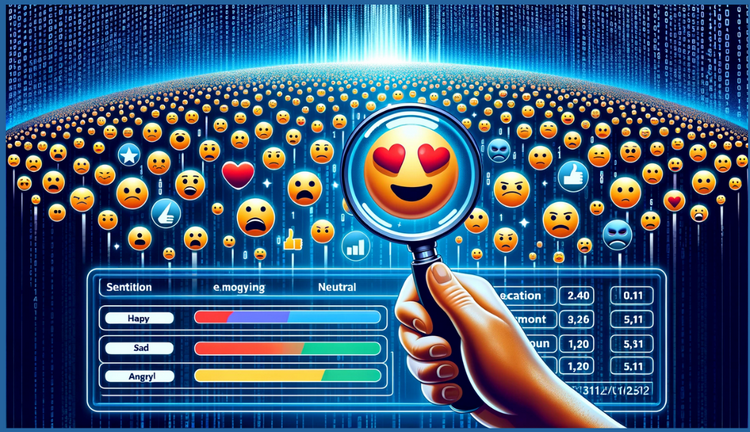

<font size="2pt">*image citation :* [callcriteria.com](https://callcriteria.com/best-sentiment-analysis-tools-blog-2023/)</font>

---

# **Project Overview**

This project aims to analyze consumer sentiment based on their posts, comments, and reviews about Continuous Glucose Monitoring (CGM) devices. The dataset comprises posts collected from various social media and online platforms, including Twitter, Facebook, Reddit, and forums. We will perform sentiment analysis to understand the general consumer experience regarding CGM devices.

---

In [ ]:
import pandas as pd
import re
import nltk
import random
import spacy
import missingno as msno
from gensim import corpora
from gensim.models import LdaModel
import gensim
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import bigrams, trigrams
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')

## **1. Loading and Exploring the Dataset**

### **Objective:**
Load the dataset and perform a preliminary exploration to understand its structure, column types, and any missing values.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Read the Excel file and store it in a DataFrame. Upload the Dataset File to the Collab if you get error
df = pd.read_excel('/content/drive/MyDrive/DSPM/Final Project/Diabetes Continuous Glucose Monitoring – Data Export.xlsx')

In [ ]:
# Display the first few rows of the dataset
df.head(2)

Post ID                                    Sound Bite Text  \
0  BRDRDT2-t1_imq98sr  My numbers are great now. Estimated a1c of 7%i...   
1  BRDRDT2-t1_impbcf4  I tried it for a little while. No side effects...   

   Ratings and Scores                                              Title  \
0                 NaN  Have you been denied a second/third pump? Feel...   
1                 NaN                                          Metformin   

  Source Type             Post Type Is Paid Media Type  \
0      Forums  Replies and Comments      No   No Media   
1      Forums  Replies and Comments      No   No Media   

                                                 URL Media Link  ...  \
0  https://www.reddit.com/r/diabetes_t1/comments/...        NaN  ...   
1  https://www.reddit.com/r/diabetes_t1/comments/...        NaN  ...   

  LexisNexis Company - Any LexisNexis Person - High LexisNexis Person - Any  \
0                      NaN                      NaN                     NaN   
1                      NaN                      NaN                     NaN   

  LexisNexis Institution - High LexisNexis Institution - Any  \
0                           NaN                          NaN   
1                           NaN                          NaN   

  LexisNexis Subject Group 1 LexisNexis Subject 1 LexisNexis Subject Group 2  \
0                        NaN                  NaN                        NaN   
1                        NaN                  NaN                        NaN   

  LexisNexis Subject 2 LexisNexis Other Subjects  
0                  NaN                       NaN  
1                  NaN                       NaN  

[2 rows x 63 columns]

In [ ]:
df.shape

(37844, 63)

In [ ]:
df.columns

Index(['Post ID', 'Sound Bite Text', 'Ratings and Scores', 'Title',
       'Source Type', 'Post Type', 'Is Paid', 'Media Type', 'URL',
       'Media Link', 'Domain', 'Sentiment',
       'Published Date (GMT-04:00) New York', 'Author Gender', 'Author URL',
       'Author Name', 'Author Handle', 'Author ID',
       'Author Location - Country 1', 'Author Location - State/Province 1',
       'Author Location - City 1', 'Author Location - Country 2',
       'Author Location - State/Province 2', 'Author Location - City 2',
       'Author Location - Other', 'Author Reddit Karma',
       'Followers/Daily Unique Visitors/Subscribers', 'Professions',
       'Interests', 'Positive Objects', 'Negative Objects', 'Richness', 'Tags',
       'Quoted Post', 'Quoted Author Name', 'Quoted Author Handle',
       'Total Engagements', 'Post Comments', 'Post Likes', 'Post Shares',
       'Post Views', 'Post Dislikes', 'Reddit Score', 'Product Name',
       'Product Hierarchy', 'Rating', '@Mention Media Tags'

In [ ]:
# Extract 5 random samples
sample_df = df.sample(n=5)

sample_post = []
for i, row in sample_df.iterrows():
    post = f"Post {i+1}: {row['Sound Bite Text']}"
    sample_post.append(post)
print('\n\n'.join(sample_post))

Post 34547: I don't know your BG-test setup , but since I have a CGM (well, it's just freestyle libre), I just eat whatever I want during social events. I'm eating fairly healthy at home, but brunch with friends is a great occasion to inject insulin like crazy (also helps that it's nearly free over here). Hey, you're new to this, so you're not wrong with being careful.

Post 31544: and yet I still have to go wait on hold another 30 minutes so I can tell your authorization department DO DO THEIR GODDAM JOB?? This is why we stockpile essentials. I’m waiting on pump cartridges and new cgm transmitter/sensors.

Post 21341: I haven't used Omnipod but have heard great things about. Tubeless, works with Dexcom, next gen will communicate blood sugar readings to it. Controlled with pdm or smart phone app. The main difference between Medtronic and Tandem pumps are the sensors, which is the data source for the algorithms. ... My A1c hovers between 6.1-6.5 depending on life. It's far less work. I'

## **2. Data Cleaning**
### **Objective:**
Clean the data by remove duplicated rows, remove missing value, drop irrelevant columns, handling quoted post and title context, filtering professional experts and news sources, and filtering out authors with large followers

### **a. Handling Duplicated Rows**

For simplicity and given that **'Sound Bite Text'** represents the core content of the post, we will focus on this column for identifying duplicate entries. While it is best practice to consider other features (like **'Source Type'** or **'Published Date'**), in this analysis, we prioritize the content itself. If multiple rows have identical **'Sound Bite Text'**, we will treat them as duplicates and remove them

In [ ]:
# Drop duplicates based solely on 'Sound Bite Text'
df_cleaned = df.drop_duplicates(subset='Sound Bite Text')

print(f"Original Dataset Shape: {df.shape}")
print(f"Dataset Shape after Dropping Unnecessary Column: {df_cleaned.shape}")

Original Dataset Shape: (37844, 63)
Dataset Shape after Dropping Unnecessary Column: (37844, 63)


### **b. Handling Missing Value**

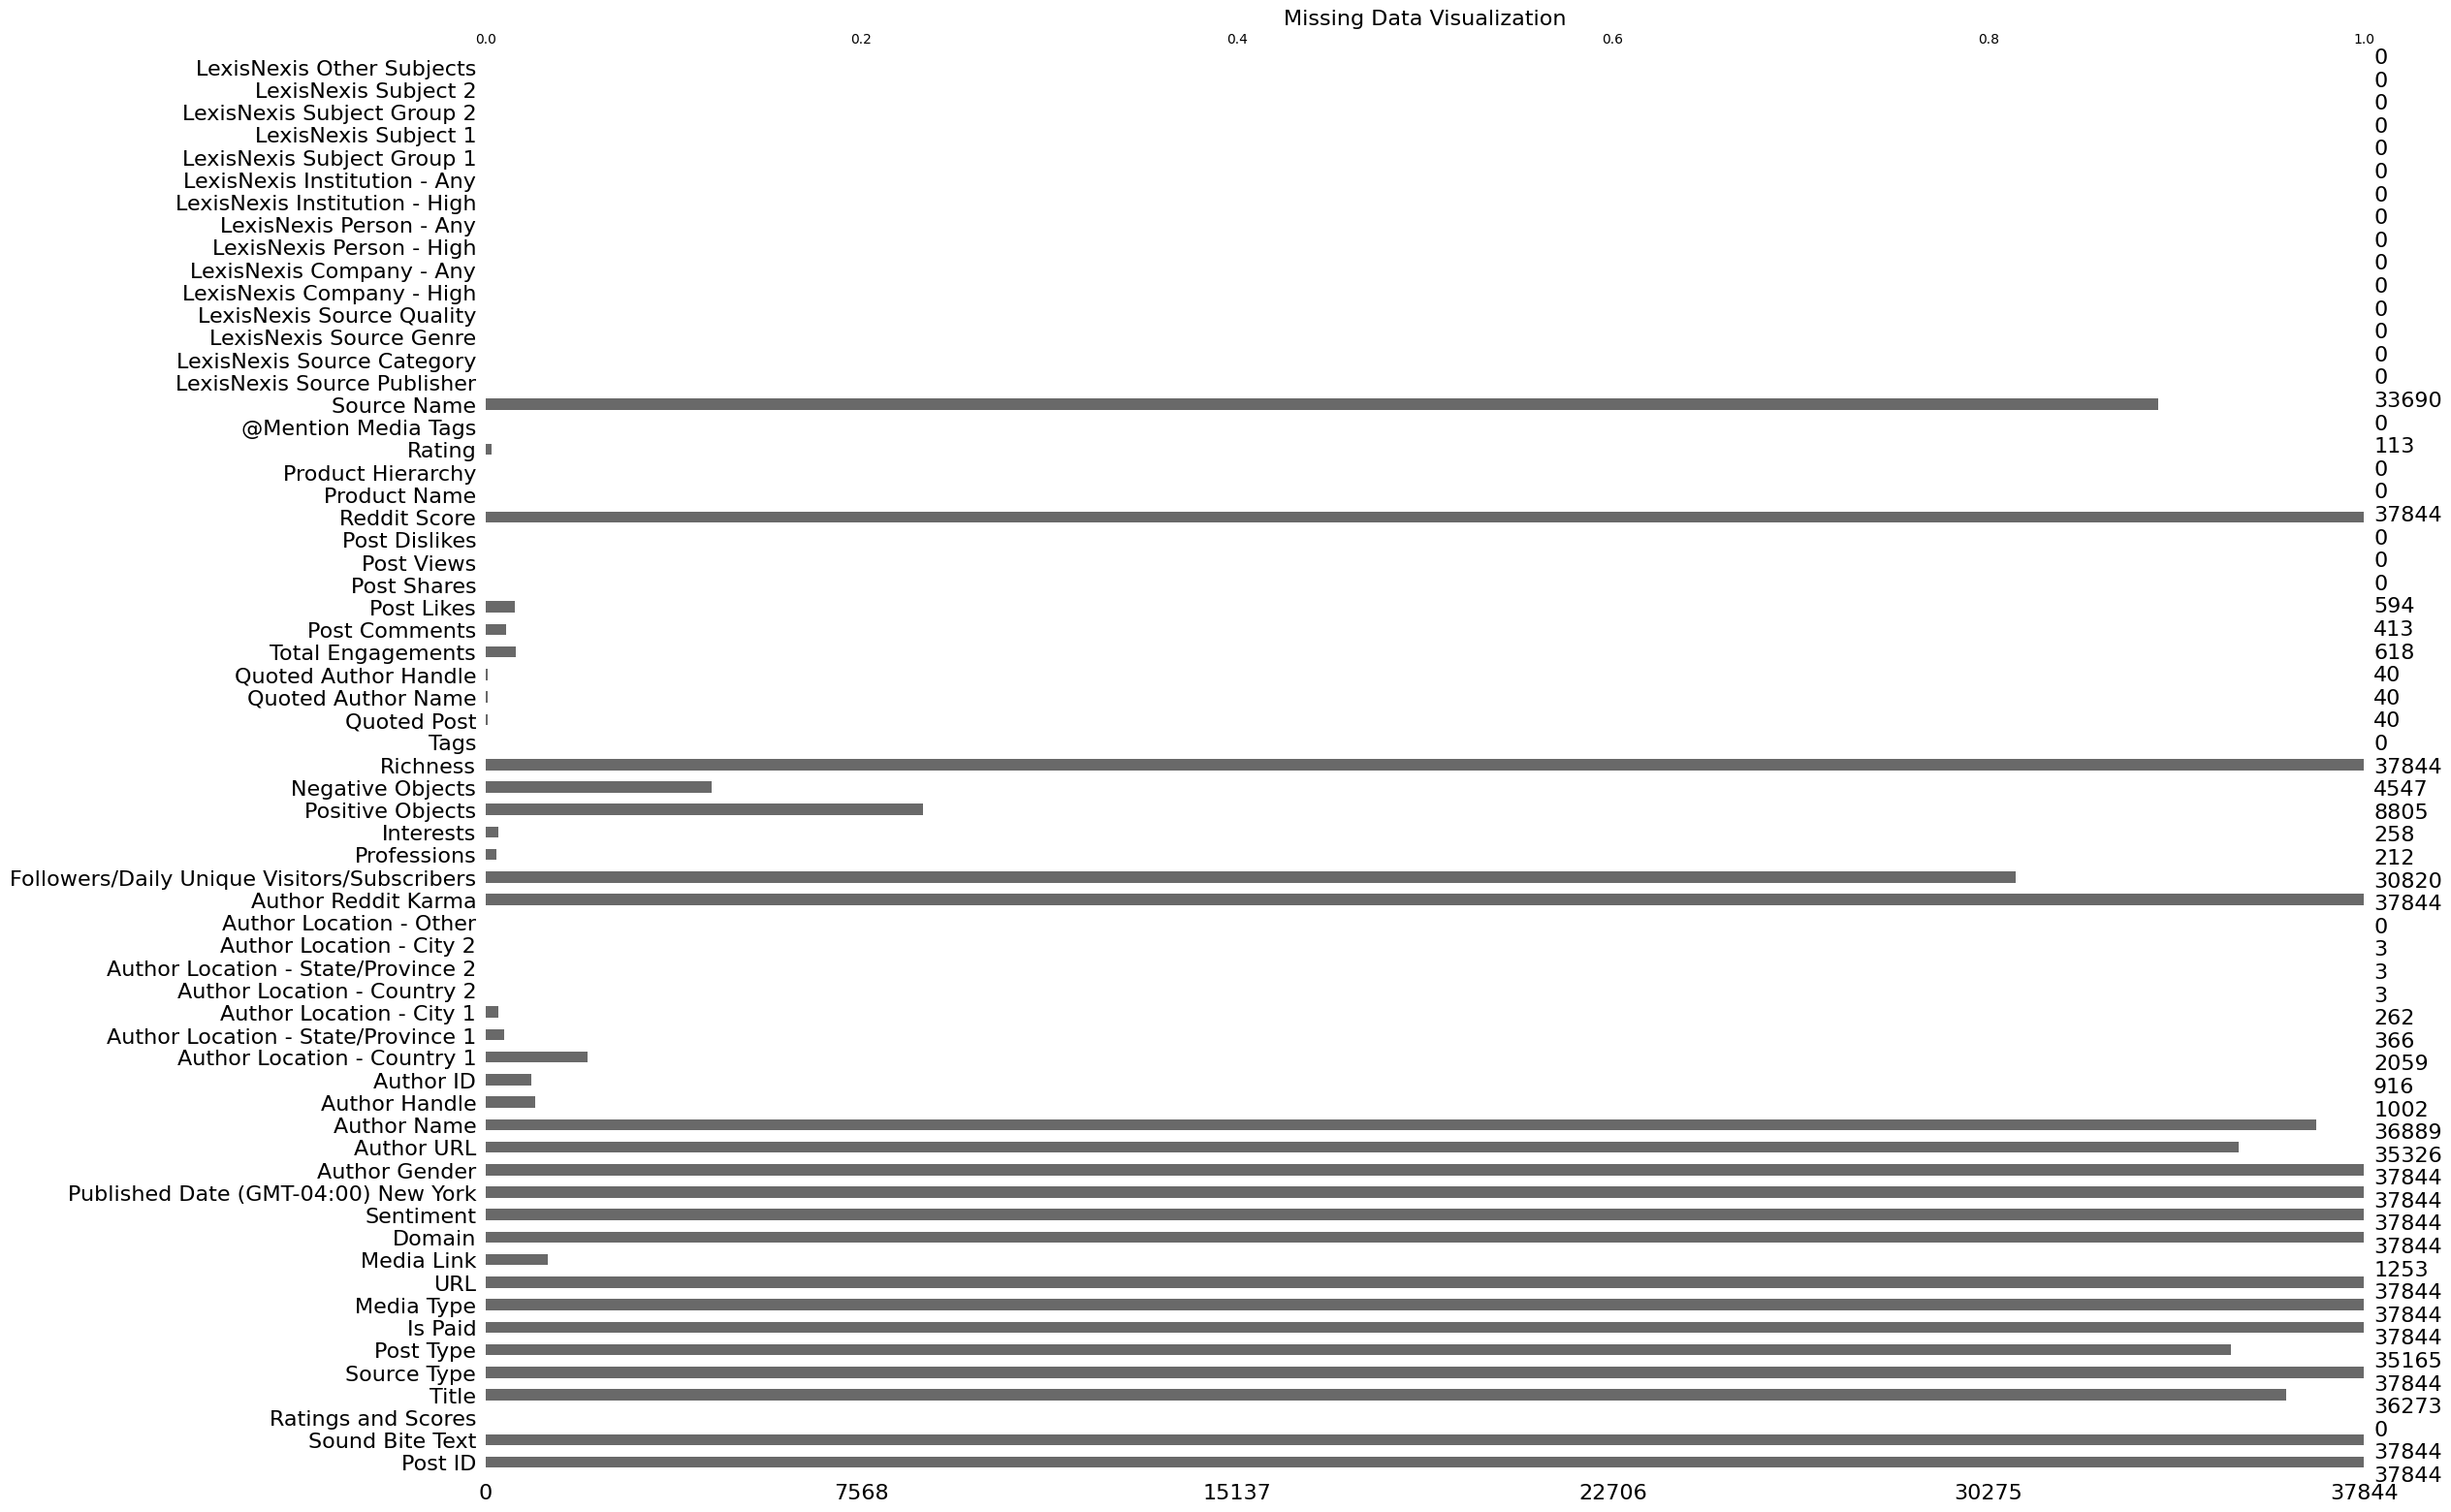

In [ ]:
# Visualize missing data
msno.bar(df)
plt.title("Missing Data Visualization", fontsize=16)
plt.show()

In [ ]:
# Display the information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37844 entries, 0 to 37843
Data columns (total 63 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Post ID                                      37844 non-null  object 
 1   Sound Bite Text                              37844 non-null  object 
 2   Ratings and Scores                           0 non-null      float64
 3   Title                                        36273 non-null  object 
 4   Source Type                                  37844 non-null  object 
 5   Post Type                                    35165 non-null  object 
 6   Is Paid                                      37844 non-null  object 
 7   Media Type                                   37844 non-null  object 
 8   URL                                          37844 non-null  object 
 9   Media Link                                   1253 non-null   object 
 10

Based on the statistics provided, the '**Sound Bite Text**' column has 37844 non-null entries, which means it contains no missing values. Missing values in other features could be explored in the 'Competition and Product Analysis' and 'Audience Analysis' sections.

### **c. Removing Unnecessary Columns**

Certain columns contain no significant data or are entirely missing values, offering no value to our analysis. Additionally, the **'Is Paid'** column contains only the value **"No"** for all records, meaning it does not contribute any useful variation. Therefore, we will remove these columns to streamline the dataset and focus on the meaningful features.

In [ ]:
# List of columns to drop due to missing or irrelevant data
columns_to_drop = [
    'Ratings and Scores', 'Author Location - Other', 'Tags', 'Post Shares',
    'Post Views', 'Post Dislikes', 'Product Name', 'Product Hierarchy',
    '@Mention Media Tags', 'LexisNexis Source Publisher', 'LexisNexis Source Category',
    'LexisNexis Source Genre', 'LexisNexis Source Quality', 'LexisNexis Company - High',
    'LexisNexis Company - Any', 'LexisNexis Person - High', 'LexisNexis Person - Any',
    'LexisNexis Institution - High', 'LexisNexis Institution - Any', 'LexisNexis Subject Group 1',
    'LexisNexis Subject 1', 'LexisNexis Subject Group 2', 'LexisNexis Subject 2',
    'LexisNexis Other Subjects', 'Is Paid'
]

# Drop these columns from the dataset
df_cleaned = df_cleaned.drop(columns=columns_to_drop)

# Display the shape of the dataset after dropping irrelevant columns
print(f"Original Dataset Shape: {df.shape}")
print(f"Dataset Shape after Dropping Irrelevant Columns: {df_cleaned.shape}")

Original Dataset Shape: (37844, 63)
Dataset Shape after Dropping Irrelevant Columns: (37844, 38)


### **d. Handling Quoted Post and Title Context**

We observed that the **'Quoted Post'** column provides additional context for **Original** posts when the source is **Twitter**. In these cases, it captures the quoted content within the tweet, which is relevant to the sentiment analysis. For **other platforms** or when the post type is **Replies and Comments**, or **Blank**, the **'Quoted Post'** column is empty and can be ignored.

Additionally, in **forums and blogs**, the **'Title'** of a post can provide essential context. Therefore, we will combine the **Title** and **Sound Bite Text** for those sources to ensure a complete understanding of the sentiment.

Our approach is as follows:

- Twitter Original Posts: Include both Sound Bite Text and Quoted Post when available.
- Forums and Blogs: Combine Title with Sound Bite Text.
- Other Sources: Use only Sound Bite Text when the Title or Quoted Post does not apply.

By implementing this approach, further analysis will use **'Combined Text'** rather than **'Sound Bite Text'**

In [ ]:
# Define a function to handle combined text based on various conditions
def combine_text_and_context(row):
    # Handle Original Posts from Twitter with Quoted Post
    if row['Source Type'] == 'Twitter' and row['Post Type'] == 'Original' and pd.notnull(row['Quoted Post']):
        return f"{row['Sound Bite Text']} {row['Quoted Post']}"

    # Combine Title and Sound Bite Text for forums and blogs
    elif row['Source Type'] in ['Forum', 'Blog'] and pd.notnull(row['Title']):
        return f"{row['Title']} {row['Sound Bite Text']}"

    # Use only Sound Bite Text for other cases
    else:
        return row['Sound Bite Text']

# Apply the function to create a new 'Combined Text' column
df_cleaned['Combined Text'] = df_cleaned.apply(combine_text_and_context, axis=1)



In [ ]:
# Display the first few rows to verify the changes
df_cleaned[['Source Type', 'Post Type', 'Quoted Post', 'Title', 'Sound Bite Text', 'Combined Text']].head()

Source Type             Post Type Quoted Post  \
0      Forums  Replies and Comments         NaN   
1      Forums  Replies and Comments         NaN   
2     Twitter  Replies and Comments         NaN   
3   Instagram              Original         NaN   
4      Forums  Replies and Comments         NaN   

                                               Title  \
0  Have you been denied a second/third pump? Feel...   
1                                          Metformin   
2                                                NaN   
3                                                NaN   
4                   No bath salts, bath oils, soaks?   

                                     Sound Bite Text  \
0  My numbers are great now. Estimated a1c of 7%i...   
1  I tried it for a little while. No side effects...   
2  i ran out of characters. youtu.be/RWgl2PDhQiM ...   
3  MY lunch! Ate at 10:30am \n1 unit NovoLog insu...   
4  This is also because like a soak in a hot tub ...   

                                       Combined Text  
0  My numbers are great now. Estimated a1c of 7%i...  
1  I tried it for a little while. No side effects...  
2  i ran out of characters. youtu.be/RWgl2PDhQiM ...  
3  MY lunch! Ate at 10:30am \n1 unit NovoLog insu...  
4  This is also because like a soak in a hot tub ...

### **e. Converting Combined Text to Lowercase**

In [ ]:
# Convert to lowercase
df_cleaned['Combined Text'] = df_cleaned['Combined Text'].str.lower()
for i in df_cleaned['Combined Text'].sample(5):
    print("Text: ",i,'\n')

Text:  i'm sure someone has had this issue. i've noticed the adhesive around my dexcom has blood in it. not a lot but i'm wondering if i should leave it the full 10 days or replace it. 

Text:  in my experience i really only got sensor errors when i was using my phone, so i switched back to my receiver (and now use my pump). on other side notes i don’t know if this is true or not, but whenever i get an error i feel like i have to click on it before it starts working again, though this is likely just superstition 

Text:  this is also how life already is if you have a disability. this isn't just an ambiguous future, this is happening in the here and now. i'm type 1 diabetic, and in order to best control my diabetes, i have an insulin pump and a continuous glucose monitor. both of these things are expensive, require software updates and changes, are potential cyber security leaks/weaknesses (they store data about me and my habits), and are basically holding my health hostage. yes, i coul

### **f. Filtering Out Authors with Large Followers**
To eliminate non-relevant data from authors who are likely **professionals** or **celebrities**, we analyze **the number of followers or daily visitors** they have. Authors with a large number of followers are more likely to be professionals, so we aim to identify a threshold beyond which posts will be considered non-consumer content.

We will explore the distribution of the **"Followers/Daily Unique Visitors/Subscribers"** column and use this to set a threshold for filtering out posts from highly influential authors.

In [ ]:
# Fill missing values in the 'Followers/Daily Unique Visitors/Subscribers' column with zero
df_cleaned['Followers/Daily Unique Visitors/Subscribers'] = df_cleaned['Followers/Daily Unique Visitors/Subscribers'].fillna(0)

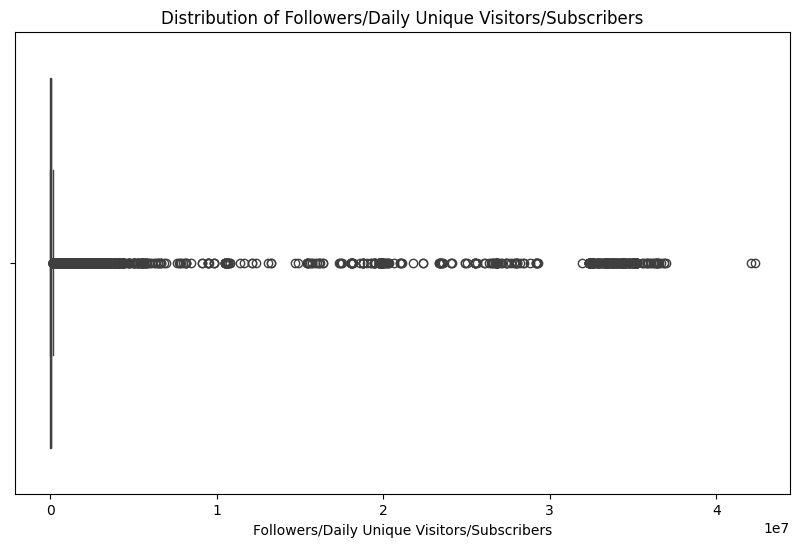

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot to visualize the distribution of 'Followers/Daily Unique Visitors/Subscribers'
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_cleaned['Followers/Daily Unique Visitors/Subscribers'])
plt.title('Distribution of Followers/Daily Unique Visitors/Subscribers')
plt.xlabel('Followers/Daily Unique Visitors/Subscribers')
plt.show()


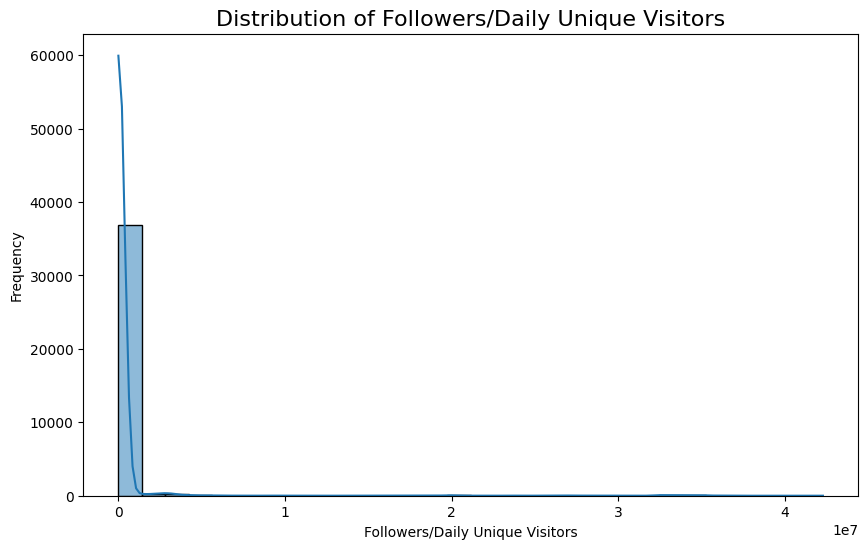

In [ ]:
# Explore the distribution of followers
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['Followers/Daily Unique Visitors/Subscribers'], bins=30, kde=True)
plt.title("Distribution of Followers/Daily Unique Visitors", fontsize=16)
plt.xlabel("Followers/Daily Unique Visitors")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Determine threshold (e.g., 90th percentile)
followers_threshold = df_cleaned['Followers/Daily Unique Visitors/Subscribers'].quantile(0.90)
print(f"Threshold for large followers (90th percentile): {followers_threshold}")

# Filter out authors with large followers
df_cleaned['Is Influencer'] = df_cleaned['Followers/Daily Unique Visitors/Subscribers'] >= followers_threshold

# Step 4: Remove influencers from the dataset
df_cleaned = df_cleaned[df_cleaned['Is Influencer'] == False]

# Display the number of rows before and after filtering
print(f"update dataset shape: {df_cleaned.shape}")


Threshold for large followers (90th percentile): 89336.0
update dataset shape: (34058, 40)


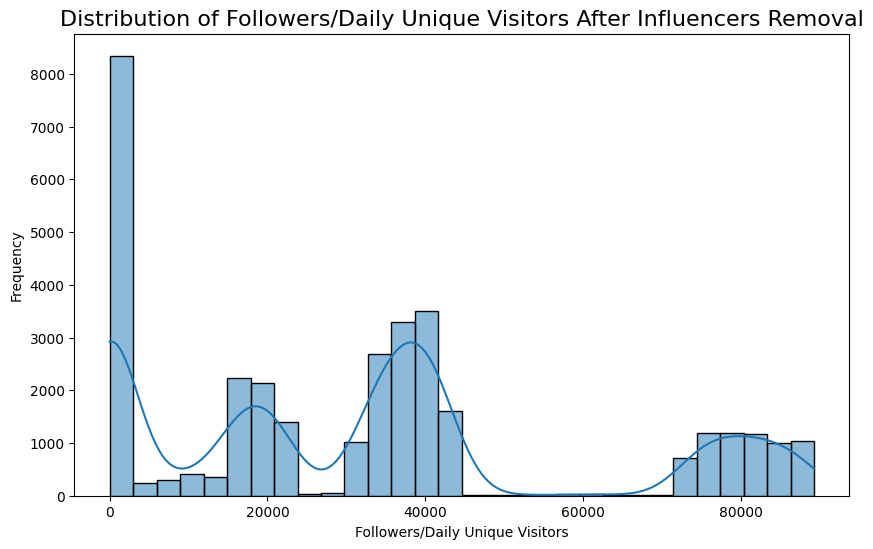

In [ ]:
# Explore the distribution of followers after removing influencers
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['Followers/Daily Unique Visitors/Subscribers'].dropna(), bins=30, kde=True)
plt.title("Distribution of Followers/Daily Unique Visitors After Influencers Removal", fontsize=16)
plt.xlabel("Followers/Daily Unique Visitors")
plt.ylabel("Frequency")
plt.show()

### **g. Filtering Professional Experts and News Sources**
To focus on the original voice of regular consumers, we aim to remove posts from professional experts, such as **journalists**, **bloggers**, and **executive managers**. By filtering out these professions in **'Professions'** column, we can ensure that our analysis captures genuine consumer experiences. We have identified a list of non-consumer professions and will remove any posts associated with them.

In [ ]:
# List of professions that indicate non-consumer or professional experts
non_consumer_professions = ['Sales and Marketing', 'Blogging', 'Journalism', 'Creative Arts', 'Executive Management', 'Entrepreneurship', 'Health and Medicine']

# Define a function to check if the profession belongs to non-consumer professions
def is_non_consumer(profession):
    # If any non-consumer profession is found in the 'Professions' column, return True
    if pd.notnull(profession):
        for non_consumer in non_consumer_professions:
            if non_consumer in profession:
                return True
    return False

# Apply the filter to flag posts from non-consumers
df_cleaned['Is Non Consumer'] = df_cleaned['Professions'].apply(is_non_consumer)

# Filter out non-consumer posts
df_cleaned = df_cleaned[df_cleaned['Is Non Consumer'] == False]

# Display the number of rows before and after filtering
print(f"update dataset shape: {df_cleaned.shape}")


update dataset shape: (33927, 41)


## **3. Text Preprocessing**
### **Objective:**

Process the text data by removing URLs, Newline character, handing emojis, checking hashtags, mentions, and retweets, removing punctuation and tokenizing. This prepares the text for sentiment analysis.

### **a. Cleaning URLs and Newline Characters**

In [ ]:
def cleanTxt(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub('\n', ' ', text)  # Remove newline characters
    text = re.sub('\n\n', ' ', text)  # Remove newline characters
    return text

# Apply the clean_text function to the Combined Text column
df_cleaned['Combined Text'] = df_cleaned['Combined Text'].apply(cleanTxt)

### **b. Handling Emojis**

In [ ]:
# Function to check for the presence of emojis in the text
def contains_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002500-\U00002BEF"  # chinese characters
                           u"\U00002702-\U000027B0"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001F926-\U0001F937"
                           u"\U00010000-\U0010FFFF"
                           u"\u200d"
                           u"\u2640-\u2642"
                           u"\u2600-\u2B55"
                           u"\u23cf"
                           u"\u23e9"
                           u"\u231a"
                           u"\ufe0f"  # dingbats
                           u"\u3030"
                           "]+", flags=re.UNICODE)
    return bool(emoji_pattern.search(text))

# Apply the function to check for emojis in 'Combined Text'
df_with_emojis = df_cleaned[df_cleaned['Combined Text'].apply(contains_emoji)]

# Display the number of rows containing emojis (if any)
if not df_with_emojis.empty:
    print(f"Found {df_with_emojis.shape[0]} rows with emojis.")
    print(df_with_emojis[['Combined Text']].head())
else:
    print("No emojis found in the 'Combined Text' column.")

Found 337 rows with emojis.
                                         Combined Text
3    my lunch! ate at 10:30am  1 unit novolog insul...
5    i’d like a new pancreas please ✌??   #type1dia...
109  you may have been seeing continuous glucose mo...
227  my first time using #freestylelibre and i love...
262  yes! this is me exactly and i’m thinking about...


In [ ]:
import re

# Function to remove all icons (including emojis)
def remove_icons(text):
    icon_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002500-\U00002BEF"  # miscellaneous symbols
                           u"\U0001F900-\U0001F9FF"  # supplemental symbols and pictographs
                           u"\U00002000-\U00002BFF"  # arrows, bullets, stars, math operators
                           u"\U0000FE0F-\U0000FEFF"  # variation selectors
                           u"\U0001F700-\U0001F77F"  # alchemical symbols
                           u"\u200d"                 # zero-width joiner
                           u"\u2640-\u2642"          # gender symbols
                           u"\u2600-\u26FF"          # miscellaneous symbols
                           u"\u23cf"                 # eject symbol
                           u"\u23e9"                 # fast-forward
                           u"\u231a"                 # watch
                           u"\ufe0f"                 # dingbats
                           u"\u3030"                 # wavy dash
                           "]+", flags=re.UNICODE)
    return re.sub(icon_pattern, '', text)

# Apply icon removal to relevant columns in the datasets
df_cleaned['Combined Text Without Icon'] = df_cleaned['Combined Text'].apply(remove_icons)

In [ ]:
# Install emoji library if not installed
!pip install emoji

In [ ]:
# Here, if we want to include emojis in the context as part of our sentiment analysis, we can convert them from symbols into text
import emoji

# Convert emojis to their textual representation
def convert_emoji_to_text(text):
    return emoji.demojize(text)

# Apply to the 'Combined Text' column
df_cleaned['Combined Text'] = df_cleaned['Combined Text'].apply(convert_emoji_to_text)

### **c. Checking for Hashtags, Mentions, and Retweets**

In [ ]:
# Function to check for the presence of hashtags, mentions, or retweets
def check_social_media_elements(text):
    return any([re.search(r'#', text), re.search(r'@', text), re.search(r'\bRT\b', text)])

# Apply the function to check for social media elements in 'Combined Text'
df_with_social_elements = df_cleaned[df_cleaned['Combined Text'].apply(check_social_media_elements)]

# Display the number of rows containing hashtags, mentions, or retweets (if any)
if not df_with_social_elements.empty:
    print(f"Found {df_with_social_elements.shape[0]} rows with social media elements (hashtags, mentions, RT).")
    print(df_with_social_elements[['Combined Text']].head(3))
else:
    print("No hashtags, mentions, or retweets found in the 'Combined Text' column.")

Found 1260 rows with social media elements (hashtags, mentions, RT).
                                        Combined Text
3   my lunch! ate at 10:30am  1 unit novolog insul...
5   i’d like a new pancreas please :victory_hand:?...
54  my son was diagnosed at 12, he is now 18. othe...


In [ ]:
# Create a function to clean the tweets
def remove_social_media_elements(text):
    text = re.sub(r'@[A-Za-z0–9]+', '', text) #Remove @mentions replace with blank
    text = re.sub(r'#', '', text) #Remove the ‘#’ symbol, replace with blank
    text = re.sub(r'RT[\s]+', '', text) #Removing RT, replace with blank
    text = re.sub(r':', '', text) # Remove :
    return text

df_cleaned['Combined Text'] = df_cleaned['Combined Text'].apply(remove_social_media_elements)
df_cleaned['Combined Text Without Icon'] = df_cleaned['Combined Text Without Icon'].apply(remove_social_media_elements)

### **d. Remove Punctuation from the Combined Text**

In [ ]:
# Remove punctuation
def remove_punc(text):
    punc_pattern = r'[^\w\s]'
    return re.sub(punc_pattern, '', text)

df_cleaned['Combined Text'] = df_cleaned['Combined Text'].apply(remove_punc)
df_cleaned['Combined Text Without Icon'] = df_cleaned['Combined Text Without Icon'].apply(remove_punc)

# After executing this code, the 'Combined Text' column in the DataFrame
# will have punctuation removed from its text entries.

#Example:
print(remove_punc("#qa#werqe-q/- Hello ####"))

qawerqeq Hello 


### **e. Tokenization**

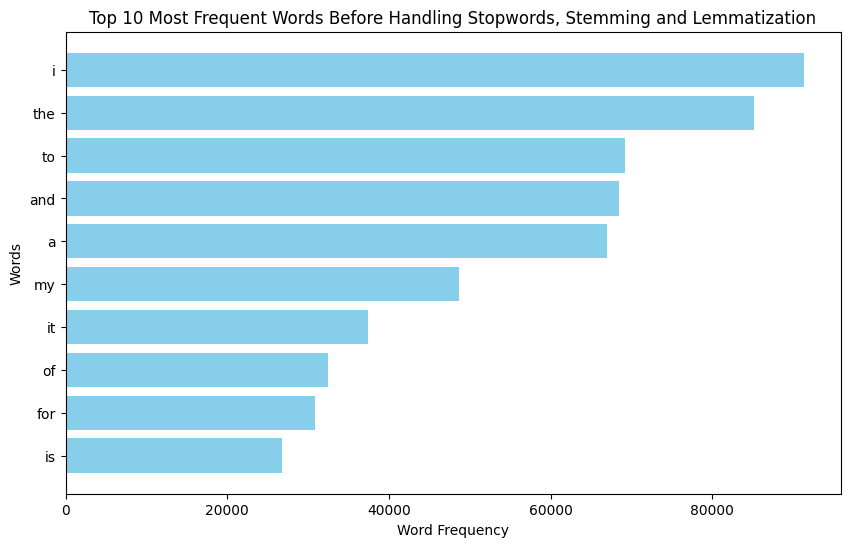

In [ ]:
# Concatenate all the narratives into a single string
all_narratives = ' '.join(df_cleaned['Combined Text'])

# Tokenize the text and count word frequencies
word_counts = Counter(all_narratives.split())

# Convert the word counts into a list of tuples for sorting
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Extract the top N words and their counts
top_words = [word for word, count in sorted_word_counts[:10]]
top_counts = [count for word, count in sorted_word_counts[:10]]

# Create a horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_words, top_counts, color='skyblue')
plt.xlabel('Word Frequency')
plt.ylabel('Words')
plt.title('Top 10 Most Frequent Words Before Handling Stopwords, Stemming and Lemmatization')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency on top
plt.show()

In [ ]:
word_counts

Counter({'my': 48678,
         'numbers': 1269,
         'are': 9648,
         'great': 1813,
         'now': 5846,
         'estimated': 77,
         'a1c': 2763,
         'of': 32497,
         '7ish': 4,
         'he': 2529,
         'doesnt': 2004,
         'care': 1154,
         'what': 6676,
         'i': 91302,
         'say': 1676,
         'wants': 217,
         'the': 85218,
         'actual': 350,
         'labs': 80,
         'and': 68424,
         'will': 6429,
         'not': 12190,
         'look': 1292,
         'at': 10343,
         'dexcom': 21950,
         'stuff': 735,
         'or': 11566,
         'take': 2484,
         'word': 81,
         'for': 30832,
         'it': 37475,
         'tried': 1153,
         'a': 67020,
         'little': 1669,
         'while': 2378,
         'no': 4509,
         'side': 677,
         'effects': 212,
         'did': 2179,
         'help': 2402,
         'with': 23457,
         'insulin': 8079,
         'resistance': 211,
         

### **f. <b>Removing Common, Unimportant Words (Stopwords)</b>**

In [ ]:
# Handling stopwords
nltk.download('punkt')  # For tokenization
nltk.download('stopwords')  # For stopwords
stopwords.words('english')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [ ]:
# Load stopwords
stop_words = set(stopwords.words('english'))

# Removing Stopwords and Updating the Dataset
def remove_stopwords(text):
    words = word_tokenize(text)
    # Remove stopwords and keep only alphabetic words
    words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]
    return ' '.join(words)

# Apply stopword removal to the 'Combined Text' column and update the dataset
df_cleaned['Combined Text'] = df_cleaned['Combined Text'].apply(remove_stopwords)
df_cleaned['Combined Text Without Icon'] = df_cleaned['Combined Text Without Icon'].apply(remove_stopwords)

In [ ]:
# Concatenate all the narratives into a single string
all_narratives_cleaned = ' '.join(df_cleaned['Combined Text'])

# Tokenize the cleaned text and count word frequencies
word_counts_cleaned = Counter(all_narratives_cleaned.split())

# Convert the word counts into a list of tuples for sorting
sorted_word_counts_cleaned = sorted(word_counts_cleaned.items(), key=lambda x: x[1], reverse=True)

# Extract the top N words and their counts
top_words_cleaned = [word for word, count in sorted_word_counts_cleaned[:10]]
top_counts_cleaned = [count for word, count in sorted_word_counts_cleaned[:10]]

# Print most common words after stopword removal
print("Top 10 most common words after stopword removal:")
print(top_words_cleaned)

Top 10 most common words after stopword removal:
['dexcom', 'cgm', 'im', 'pump', 'get', 'blood', 'like', 'insulin', 'glucose', 'libre']


In [ ]:
# Concatenate all the narratives into a single string
all_narratives_cleaned_wthicon = ' '.join(df_cleaned['Combined Text Without Icon'])

# Tokenize the cleaned text and count word frequencies
word_counts_cleaned_wthicon = Counter(all_narratives_cleaned_wthicon.split())

# Convert the word counts into a list of tuples for sorting
sorted_word_counts_cleaned_wthicon = sorted(word_counts_cleaned_wthicon.items(), key=lambda x: x[1], reverse=True)

# Extract the top N words and their counts
top_words_cleaned_wthicon = [word for word, count in sorted_word_counts_cleaned_wthicon[:10]]
top_counts_cleaned_wthicon = [count for word, count in sorted_word_counts_cleaned_wthicon[:10]]

# Print most common words after stopword removal
print("Top 10 most common words after stopword removal:")
print(top_words_cleaned_wthicon)

Top 10 most common words after stopword removal:
['dexcom', 'cgm', 'im', 'pump', 'get', 'blood', 'like', 'insulin', 'glucose', 'libre']


#### **g. Handling Frequent Phrases (Bigrams and Trigrams)**

In [ ]:
# Generate bigrams and trigrams from the cleaned words
cleaned_words_list = all_narratives_cleaned.split()
bigram_list = list(bigrams(cleaned_words_list))
trigram_list = list(trigrams(cleaned_words_list))

# Calculate frequencies of bigrams and trigrams
bigram_freq = FreqDist(bigram_list)
trigram_freq = FreqDist(trigram_list)

# Print most common bigrams and trigrams
print("Top 10 most common bigrams:")
print(bigram_freq.most_common(10))

print("\nTop 10 most common trigrams:")
print(trigram_freq.most_common(10))

Top 10 most common bigrams:
[(('blood', 'sugar'), 4869), (('freestyle', 'libre'), 4299), (('continuous', 'glucose'), 3150), (('glucose', 'monitor'), 2427), (('pump', 'cgm'), 1335), (('insulin', 'pump'), 1312), (('blood', 'glucose'), 1213), (('blood', 'sugars'), 914), (('glucose', 'monitoring'), 874), (('dexcom', 'cgm'), 836)]

Top 10 most common trigrams:
[(('continuous', 'glucose', 'monitor'), 2098), (('continuous', 'glucose', 'monitoring'), 666), (('blood', 'sugar', 'levels'), 456), (('using', 'freestyle', 'libre'), 354), (('continuous', 'glucose', 'monitors'), 340), (('glucose', 'monitor', 'cgm'), 329), (('use', 'freestyle', 'libre'), 329), (('closed', 'loop', 'system'), 278), (('freestyle', 'libre', 'sensor'), 269), (('low', 'blood', 'sugar'), 260)]


In [ ]:
# Generate bigrams and trigrams from the cleaned words
cleaned_words_list_wthicon = all_narratives_cleaned_wthicon.split()
bigram_list_wthicon = list(bigrams(cleaned_words_list_wthicon))
trigram_list_wthicon = list(trigrams(cleaned_words_list_wthicon))

# Calculate frequencies of bigrams and trigrams
bigram_freq_wthicon = FreqDist(bigram_list_wthicon)
trigram_freq_wthicon = FreqDist(trigram_list_wthicon)

# Print most common bigrams and trigrams
print("Top 10 most common bigrams:")
print(bigram_freq_wthicon.most_common(10))

print("\nTop 10 most common trigrams:")
print(trigram_freq_wthicon.most_common(10))

Top 10 most common bigrams:
[(('blood', 'sugar'), 4870), (('freestyle', 'libre'), 4303), (('continuous', 'glucose'), 3150), (('glucose', 'monitor'), 2428), (('pump', 'cgm'), 1335), (('insulin', 'pump'), 1312), (('blood', 'glucose'), 1213), (('blood', 'sugars'), 914), (('glucose', 'monitoring'), 873), (('dexcom', 'cgm'), 836)]

Top 10 most common trigrams:
[(('continuous', 'glucose', 'monitor'), 2099), (('continuous', 'glucose', 'monitoring'), 665), (('blood', 'sugar', 'levels'), 456), (('using', 'freestyle', 'libre'), 354), (('continuous', 'glucose', 'monitors'), 340), (('glucose', 'monitor', 'cgm'), 329), (('use', 'freestyle', 'libre'), 329), (('closed', 'loop', 'system'), 278), (('freestyle', 'libre', 'sensor'), 270), (('low', 'blood', 'sugar'), 260)]


##### <b>Remove Frequent Words, Bigrams, and Trigrams</b>

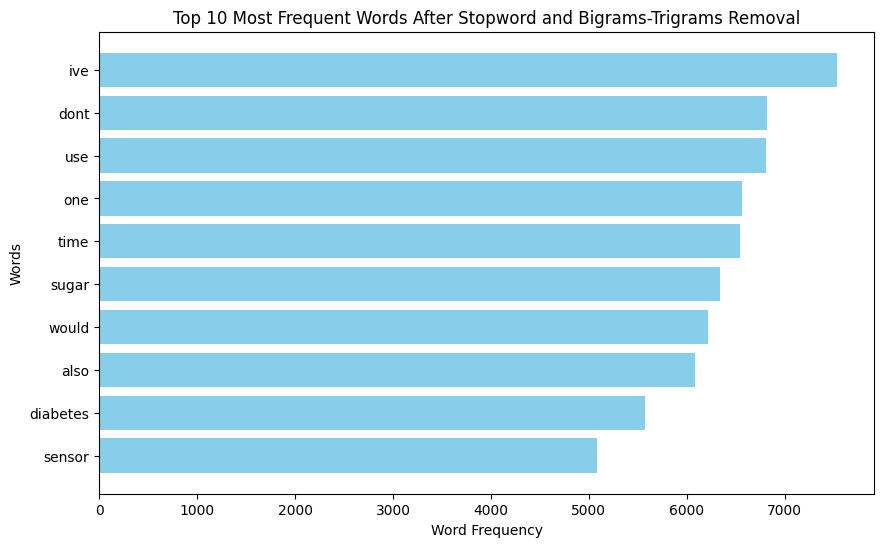

Top 10 most common words after removing frequent words, bigrams, and trigrams:
['ive', 'dont', 'use', 'one', 'time', 'sugar', 'would', 'also', 'diabetes', 'sensor']


In [ ]:
# Define frequent words (top 10 most common words after stopword removal)
frequent_words = ['dexcom', 'cgm', 'im', 'pump', 'get', 'blood', 'like', 'insulin', 'glucose', 'libre']

# Define frequent bigrams (top 10 most common bigrams)
frequent_bigrams = [('blood', 'sugar'), ('freestyle', 'libre'), ('continuous', 'glucose'), ('glucose', 'monitor'), ('pump', 'cgm'),
                    ('insulin', 'pump'), ('blood', 'glucose'), ('blood', 'sugars'), ('glucose', 'monitoring'), ('dexcom', 'cgm')]

# Define frequent trigrams (top 10 most common trigrams)
frequent_trigrams = [('continuous', 'glucose', 'monitor'), ('continuous', 'glucose', 'monitoring'), ('blood', 'sugar', 'levels'),
                     ('using', 'freestyle', 'libre'), ('continuous', 'glucose', 'monitors'), ('glucose', 'monitor', 'cgm'),
                     ('use', 'freestyle', 'libre'), ('closed', 'loop', 'system'), ('freestyle', 'libre', 'sensor'), ('low', 'blood', 'sugar')]

# Remove Frequent Words, Bigrams, and Trigrams
def remove_frequent_phrases(text):
    # Tokenize the text into individual words
    words = text.split()

    # Generate bigrams and trigrams from the tokenized words
    bigram_list = list(bigrams(words))
    trigram_list = list(trigrams(words))

    # Remove frequent words
    words = [word for word in words if word.lower() not in frequent_words]

    # Remove frequent bigrams
    bigram_list = [bigram for bigram in bigram_list if bigram not in frequent_bigrams]

    # Remove frequent trigrams
    trigram_list = [trigram for trigram in trigram_list if trigram not in frequent_trigrams]

    # Join the remaining words back into a string
    preprocessed_text = ' '.join(words)  # Join individual words
    return preprocessed_text

# Apply the function to the 'Combined Text' column to remove frequent phrases
df_cleaned['Combined Text'] = df_cleaned['Combined Text'].apply(remove_frequent_phrases)

# Verify the Results by Rechecking Word Statistics After Removal
# Concatenate all the narratives into a single string after cleaning
all_narratives_cleaned_final = ' '.join(df_cleaned['Combined Text'])

# Tokenize the cleaned text and count word frequencies again
word_counts_cleaned_final = Counter(all_narratives_cleaned_final.split())

# Convert the word counts into a list of tuples for sorting
sorted_word_counts_cleaned_final = sorted(word_counts_cleaned_final.items(), key=lambda x: x[1], reverse=True)

# Extract the top N words and their counts after removal of frequent phrases
top_words_cleaned_final = [word for word, count in sorted_word_counts_cleaned_final[:10]]
top_counts_cleaned_final = [count for word, count in sorted_word_counts_cleaned_final[:10]]

# Create a horizontal bar chart to visualize the most common words
plt.figure(figsize=(10, 6))
plt.barh(top_words_cleaned_final, top_counts_cleaned_final, color='skyblue')
plt.xlabel('Word Frequency')
plt.ylabel('Words')
plt.title('Top 10 Most Frequent Words After Stopword and Bigrams-Trigrams Removal')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency on top
plt.show()

# Print most common words after removing frequent phrases
print("Top 10 most common words after removing frequent words, bigrams, and trigrams:")
print(top_words_cleaned_final)

##### **To respon audience in Presentation session: Is there any different between conversion icon and without conversion icon in your analysis?**

Add and treat a new column 'Combined Text Without Icon' in sentiment analysis process

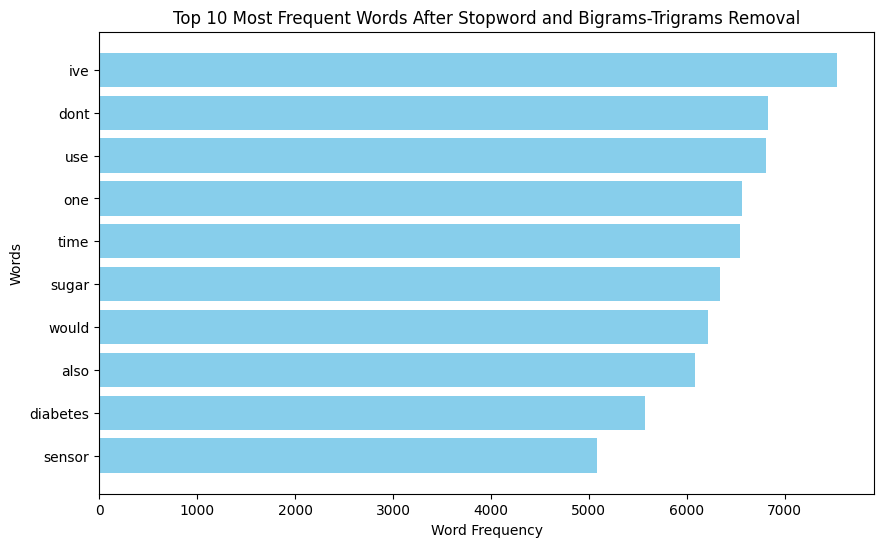

Top 10 most common words after removing frequent words, bigrams, and trigrams:
['ive', 'dont', 'use', 'one', 'time', 'sugar', 'would', 'also', 'diabetes', 'sensor']


In [ ]:
# Define frequent words (top 10 most common words after stopword removal)
frequent_words_wthicon = ['dexcom', 'cgm', 'im', 'pump', 'get', 'blood', 'like', 'insulin', 'glucose', 'libre']

# Define frequent bigrams (top 10 most common bigrams)
frequent_bigrams_wthicon = [('blood', 'sugar'), ('freestyle', 'libre'), ('continuous', 'glucose'), ('glucose', 'monitor'), ('pump', 'cgm'),
                    ('insulin', 'pump'), ('blood', 'glucose'), ('blood', 'sugars'), ('glucose', 'monitoring'), ('dexcom', 'cgm')]

# Define frequent trigrams (top 10 most common trigrams)
frequent_trigrams_wthicon = [('continuous', 'glucose', 'monitor'), ('continuous', 'glucose', 'monitoring'), ('blood', 'sugar', 'levels'),
                     ('using', 'freestyle', 'libre'), ('continuous', 'glucose', 'monitors'), ('glucose', 'monitor', 'cgm'),
                     ('use', 'freestyle', 'libre'), ('closed', 'loop', 'system'), ('freestyle', 'libre', 'sensor'), ('low', 'blood', 'sugar')]

# Remove Frequent Words, Bigrams, and Trigrams
def remove_frequent_phrases(text):
    # Tokenize the text into individual words
    words = text.split()

    # Generate bigrams and trigrams from the tokenized words
    bigram_list = list(bigrams(words))
    trigram_list = list(trigrams(words))

    # Remove frequent words
    words = [word for word in words if word.lower() not in frequent_words_wthicon]

    # Remove frequent bigrams
    bigram_list = [bigram for bigram in bigram_list if bigram not in frequent_bigrams_wthicon]

    # Remove frequent trigrams
    trigram_list = [trigram for trigram in trigram_list if trigram not in frequent_trigrams_wthicon]

    # Join the remaining words back into a string
    preprocessed_text = ' '.join(words)  # Join individual words
    return preprocessed_text

# Apply the function to the 'Combined Text Without Icon' column to remove frequent phrases
df_cleaned['Combined Text Without Icon'] = df_cleaned['Combined Text Without Icon'].apply(remove_frequent_phrases)

# Verify the Results by Rechecking Word Statistics After Removal
# Concatenate all the narratives into a single string after cleaning
all_narratives_cleaned_wthicon_final = ' '.join(df_cleaned['Combined Text Without Icon'])

# Tokenize the cleaned text and count word frequencies again
word_counts_cleaned_wthicon_final = Counter(all_narratives_cleaned_wthicon_final.split())

# Convert the word counts into a list of tuples for sorting
sorted_word_counts_cleaned_wthicon_final = sorted(word_counts_cleaned_wthicon_final.items(), key=lambda x: x[1], reverse=True)

# Extract the top N words and their counts after removal of frequent phrases
top_words_cleaned_wthicon_final = [word for word, count in sorted_word_counts_cleaned_wthicon_final[:10]]
top_counts_cleaned_wthicon_final = [count for word, count in sorted_word_counts_cleaned_wthicon_final[:10]]

# Create a horizontal bar chart to visualize the most common words
plt.figure(figsize=(10, 6))
plt.barh(top_words_cleaned_wthicon_final, top_counts_cleaned_wthicon_final, color='skyblue')
plt.xlabel('Word Frequency')
plt.ylabel('Words')
plt.title('Top 10 Most Frequent Words Without icon After Stopword and Bigrams-Trigrams Removal')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency on top
plt.show()

# Print most common words after removing frequent phrases
print("Top 10 most common words without icon after removing frequent words, bigrams, and trigrams:")
print(top_words_cleaned_wthicon_final)

In [ ]:
# Extract 10 random samples
sample_df = df_cleaned.sample(n=5)

sample_posts = []
for i, row in sample_df.iterrows():
    tweet = f"Tweet {i+1}: {row['Combined Text']}"
    sample_posts.append(tweet)
print('\n\n'.join(sample_posts))

Tweet 31359: saved article later scrolling tell something want read said put regarding carbs false doesnt consider glycemic index even fat protein meal got noticed crazy spikes simple carbs bread rice etc spike really worth time even prebolus difficult eat time right prebolus probably right eat depending factors maybe

Tweet 23196: hello years arrived doorstep change life question anything wish know starting tips also relevant mdi well desire moment back times ended hospital dka different pumps

Tweet 27186: personally doctor set alert settings looking app frequently alerts mostly asleep plus closed loop system set try keep please dont worry much unless really depend alarms daytoday life

Tweet 17532: got diagnosed years ago know feel active kind guy punch got diagnosed going keto acidosis almost dying lol one suggestions asap well use omnipod made much easier manage also job great benefits wont paying lot medication

Tweet 35666: thats everyone always says make sure needles pens backu

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

#### **h. Stemming and Lemmatization**

In [ ]:
def preprocess_text(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize the text
    words = word_tokenize(text)

    # Perform stemming (using Porter Stemmer)
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in words]

    # Perform lemmatization (using WordNet Lemmatizer)
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]

    # Join the processed words back into a sentence
    stemmed_text = ' '.join(stemmed_words)
    lemmatized_text = ' '.join(lemmatized_words)

    return stemmed_words, lemmatized_words

# Apply the preprocessing function to the 'Sound Bite Text' column
df_cleaned['Stemmed Text'], df_cleaned['Lemmatized Text'] = zip(*df_cleaned['Combined Text'].apply(preprocess_text))

In [ ]:
df_cleaned.head()

Post ID                                    Sound Bite Text  \
0   BRDRDT2-t1_imq98sr  My numbers are great now. Estimated a1c of 7%i...   
1   BRDRDT2-t1_impbcf4  I tried it for a little while. No side effects...   
2  1565738759353602048  i ran out of characters. youtu.be/RWgl2PDhQiM ...   
3    17944607459251789  MY lunch! Ate at 10:30am \n1 unit NovoLog insu...   
5    17875966583693003  I’d like a new pancreas please ✌?? \n\n#type1d...   

                                               Title Source Type  \
0  Have you been denied a second/third pump? Feel...      Forums   
1                                          Metformin      Forums   
2                                                NaN     Twitter   
3                                                NaN   Instagram   
5                                                NaN   Instagram   

              Post Type Media Type  \
0  Replies and Comments   No Media   
1  Replies and Comments   No Media   
2  Replies and Comments       Link   
3              Original      Image   
5              Original   No Media   

                                                 URL  \
0  https://www.reddit.com/r/diabetes_t1/comments/...   
1  https://www.reddit.com/r/diabetes_t1/comments/...   
2  http://twitter.com/bromid/statuses/15657387593...   
3           https://www.instagram.com/p/Ch-gqL-Onqk/   
5        https://www.instagram.com/reel/Ch959C7OoP3/   

                                          Media Link         Domain  \
0                                                NaN     reddit.com   
1                                                NaN     reddit.com   
2                                                NaN    twitter.com   
3  https://scontent-iad3-1.cdninstagram.com/v/t51...  instagram.com   
5                                                NaN  instagram.com   

   Sentiment  ... Post Comments Post Likes Reddit Score Rating    Source Name  \
0   Neutrals  ...           NaN        NaN            0    NaN  r/diabetes_t1   
1  Positives  ...           NaN        NaN            0    NaN  r/diabetes_t1   
2  Positives  ...           NaN        NaN            -    NaN            NaN   
3   Neutrals  ...           NaN       11.0            -    NaN            NaN   
5   Neutrals  ...           2.0       54.0            -    NaN            NaN   

                                       Combined Text Is Influencer  \
0  numbers great estimated doesnt care say wants ...         False   
1  tried little side effects help resistance foun...         False   
2  ran characters ill also say newly diagnosed id...         False   
3  lunch ate unit novolog via grilled chicken fet...         False   
5  id new pancreas please dexcomwarrior diabetics...         False   

  Is Non Consumer                                       Stemmed Text  \
0           False  [number, great, estim, doesnt, care, say, want...   
1           False  [tri, littl, side, effect, help, resist, found...   
2           False  [ran, charact, ill, also, say, newli, diagnos,...   
3           False  [lunch, ate, unit, novolog, via, grill, chicke...   
5           False  [id, new, pancrea, pleas, dexcomwarrior, diabe...   

                                     Lemmatized Text  
0  [number, great, estimated, doesnt, care, say, ...  
1  [tried, little, side, effect, help, resistance...  
2  [ran, character, ill, also, say, newly, diagno...  
3  [lunch, ate, unit, novolog, via, grilled, chic...  
5  [id, new, pancreas, please, dexcomwarrior, dia...  

[5 rows x 43 columns]

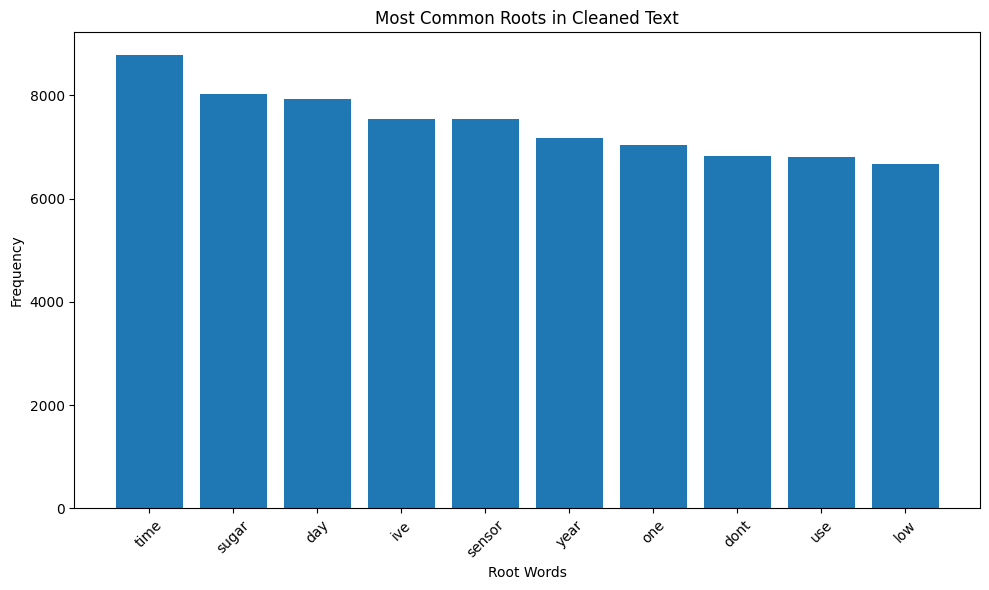

In [ ]:
cleaned_words_stemmed = [stem for stems_list in df_cleaned['Lemmatized Text'] for stem in stems_list]

# Use Counter to count the frequency of each root
word_freq = Counter(cleaned_words_stemmed)

# Get the most common roots
most_common_roots = word_freq.most_common(10)

# Extract the roots and their frequencies for plotting
roots, frequencies = zip(*most_common_roots)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(roots, frequencies)
plt.xlabel('Root Words')
plt.ylabel('Frequency')
plt.title('Most Common Roots in Cleaned Text')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

## **EDA**


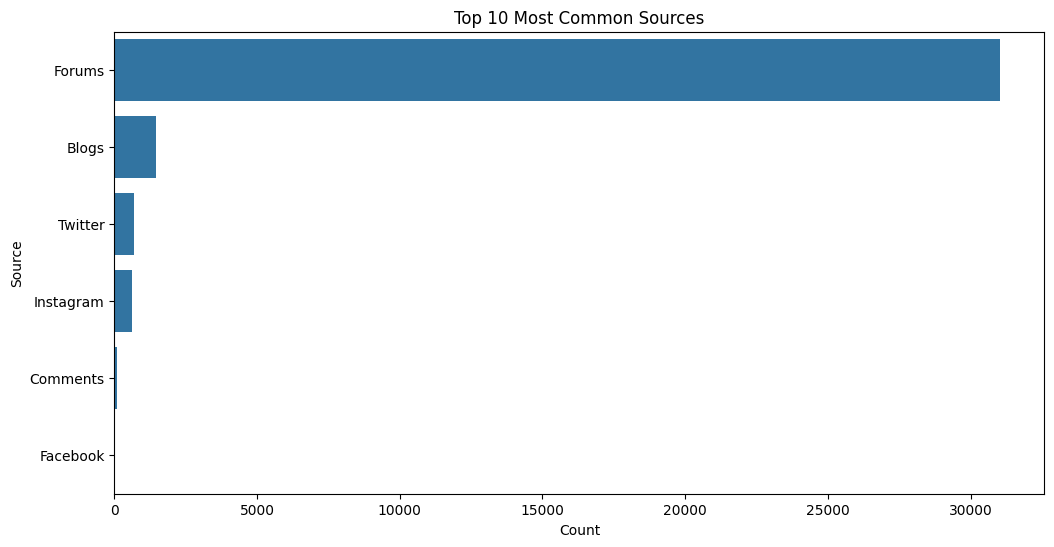

In [ ]:
# Group and aggregate data to count occurrences
source_counts = df_cleaned['Source Type'].value_counts().nlargest(10)

# Create a single subplot for visualizations
fig, ax = plt.subplots(figsize=(12, 6))

# Plot most common sources
sns.barplot(x=source_counts.values, y=source_counts.index, ax=ax)
ax.set_title('Top 10 Most Common Sources')
ax.set_xlabel('Count')
ax.set_ylabel('Source')

# Show the plot
plt.show()

In [ ]:
df_sentiment = df_cleaned.groupby('Sentiment').count()['Post ID'].reset_index().sort_values(by='Post ID',ascending=False)
df_sentiment = df_sentiment.rename(columns={'Post ID': 'Total'})

### <b>Identify The Most Common Roots in The Cleaned Text. </b>

In [ ]:
import plotly.express as px

# Flatten the list of lemmatized words
cleaned_words_lemmatized = [lemma for lemma_list in df_cleaned['Lemmatized Text'] for lemma in lemma_list]

# Use Counter to count the frequency of each root word (lemmatized)
word_freq_lemmatized = Counter(cleaned_words_lemmatized)

# Get the most common lemmatized words
most_common_lemmatized = word_freq_lemmatized.most_common(20)

# Convert to DataFrame
temp_lemmatized = pd.DataFrame(most_common_lemmatized, columns=['Common_words', 'count'])

# Fancy bar chart for lemmatized words
fig = px.bar(temp_lemmatized, x="count", y="Common_words", title='Most Common Lemmatized Words', orientation='h',
             width=700, height=700, color='Common_words')
fig.show()

# Treemap for lemmatized words
fig = px.treemap(temp_lemmatized, path=['Common_words'], values='count', title='Treemap of Most Common Lemmatized Words')
fig.show()

In [ ]:
df_cleaned.head()

Post ID                                    Sound Bite Text  \
0   BRDRDT2-t1_imq98sr  My numbers are great now. Estimated a1c of 7%i...   
1   BRDRDT2-t1_impbcf4  I tried it for a little while. No side effects...   
2  1565738759353602048  i ran out of characters. youtu.be/RWgl2PDhQiM ...   
3    17944607459251789  MY lunch! Ate at 10:30am \n1 unit NovoLog insu...   
5    17875966583693003  I’d like a new pancreas please ✌?? \n\n#type1d...   

                                               Title Source Type  \
0  Have you been denied a second/third pump? Feel...      Forums   
1                                          Metformin      Forums   
2                                                NaN     Twitter   
3                                                NaN   Instagram   
5                                                NaN   Instagram   

              Post Type Media Type  \
0  Replies and Comments   No Media   
1  Replies and Comments   No Media   
2  Replies and Comments       Link   
3              Original      Image   
5              Original   No Media   

                                                 URL  \
0  https://www.reddit.com/r/diabetes_t1/comments/...   
1  https://www.reddit.com/r/diabetes_t1/comments/...   
2  http://twitter.com/bromid/statuses/15657387593...   
3           https://www.instagram.com/p/Ch-gqL-Onqk/   
5        https://www.instagram.com/reel/Ch959C7OoP3/   

                                          Media Link         Domain  \
0                                                NaN     reddit.com   
1                                                NaN     reddit.com   
2                                                NaN    twitter.com   
3  https://scontent-iad3-1.cdninstagram.com/v/t51...  instagram.com   
5                                                NaN  instagram.com   

   Sentiment  ... Post Comments Post Likes Reddit Score Rating    Source Name  \
0   Neutrals  ...           NaN        NaN            0    NaN  r/diabetes_t1   
1  Positives  ...           NaN        NaN            0    NaN  r/diabetes_t1   
2  Positives  ...           NaN        NaN            -    NaN            NaN   
3   Neutrals  ...           NaN       11.0            -    NaN            NaN   
5   Neutrals  ...           2.0       54.0            -    NaN            NaN   

                                       Combined Text Is Influencer  \
0  numbers great estimated doesnt care say wants ...         False   
1  tried little side effects help resistance foun...         False   
2  ran characters ill also say newly diagnosed id...         False   
3  lunch ate unit novolog via grilled chicken fet...         False   
5  id new pancreas please dexcomwarrior diabetics...         False   

  Is Non Consumer                                       Stemmed Text  \
0           False  [number, great, estim, doesnt, care, say, want...   
1           False  [tri, littl, side, effect, help, resist, found...   
2           False  [ran, charact, ill, also, say, newli, diagnos,...   
3           False  [lunch, ate, unit, novolog, via, grill, chicke...   
5           False  [id, new, pancrea, pleas, dexcomwarrior, diabe...   

                                     Lemmatized Text  
0  [number, great, estimated, doesnt, care, say, ...  
1  [tried, little, side, effect, help, resistance...  
2  [ran, character, ill, also, say, newly, diagno...  
3  [lunch, ate, unit, novolog, via, grilled, chic...  
5  [id, new, pancreas, please, dexcomwarrior, dia...  

[5 rows x 43 columns]

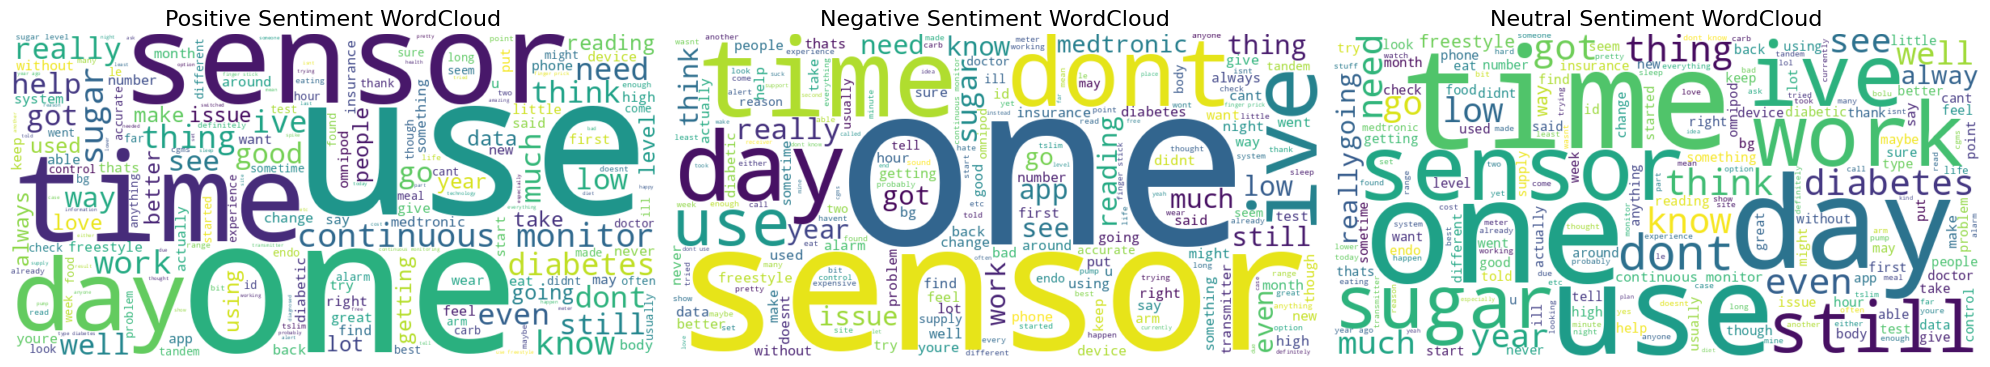

In [ ]:
# Import necessary libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Define a function to generate word clouds for a specific sentiment
def generate_wordcloud(text, title, ax):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(title, fontsize=16)

# Filter data by sentiment
df_positive = df_cleaned[df_cleaned['Sentiment'] == 'Positives']
df_negative = df_cleaned[df_cleaned['Sentiment'] == 'Negatives']
df_neutral = df_cleaned[df_cleaned['Sentiment'] == 'Neutrals']

# Extract lemmatized words for each sentiment
positive_words = [lemma for lemma_list in df_positive['Lemmatized Text'] if isinstance(lemma_list, list) for lemma in lemma_list]
negative_words = [lemma for lemma_list in df_negative['Lemmatized Text'] if isinstance(lemma_list, list) for lemma in lemma_list]
neutral_words = [lemma for lemma_list in df_neutral['Lemmatized Text'] if isinstance(lemma_list, list) for lemma in lemma_list]

# Create a single row of 3 subplots (one for each sentiment)
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# Generate word clouds for each sentiment and display them in the subplots
generate_wordcloud(positive_words, "Positive Sentiment WordCloud", axes[0])
generate_wordcloud(negative_words, "Negative Sentiment WordCloud", axes[1])
generate_wordcloud(neutral_words, "Neutral Sentiment WordCloud", axes[2])

# Display the word clouds
plt.tight_layout()
plt.show()


In [ ]:
df_sentiment

Sentiment  Total
2   Neutrals  21767
3  Positives   8749
1  Negatives   2292
0      Mixed   1119

In [ ]:
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# Create the funnel chart
fig = go.Figure(go.Funnelarea(
    text = df_sentiment.Sentiment,  # Labels for the funnel areas
    values = df_sentiment.Total,    # Values for each section of the funnel
))

# Set the title of the chart
fig.update_layout(
    title={
        'text': "Funnel-Chart of Sentiment Distribution",
        'y':0.9,  # Title position (higher on the plot)
        'x':0.5,  # Center the title
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

# Show the chart
fig.show()


## **Competition and Product Analysis**

In [ ]:
#add a column to keep the original texts from sound bite text and title
df_cleaned['Original Combined Text'] = df_cleaned.apply(combine_text_and_context, axis=1)
df_cleaned.head()


Post ID                                    Sound Bite Text  \
0   BRDRDT2-t1_imq98sr  My numbers are great now. Estimated a1c of 7%i...   
1   BRDRDT2-t1_impbcf4  I tried it for a little while. No side effects...   
2  1565738759353602048  i ran out of characters. youtu.be/RWgl2PDhQiM ...   
3    17944607459251789  MY lunch! Ate at 10:30am \n1 unit NovoLog insu...   
5    17875966583693003  I’d like a new pancreas please ✌?? \n\n#type1d...   

                                               Title Source Type  \
0  Have you been denied a second/third pump? Feel...      Forums   
1                                          Metformin      Forums   
2                                                NaN     Twitter   
3                                                NaN   Instagram   
5                                                NaN   Instagram   

              Post Type Media Type  \
0  Replies and Comments   No Media   
1  Replies and Comments   No Media   
2  Replies and Comments       Link   
3              Original      Image   
5              Original   No Media   

                                                 URL  \
0  https://www.reddit.com/r/diabetes_t1/comments/...   
1  https://www.reddit.com/r/diabetes_t1/comments/...   
2  http://twitter.com/bromid/statuses/15657387593...   
3           https://www.instagram.com/p/Ch-gqL-Onqk/   
5        https://www.instagram.com/reel/Ch959C7OoP3/   

                                          Media Link         Domain  \
0                                                NaN     reddit.com   
1                                                NaN     reddit.com   
2                                                NaN    twitter.com   
3  https://scontent-iad3-1.cdninstagram.com/v/t51...  instagram.com   
5                                                NaN  instagram.com   

   Sentiment  ... Reddit Score Rating    Source Name  \
0   Neutrals  ...            0    NaN  r/diabetes_t1   
1  Positives  ...            0    NaN  r/diabetes_t1   
2  Positives  ...            -    NaN            NaN   
3   Neutrals  ...            -    NaN            NaN   
5   Neutrals  ...            -    NaN            NaN   

                                       Combined Text Is Influencer  \
0  numbers great estimated doesnt care say wants ...         False   
1  tried little side effects help insulin resista...         False   
2  ran characters ill also say newly diagnosed id...         False   
3  lunch ate unit novolog insulin via pump grille...         False   
5  id like new pancreas please dexcomwarrior diab...         False   

  Is Non Consumer                         Combined Text Without Icon  \
0           False  numbers great estimated doesnt care say wants ...   
1           False  tried little side effects help resistance foun...   
2           False  ran characters ill also say newly diagnosed id...   
3           False  lunch ate unit novolog via grilled chicken fet...   
5           False  id new pancreas please dexcomwarrior diabetics...   

  Predicted Sentiment Predicted Sentiment Without Icon  \
0            Positive                         Positive   
1            Positive                         Positive   
2            Negative                         Negative   
3            Positive                         Positive   
5            Positive                         Positive   

                              Original Combined Text  
0  My numbers are great now. Estimated a1c of 7%i...  
1  I tried it for a little while. No side effects...  
2  i ran out of characters. youtu.be/RWgl2PDhQiM ...  
3  MY lunch! Ate at 10:30am \n1 unit NovoLog insu...  
5  I’d like a new pancreas please ✌?? \n\n#type1d...  

[5 rows x 45 columns]

### **1. Extract Information for CGM and Competitive Products**

To extract information for different products, we try to match the text with the products it mentioned. (It is unrealist to detect all the CGM products without a pre-trained model for medical-related products, so we focus on some important products). For these products, we try to get some insights of number of reviews related to these products, review sentiment for these products.

In [ ]:
products = ['FreeStyle Libre', 'Dexcom', 'Medtronic', 'Senseonics']

def detect_products(text):
    detected_products = []
    for product in products:
        if product.lower() in text.lower():
            detected_products.append(product)
    return detected_products if detected_products else ['Other']
#detect which product is mentioned in the reviews
df_cleaned['Product Mentions'] = df_cleaned['Original Combined Text'].apply(detect_products)
df_cleaned.head()

Post ID                                    Sound Bite Text  \
0   BRDRDT2-t1_imq98sr  My numbers are great now. Estimated a1c of 7%i...   
1   BRDRDT2-t1_impbcf4  I tried it for a little while. No side effects...   
2  1565738759353602048  i ran out of characters. youtu.be/RWgl2PDhQiM ...   
3    17944607459251789  MY lunch! Ate at 10:30am \n1 unit NovoLog insu...   
5    17875966583693003  I’d like a new pancreas please ✌?? \n\n#type1d...   

                                               Title Source Type  \
0  Have you been denied a second/third pump? Feel...      Forums   
1                                          Metformin      Forums   
2                                                NaN     Twitter   
3                                                NaN   Instagram   
5                                                NaN   Instagram   

              Post Type Media Type  \
0  Replies and Comments   No Media   
1  Replies and Comments   No Media   
2  Replies and Comments       Link   
3              Original      Image   
5              Original   No Media   

                                                 URL  \
0  https://www.reddit.com/r/diabetes_t1/comments/...   
1  https://www.reddit.com/r/diabetes_t1/comments/...   
2  http://twitter.com/bromid/statuses/15657387593...   
3           https://www.instagram.com/p/Ch-gqL-Onqk/   
5        https://www.instagram.com/reel/Ch959C7OoP3/   

                                          Media Link         Domain  \
0                                                NaN     reddit.com   
1                                                NaN     reddit.com   
2                                                NaN    twitter.com   
3  https://scontent-iad3-1.cdninstagram.com/v/t51...  instagram.com   
5                                                NaN  instagram.com   

   Sentiment  ... Rating    Source Name  \
0   Neutrals  ...    NaN  r/diabetes_t1   
1  Positives  ...    NaN  r/diabetes_t1   
2  Positives  ...    NaN            NaN   
3   Neutrals  ...    NaN            NaN   
5   Neutrals  ...    NaN            NaN   

                                       Combined Text Is Influencer  \
0  numbers great estimated doesnt care say wants ...         False   
1  tried little side effects help insulin resista...         False   
2  ran characters ill also say newly diagnosed id...         False   
3  lunch ate unit novolog insulin via pump grille...         False   
5  id like new pancreas please dexcomwarrior diab...         False   

  Is Non Consumer                         Combined Text Without Icon  \
0           False  numbers great estimated doesnt care say wants ...   
1           False  tried little side effects help resistance foun...   
2           False  ran characters ill also say newly diagnosed id...   
3           False  lunch ate unit novolog via grilled chicken fet...   
5           False  id new pancreas please dexcomwarrior diabetics...   

  Predicted Sentiment Predicted Sentiment Without Icon  \
0            Positive                         Positive   
1            Positive                         Positive   
2            Negative                         Negative   
3            Positive                         Positive   
5            Positive                         Positive   

                              Original Combined Text Product Mentions  
0  My numbers are great now. Estimated a1c of 7%i...         [Dexcom]  
1  I tried it for a little while. No side effects...         [Dexcom]  
2  i ran out of characters. youtu.be/RWgl2PDhQiM ...         [Dexcom]  
3  MY lunch! Ate at 10:30am \n1 unit NovoLog insu...         [Dexcom]  
5  I’d like a new pancreas please ✌?? \n\n#type1d...         [Dexcom]  

[5 rows x 46 columns]

In [ ]:
#how many reviews for each product (give us a hints about the popularity of products on internet)
df_cleaned['Product Mentions'].value_counts()

Product Mentions
[Dexcom]                                            15443
[Other]                                             13319
[FreeStyle Libre]                                    2760
[Dexcom, Medtronic]                                  1274
[FreeStyle Libre, Dexcom]                             575
[Medtronic]                                           444
[FreeStyle Libre, Dexcom, Medtronic]                   42
[FreeStyle Libre, Medtronic]                           35
[Senseonics]                                           12
[Dexcom, Senseonics]                                    8
[FreeStyle Libre, Dexcom, Medtronic, Senseonics]        5
[Dexcom, Medtronic, Senseonics]                         5
[FreeStyle Libre, Senseonics]                           4
[FreeStyle Libre, Dexcom, Senseonics]                   1
Name: count, dtype: int64

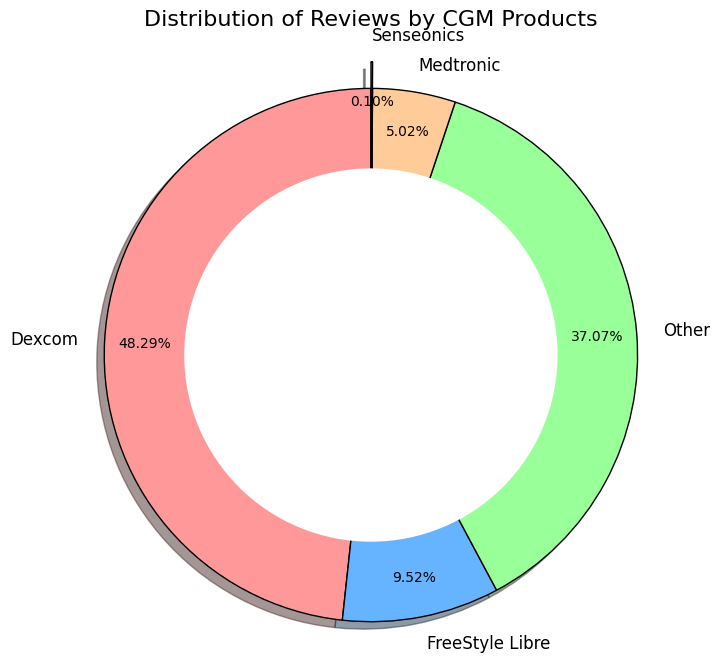

In [ ]:
# visualization
all_product_mentions = [product for sublist in df_cleaned['Product Mentions'] for product in sublist]
product_counts = Counter(all_product_mentions)
labels, counts = zip(*product_counts.items())
plt.figure(figsize=(8, 8))
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#c2c2f0', '#ffb3e6', '#c4e17f']  # Color palette
explode = [0.1 if count == min(counts) else 0 for count in counts]  # Explode the smallest segments
wedges, texts, autotexts = plt.pie(counts, labels=labels, autopct=lambda p: f'{p:.2f}%', startangle=90,
                                   colors=colors, explode=explode, shadow=True, wedgeprops={'edgecolor': 'black'}, pctdistance=0.85)
#readability
for text in texts:
    text.set_fontsize(12)
for autotext in autotexts:
    autotext.set_fontsize(10)
    autotext.set_color('black')

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')
plt.title('Distribution of Reviews by CGM Products', fontsize=16)
plt.show()


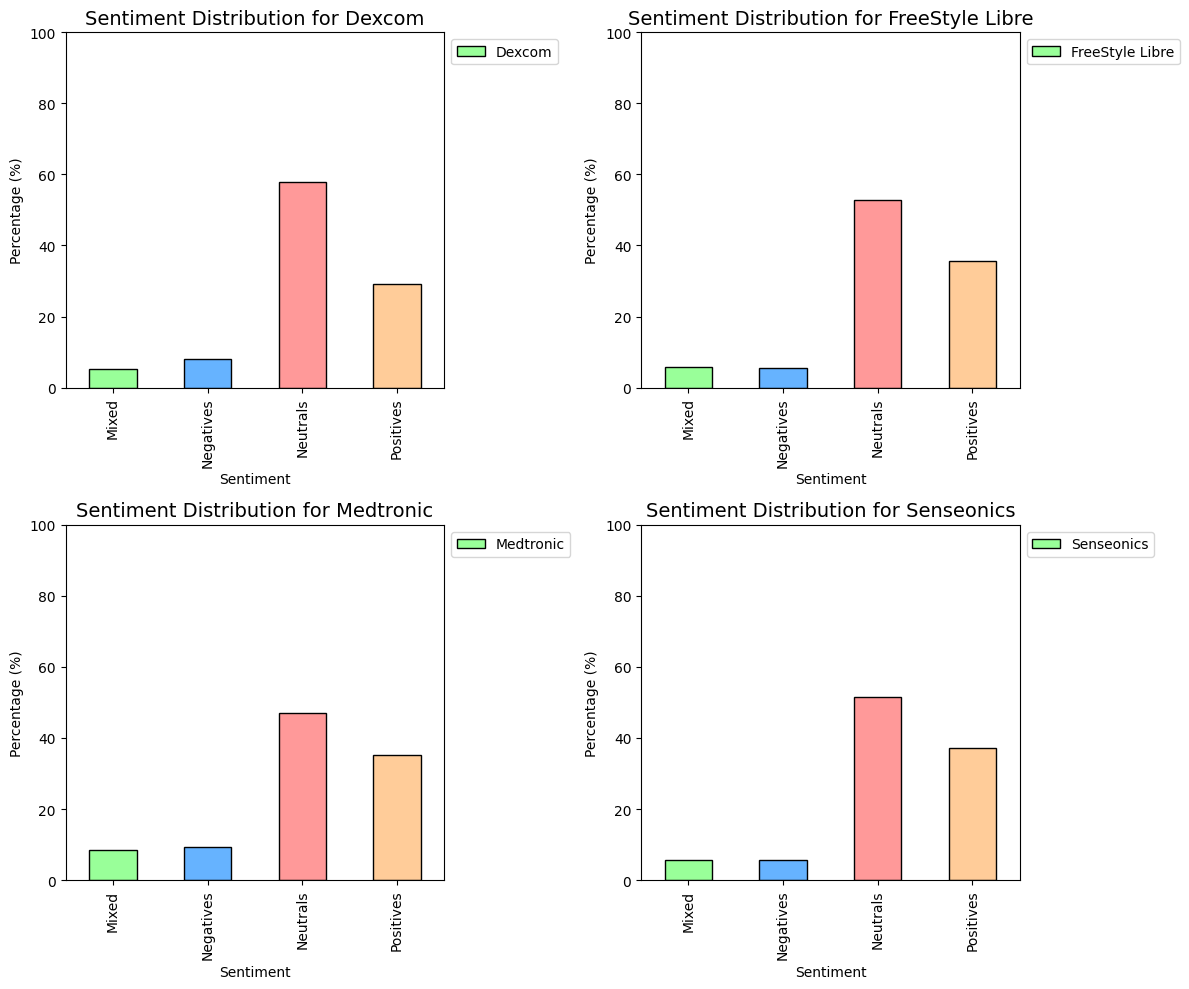

In [ ]:
#positive and negative reviews for each product
df_exploded = df_cleaned.explode('Product Mentions')
sentiment_counts = df_exploded.groupby(['Product Mentions', 'Sentiment']).size().unstack(fill_value=0)

sentiment_percentage = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
products = ['Dexcom', 'FreeStyle Libre', 'Medtronic', 'Senseonics']
colors = ['#99ff99', '#66b3ff', '#ff9999', '#ffcc99']
for i, product in enumerate(products):
    sentiment_percentage.loc[product].plot(kind='bar', stacked=True, ax=axes[i], color=colors, edgecolor='black')
    axes[i].set_title(f'Sentiment Distribution for {product}', fontsize=14)
    axes[i].set_ylabel('Percentage (%)')
    axes[i].set_ylim(0, 100)
    axes[i].legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()
plt.show()

-- furqan: start experiment to get sentiment of summarized posts for each product

In [ ]:
df_exploded = df_cleaned.explode('Product Mentions')

In [ ]:
df_exploded.columns

Index(['Post ID', 'Sound Bite Text', 'Title', 'Source Type', 'Post Type',
       'Media Type', 'URL', 'Media Link', 'Domain', 'Sentiment',
       'Published Date (GMT-04:00) New York', 'Author Gender', 'Author URL',
       'Author Name', 'Author Handle', 'Author ID',
       'Author Location - Country 1', 'Author Location - State/Province 1',
       'Author Location - City 1', 'Author Location - Country 2',
       'Author Location - State/Province 2', 'Author Location - City 2',
       'Author Reddit Karma', 'Followers/Daily Unique Visitors/Subscribers',
       'Professions', 'Interests', 'Positive Objects', 'Negative Objects',
       'Richness', 'Quoted Post', 'Quoted Author Name', 'Quoted Author Handle',
       'Total Engagements', 'Post Comments', 'Post Likes', 'Reddit Score',
       'Rating', 'Source Name', 'Combined Text', 'Is Influencer',
       'Is Non Consumer', 'Stemmed Text', 'Lemmatized Text',
       'Original Combined Text', 'Product Mentions'],
      dtype='object')

In [ ]:
# Group by 'Product Mentions' and concatenate the 'Combined Text' for each product
df_exploaded_merged = df_exploded.groupby('Product Mentions')['Combined Text'].apply(lambda texts: ' '.join(texts)).reset_index()

In [ ]:
from transformers import pipeline

# Load the summarization model from Hugging Face
summarizer = pipeline("summarization")

# Function to summarize text using Hugging Face summarization model
def summarize_text(text, max_length=1024, min_length=30):
    try:
        summary = summarizer(text, max_length=max_length, min_length=min_length, do_sample=False)
        return summary[0]['summary_text']
    except Exception as e:
        return text  # If there's an issue, return the original text

# Function to process job description
def process_combined_text(description):
    # Summarize the job description using the transformers model
    summary = summarize_text(description)

    # Return only the summary
    return summary

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [ ]:
# Apply the summarization function to the 'Description' column
df_exploaded_merged['Summarized Combined Text'] = df_exploaded_merged['Combined Text'].apply(process_combined_text)

Token indices sequence length is longer than the specified maximum sequence length for this model (619081 > 1024). Running this sequence through the model will result in indexing errors


In [ ]:
df_exploaded_merged.head(1)

Product Mentions                                      Combined Text  \
0           Dexcom  numbers great estimated doesnt care say wants ...   

                            Summarized Combined Text  
0  numbers great estimated doesnt care say wants ...

In [ ]:
!pip install vaderSentiment

In [ ]:
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# # Initialize VADER sentiment analyzer
# analyzer = SentimentIntensityAnalyzer()

# # Function to classify the sentiment of the comment
# def classify_sentiment(comment):
#     sentiment_score = analyzer.polarity_scores(comment)
#     compound = sentiment_score['compound']

#     if compound > 0.05:
#         return 'Positive'
#     elif compound < -0.05:
#         return 'Negative'
#     else:
#         return 'Neutral'

# # Apply sentiment analysis to the 'Comment' column
# df_exploaded_merged['Summarized Sentiment'] = df_exploaded_merged['Combined Text'].apply(classify_sentiment)


-- end experiment

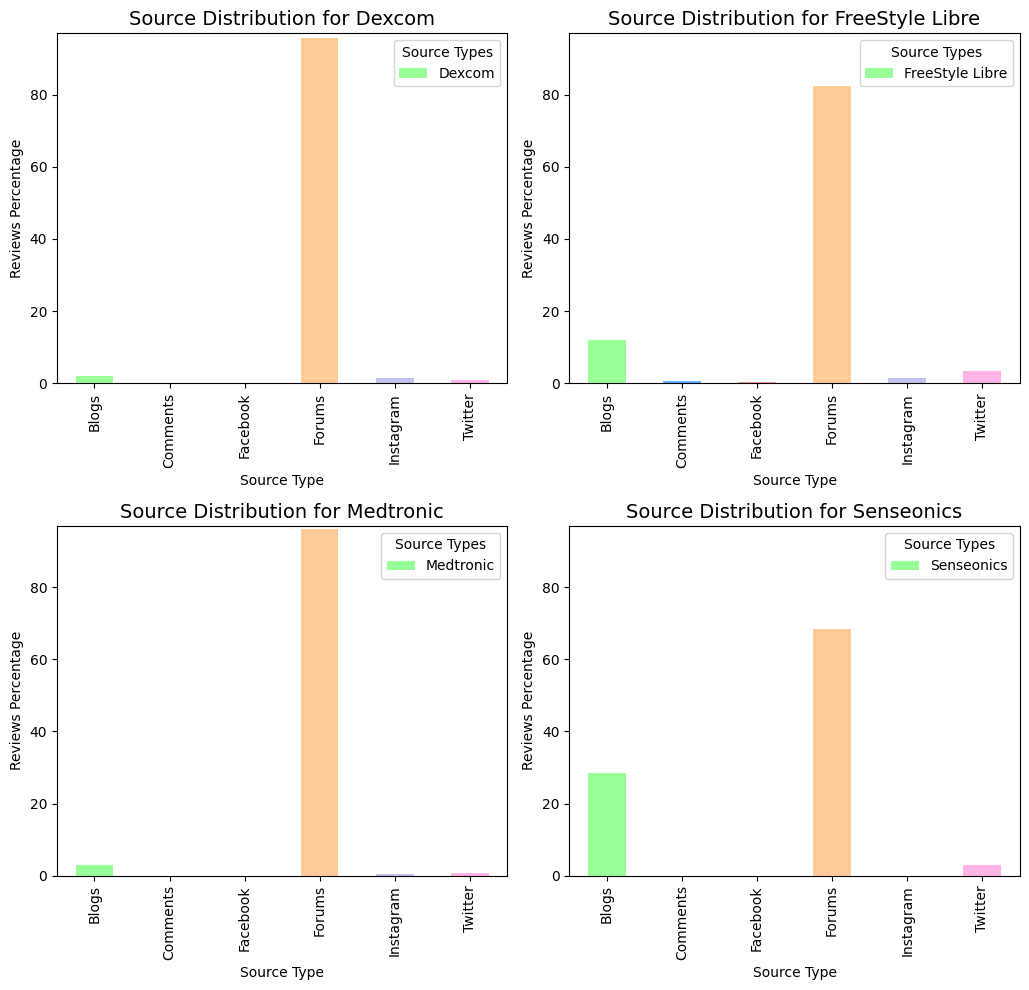

In [ ]:
#review sources for each products
df_exploded = df_cleaned.explode('Product Mentions')
source_counts = df_exploded.groupby(['Product Mentions', 'Source Type']).size().unstack(fill_value=0)
source_percentage = source_counts.div(source_counts.sum(axis=1), axis=0) * 100
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
products = ['Dexcom', 'FreeStyle Libre', 'Medtronic', 'Senseonics']
for i, product in enumerate(products):
    source_percentage.loc[product].plot(kind='bar', stacked=True, ax=axes[i], color=['#99ff99', '#66b3ff', '#ff9999', '#ffcc99', '#c2c2f0', '#ffb3e6'])
    axes[i].set_title(f'Source Distribution for {product}', fontsize=14)
    axes[i].set_ylabel('Reviews Percentage')
    axes[i].set_ylim(0, source_percentage.max().max() + 1)
    axes[i].legend(title='Source Types', bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()
plt.show()

For the information for different CGM products mentioned in the reviews. Our analysis reveals that the majority of reviews focus on Dexcom, followed by FreeStyle Libre, with significantly fewer reviews for Senseonics and Medtronic. This suggests that Dexcom enjoys substantial popularity on social media, potentially due to effective promotional strategies or a larger market share.

When examining review sentiments across different products, each product have a similar review sentiments distributions. Senseonics's most reviews are positive/neutral, but the number of reviews for this product is too small to have a solid conclusion.

Regarding review sources, all products receive a substantial percentage of reviews from forums or blog, which are generally considered more formal compared to platforms like Instagram and Twitter.

### **2. Topic Analysis for CGM products**

In [ ]:
df_cleaned.head()

Post ID                                    Sound Bite Text  \
0   BRDRDT2-t1_imq98sr  My numbers are great now. Estimated a1c of 7%i...   
1   BRDRDT2-t1_impbcf4  I tried it for a little while. No side effects...   
2  1565738759353602048  i ran out of characters. youtu.be/RWgl2PDhQiM ...   
3    17944607459251789  MY lunch! Ate at 10:30am \n1 unit NovoLog insu...   
5    17875966583693003  I’d like a new pancreas please ✌?? \n\n#type1d...   

                                               Title Source Type  \
0  Have you been denied a second/third pump? Feel...      Forums   
1                                          Metformin      Forums   
2                                                NaN     Twitter   
3                                                NaN   Instagram   
5                                                NaN   Instagram   

              Post Type Media Type  \
0  Replies and Comments   No Media   
1  Replies and Comments   No Media   
2  Replies and Comments       Link   
3              Original      Image   
5              Original   No Media   

                                                 URL  \
0  https://www.reddit.com/r/diabetes_t1/comments/...   
1  https://www.reddit.com/r/diabetes_t1/comments/...   
2  http://twitter.com/bromid/statuses/15657387593...   
3           https://www.instagram.com/p/Ch-gqL-Onqk/   
5        https://www.instagram.com/reel/Ch959C7OoP3/   

                                          Media Link         Domain  \
0                                                NaN     reddit.com   
1                                                NaN     reddit.com   
2                                                NaN    twitter.com   
3  https://scontent-iad3-1.cdninstagram.com/v/t51...  instagram.com   
5                                                NaN  instagram.com   

   Sentiment  ... Reddit Score Rating    Source Name  \
0   Neutrals  ...            0    NaN  r/diabetes_t1   
1  Positives  ...            0    NaN  r/diabetes_t1   
2  Positives  ...            -    NaN            NaN   
3   Neutrals  ...            -    NaN            NaN   
5   Neutrals  ...            -    NaN            NaN   

                                       Combined Text Is Influencer  \
0  numbers great estimated doesnt care say wants ...         False   
1  tried little side effects help resistance foun...         False   
2  ran characters ill also say newly diagnosed id...         False   
3  lunch ate unit novolog via grilled chicken fet...         False   
5  id new pancreas please dexcomwarrior diabetics...         False   

  Is Non Consumer                                       Stemmed Text  \
0           False  [number, great, estim, doesnt, care, say, want...   
1           False  [tri, littl, side, effect, help, resist, found...   
2           False  [ran, charact, ill, also, say, newli, diagnos,...   
3           False  [lunch, ate, unit, novolog, via, grill, chicke...   
5           False  [id, new, pancrea, pleas, dexcomwarrior, diabe...   

                                     Lemmatized Text  \
0  [number, great, estimated, doesnt, care, say, ...   
1  [tried, little, side, effect, help, resistance...   
2  [ran, character, ill, also, say, newly, diagno...   
3  [lunch, ate, unit, novolog, via, grilled, chic...   
5  [id, new, pancreas, please, dexcomwarrior, dia...   

                              Original Combined Text Product Mentions  
0  My numbers are great now. Estimated a1c of 7%i...         [Dexcom]  
1  I tried it for a little while. No side effects...         [Dexcom]  
2  i ran out of characters. youtu.be/RWgl2PDhQiM ...         [Dexcom]  
3  MY lunch! Ate at 10:30am \n1 unit NovoLog insu...         [Dexcom]  
5  I’d like a new pancreas please ✌?? \n\n#type1d...         [Dexcom]  

[5 rows x 45 columns]

In [ ]:
# Use LDA mode to do topic analysis
#For Dexcom
df_dex = df_cleaned[df_cleaned['Product Mentions'].apply(lambda x: 'Dexcom' in x)]
dictionary = corpora.Dictionary(df_dex['Lemmatized Text'])
corpus = [dictionary.doc2bow(text) for text in df_dex['Lemmatized Text']]
# Train LDA Model
num_topics = 10
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)
topics = lda_model.print_topics(num_words=5)
topics_df = pd.DataFrame(topics, columns=['Topic', 'Words'])
print("Topics:")
print(topics_df)



Topics:
   Topic                                              Words
0      0  0.034*"arm" + 0.024*"site" + 0.022*"use" + 0.0...
1      1  0.053*"app" + 0.050*"phone" + 0.028*"watch" + ...
2      2  0.026*"low" + 0.020*"sugar" + 0.015*"time" + 0...
3      3  0.015*"dont" + 0.014*"one" + 0.013*"would" + 0...
4      4  0.060*"sensor" + 0.037*"day" + 0.027*"ive" + 0...
5      5  0.013*"data" + 0.010*"mgdl" + 0.009*"hypoglyce...
6      6  0.061*"insurance" + 0.031*"diabetes" + 0.022*"...
7      7  0.034*"year" + 0.017*"got" + 0.013*"ive" + 0.0...
8      8  0.055*"tandem" + 0.053*"medtronic" + 0.042*"ts...
9      9  0.029*"finger" + 0.024*"sensor" + 0.018*"frees...


In [ ]:
# Determine Most Important Topic
def get_most_important_topic(product_corpus):
    topic_distribution = lda_model.get_document_topics(product_corpus)

    topic_counts = {}
    for doc_topics in topic_distribution:
        for topic, prob in doc_topics:
            if topic in topic_counts:
                topic_counts[topic] += prob
            else:
                topic_counts[topic] = prob

    most_important_topic = max(topic_counts, key=topic_counts.get)
    return most_important_topic

top_topic_dexcom = get_most_important_topic(corpus)
print(f"Most Important Topic for Dexcom is: {topics_df.Words[top_topic_dexcom]}")

Most Important Topic for Dexcom is: 0.026*"low" + 0.020*"sugar" + 0.015*"time" + 0.013*"high" + 0.009*"day"


In [ ]:
#For FreeStyle Libre
df_fre = df_cleaned[df_cleaned['Product Mentions'].apply(lambda x: 'FreeStyle Libre' in x)]
dictionary = corpora.Dictionary(df_fre['Lemmatized Text'])
corpus = [dictionary.doc2bow(text) for text in df_fre['Lemmatized Text']]
# Train LDA Model
num_topics = 10
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)
topics = lda_model.print_topics(num_words=5)
topics_df = pd.DataFrame(topics, columns=['Topic', 'Words'])
print("Topics:")
print(topics_df)


Topics:
   Topic                                              Words
0      0  0.019*"miao" + 0.016*"freestyle" + 0.007*"sams...
1      1  0.009*"metabolic" + 0.007*"people" + 0.006*"st...
2      2  0.027*"freestyle" + 0.020*"app" + 0.017*"syste...
3      3  0.018*"level" + 0.017*"sensor" + 0.017*"monito...
4      4  0.009*"de" + 0.005*"tho" + 0.004*"native" + 0....
5      5  0.049*"freestyle" + 0.040*"sensor" + 0.013*"da...
6      6  0.030*"freestyle" + 0.014*"sugar" + 0.010*"ive...
7      7  0.038*"insurance" + 0.024*"freestyle" + 0.017*...
8      8  0.043*"back" + 0.033*"brace" + 0.025*"knee" + ...
9      9  0.021*"freestyle" + 0.011*"sensor" + 0.009*"ad...


In [ ]:
top_topic_FreeStyle = get_most_important_topic(corpus)
print(f"Most Important Topic for FreeStyle Libre is: {topics_df.Words[top_topic_FreeStyle]}")

Most Important Topic for FreeStyle Libre is: 0.030*"freestyle" + 0.014*"sugar" + 0.010*"ive" + 0.009*"time" + 0.009*"day"


In [ ]:
#For 'Medtronic'
df_med = df_cleaned[df_cleaned['Product Mentions'].apply(lambda x: 'Medtronic' in x)]
dictionary = corpora.Dictionary(df_med['Lemmatized Text'])
corpus = [dictionary.doc2bow(text) for text in df_med['Lemmatized Text']]
# Train LDA Model
num_topics = 5
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)
topics = lda_model.print_topics(num_words=5)
topics_df = pd.DataFrame(topics, columns=['Topic', 'Words'])
print("Topics:")
print(topics_df)

Topics:
   Topic                                              Words
0      0  0.021*"medtronic" + 0.013*"sensor" + 0.009*"ph...
1      1  0.016*"device" + 0.015*"diabetes" + 0.010*"sys...
2      2  0.018*"sensor" + 0.012*"medtronic" + 0.012*"su...
3      3  0.040*"medtronic" + 0.014*"year" + 0.012*"tand...
4      4  0.013*"medtronic" + 0.011*"sensor" + 0.007*"pe...


In [ ]:
top_topic_med = get_most_important_topic(corpus)
print(f"Most Important Topic for Medtronic is: {topics_df.Words[top_topic_med]}")

Most Important Topic for Medtronic is: 0.040*"medtronic" + 0.014*"year" + 0.012*"tandem" + 0.012*"sensor" + 0.010*"ive"


In [ ]:
#For ''Senseonics''
df_sen = df_cleaned[df_cleaned['Product Mentions'].apply(lambda x: 'Senseonics' in x)]
dictionary = corpora.Dictionary(df_sen['Lemmatized Text'])
corpus = [dictionary.doc2bow(text) for text in df_sen['Lemmatized Text']]
# Train LDA Model
num_topics = 5
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)
topics = lda_model.print_topics(num_words=5)
topics_df = pd.DataFrame(topics, columns=['Topic', 'Words'])
print("Topics:")
print(topics_df)

Topics:
   Topic                                              Words
0      0  0.018*"diabetes" + 0.012*"people" + 0.010*"dev...
1      1  0.022*"senseonics" + 0.009*"diabetes" + 0.009*...
2      2  0.035*"sugar" + 0.020*"meal" + 0.016*"test" + ...
3      3  0.020*"system" + 0.017*"senseonics" + 0.014*"s...
4      4  0.028*"sugar" + 0.012*"diabetes" + 0.008*"leve...


In [ ]:
top_topic_sen = get_most_important_topic(corpus)
print(f"Most Important Topic for Senseonics is: {topics_df.Words[top_topic_sen]}")

Most Important Topic for Senseonics is: 0.022*"senseonics" + 0.009*"diabetes" + 0.009*"sen" + 0.007*"eversense" + 0.007*"implant"


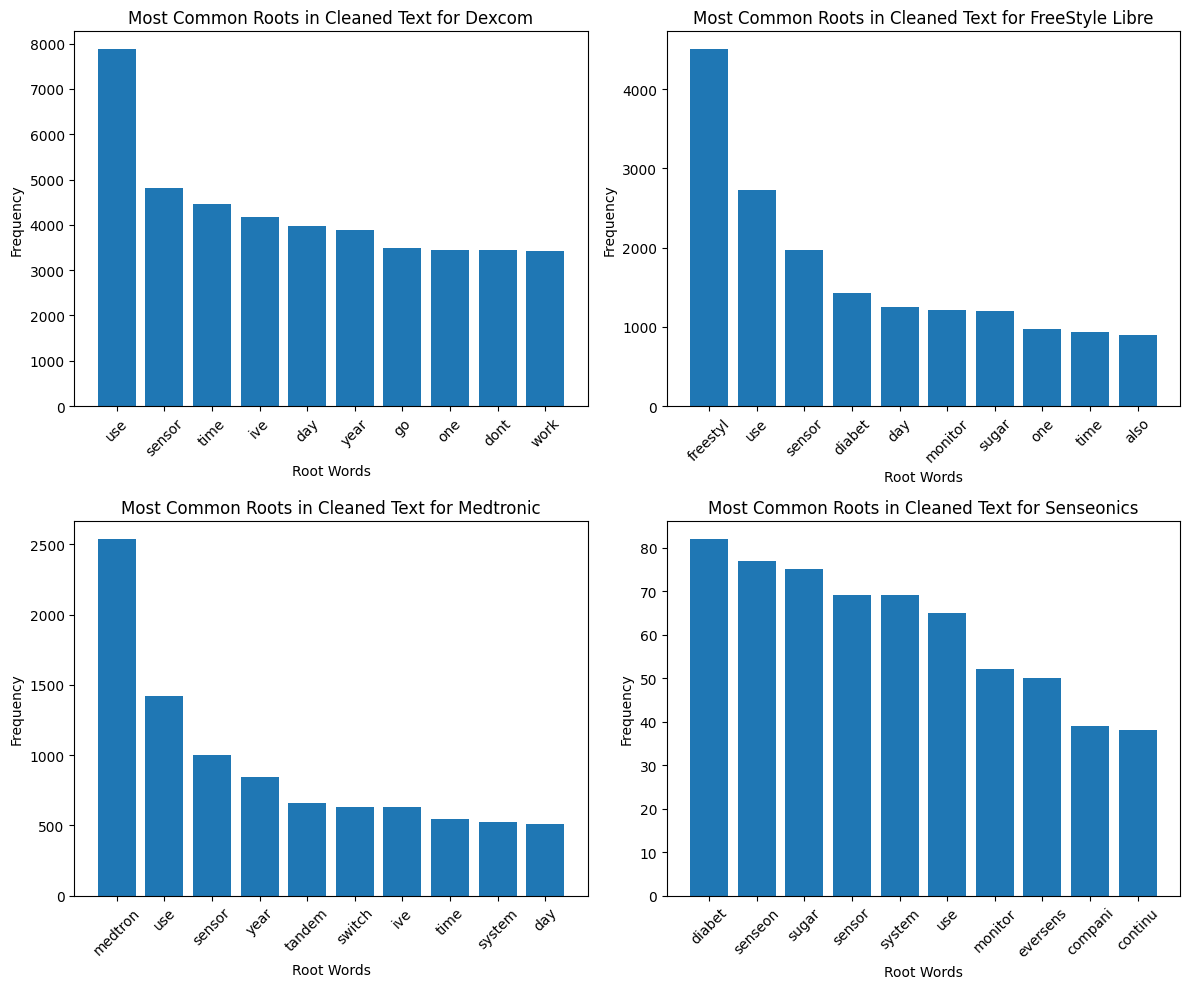

In [ ]:
#apart from that we could also take a loot at the most common words mentioned for each products
product_list = ['Dexcom', 'FreeStyle Libre', 'Medtronic', 'Senseonics']
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
for i, product in enumerate(product_list):
    cleaned_words_stemmed = [stem for stems_list in df_cleaned[df_cleaned['Product Mentions'].apply(lambda x: product in x)]['Stemmed Text'] for stem in stems_list]


    # Use Counter to count the frequency of each root
    word_freq = Counter(cleaned_words_stemmed)

    # Get the most common roots
    most_common_roots = word_freq.most_common(10)

    # Extract the roots and their frequencies for plotting
    roots, frequencies = zip(*most_common_roots)

    # Create a bar plot
    axes[i].bar(roots, frequencies)
    axes[i].set_xlabel('Root Words')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Most Common Roots in Cleaned Text for {product}')
    axes[i].tick_params(axis='x',rotation=45)
plt.tight_layout()
# Show the plot
plt.show()

To analyze the most important attributes for each product, we employed two methods: topic analysis using the LDA model and counting the most frequent roots in product reviews.

**Dexcom**: The analysis revealed that key attributes include the performance of the sensor, integration with insulin pump devices, and the Dexcom G6 model. Many reviews reflect user experiences, which is also an important concern for this product.

**FreeStyle Libre**: Important attributes highlighted in reviews are product features, particularly the sensor and app, as well as usability in glucose monitoring.

**Medtronic**: Key attributes for Medtronic include product functionality, specifically the insulin pump and CGM features, user experiences in managing diabetes, and comparisons with competitor products like Tandem.

**Senseonics**: The focus for Senseonics is on core functionality in continuous glucose monitoring (CGM), health indicators such as blood sugar levels, and dietary considerations.

### **3. Attribute Analysis**

we find that for this dataset, the most requent roots actually give us a very good overview of mentioned attributes, in the following attribute analysis, we will continue with this method. After having some whole pictures about attributes for these products, we could pre-defined different attributes and analyze based on these attributes.

In [ ]:
stemmer = PorterStemmer()

attributes_map = {
    'performance': ['performance', 'reliable', 'accurate', 'fast', 'efficiency', 'consistency', 'work', 'well','blood','sugar','diabet'],
    'usability': ['easy', 'user','friendly', 'simple', 'intuitive', 'convenient', 'accessible','use'],
    'features': ['sense','system','pump','sensor', 'app', 'integration', 'battery', 'life', 'display', 'alerts', 'connectivity', 'data', 'sharing', 'real'],
    'support': ['customer support', 'service', 'help', 'technical', 'support', 'assistance', 'response'],
    'competitors': ['dexcom','medtronic', 'senseonics', 'tandem', 'g6','freestyle','libre','2','freestyl','libr'],
    'price': ['affordable', 'expensive', 'cost', 'price', 'value',  'money', 'cheap', 'worth'],
    'accuracy': ['accuracy', 'precise', 'reliable', 'readings', 'correctness'],
    'quality': ['durability', 'build','quality', 'materials', 'design', 'sturdiness','year','time'],
    'side effects': ['side', 'effects', 'reaction', 'issue', 'problem', 'complications'],
    'availability': ['availability', 'stock', 'purchase', 'buy', 'order', 'shipping'],
    'compatibility': ['compatible', 'works', 'with', 'integration', 'connect', 'to'],
}
#stemed the word first so that it could better match the original stemmed text column
stemmed_attributes = {key: [stemmer.stem(word) for word in keywords] for key, keywords in attributes_map.items()}

def detect_attributes(stemmed_text_list):
    detected_counts = {key: 0 for key in stemmed_attributes.keys()}
    for key, keywords in stemmed_attributes.items():
        if any(stemmed_word in keywords for stemmed_word in stemmed_text_list):  # Direct match with stemmed word
            detected_counts[key] += 1

    return detected_counts


attribute_counts = df_cleaned['Stemmed Text'].apply(detect_attributes)
attributes_df = pd.DataFrame(attribute_counts.tolist(), index=df_cleaned.index)
df_combined = pd.concat([df_cleaned, attributes_df], axis=1)
df_combined.head()

Post ID                                    Sound Bite Text  \
0   BRDRDT2-t1_imq98sr  My numbers are great now. Estimated a1c of 7%i...   
1   BRDRDT2-t1_impbcf4  I tried it for a little while. No side effects...   
2  1565738759353602048  i ran out of characters. youtu.be/RWgl2PDhQiM ...   
3    17944607459251789  MY lunch! Ate at 10:30am \n1 unit NovoLog insu...   
5    17875966583693003  I’d like a new pancreas please ✌?? \n\n#type1d...   

                                               Title Source Type  \
0  Have you been denied a second/third pump? Feel...      Forums   
1                                          Metformin      Forums   
2                                                NaN     Twitter   
3                                                NaN   Instagram   
5                                                NaN   Instagram   

              Post Type Media Type  \
0  Replies and Comments   No Media   
1  Replies and Comments   No Media   
2  Replies and Comments       Link   
3              Original      Image   
5              Original   No Media   

                                                 URL  \
0  https://www.reddit.com/r/diabetes_t1/comments/...   
1  https://www.reddit.com/r/diabetes_t1/comments/...   
2  http://twitter.com/bromid/statuses/15657387593...   
3           https://www.instagram.com/p/Ch-gqL-Onqk/   
5        https://www.instagram.com/reel/Ch959C7OoP3/   

                                          Media Link         Domain  \
0                                                NaN     reddit.com   
1                                                NaN     reddit.com   
2                                                NaN    twitter.com   
3  https://scontent-iad3-1.cdninstagram.com/v/t51...  instagram.com   
5                                                NaN  instagram.com   

   Sentiment  ... usability features support competitors price accuracy  \
0   Neutrals  ...         0        0       0           0     0        0   
1  Positives  ...         0        0       1           0     0        0   
2  Positives  ...         1        1       0           0     0        0   
3   Neutrals  ...         1        1       0           0     0        0   
5   Neutrals  ...         0        0       0           0     0        0   

  quality side effects availability compatibility  
0       0            0            0             0  
1       0            1            0             0  
2       0            0            0             0  
3       0            0            0             0  
5       0            0            0             0  

[5 rows x 56 columns]

If the attribute have more positive sentiment reviews share than negative sentiment reviews share, we tend to think that this attribute is liked more, vice versa.

**Our analysis considers two dimensions:**

1. The proportion of positive/negative reviews for each attribute relative to the total positive/negative reviews. This highlights which attributes are most frequently mentioned in positive or negative feedback.

2. The count of positive/negative reviews for each attribute across all products. This reveals how many positive or negative reviews are associated with each attribute.

The first dimension shows what people commonly discuss when leaving positive or negative reviews, while the second dimension focuses on how many positive/negative reviews are linked to each attribute.

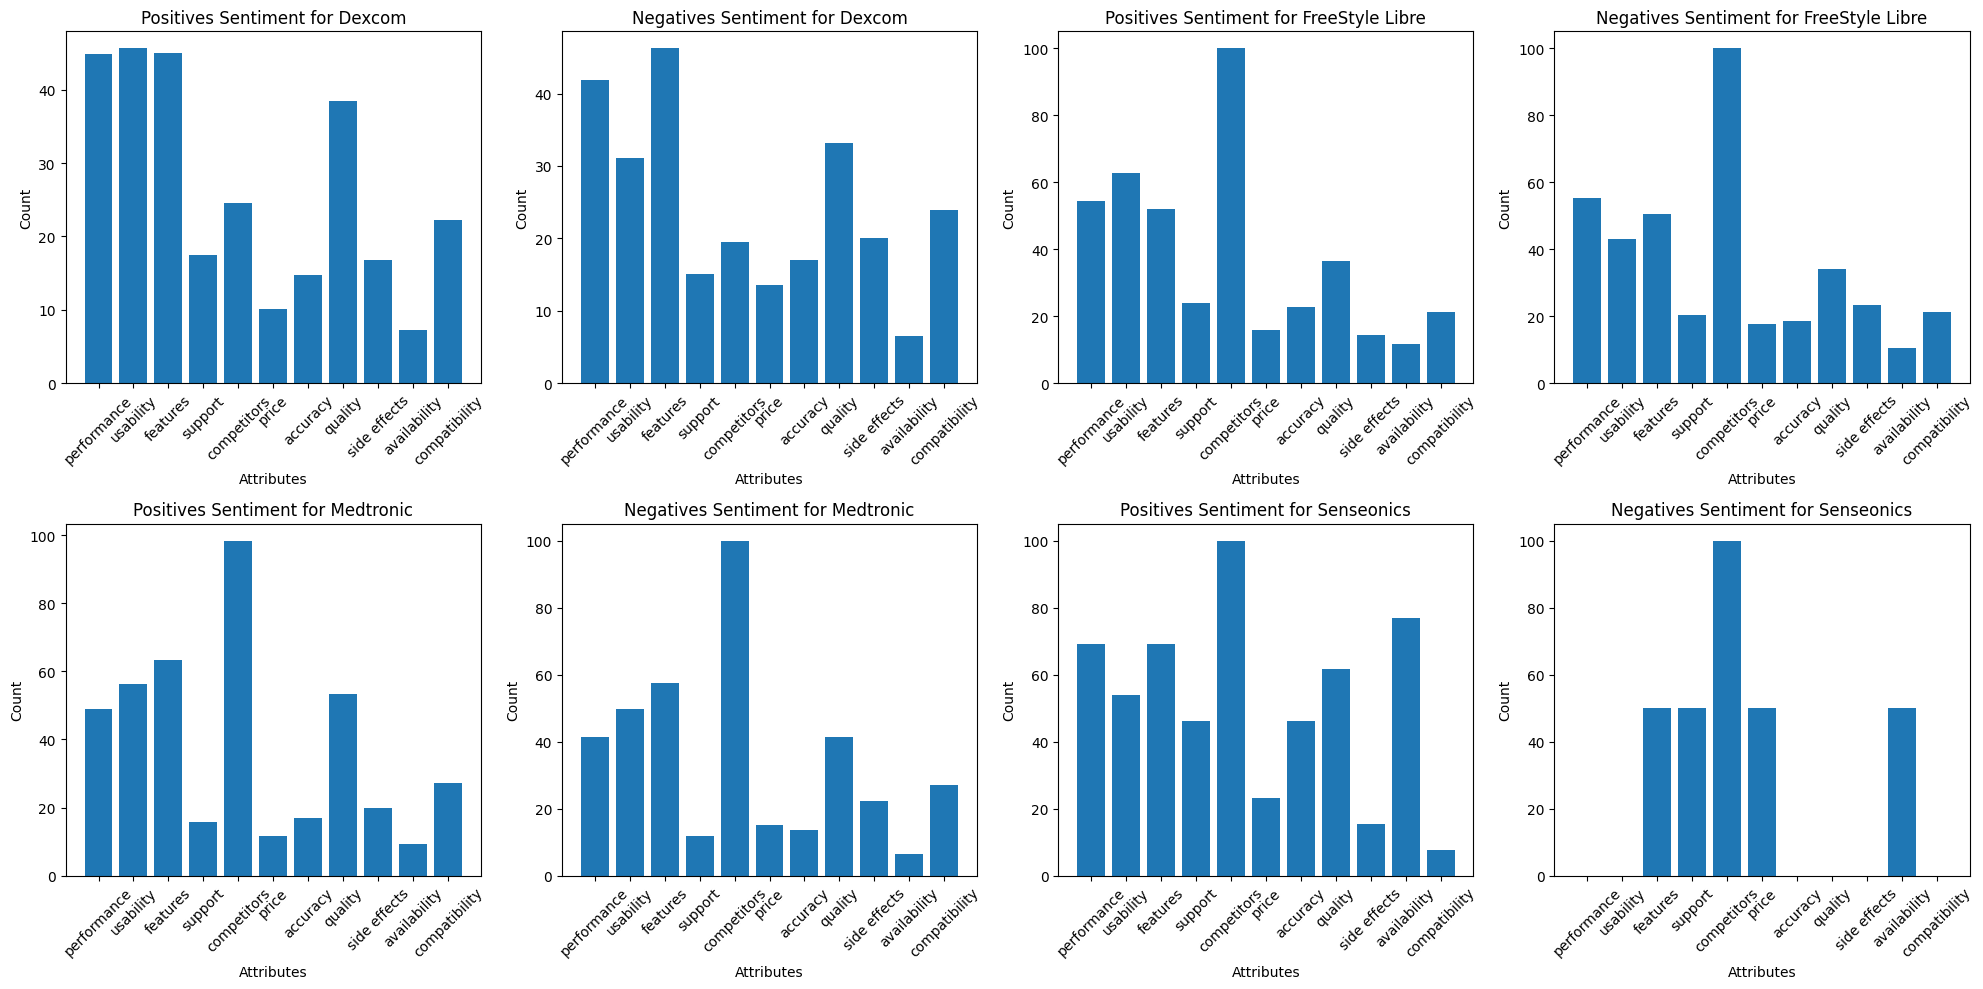

In [ ]:
# Define the product list and sentiment labels
product_list = ['Dexcom', 'FreeStyle Libre', 'Medtronic', 'Senseonics']
sentiment_labels = ['Positives', 'Negatives']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # 2 rows for sentiment, 4 columns for products
axes = axes.flatten()

for i, product in enumerate(product_list):
    for j, sentiment in enumerate(sentiment_labels):
        filtered_data = df_combined[(df_combined['Product Mentions'].apply(lambda x: product in x)) &(df_combined['Sentiment'] == sentiment)]
        # Sum the attribute columns
        attribute_counts = filtered_data[attributes_map.keys()].sum()
        total_reviews = len(filtered_data)
        attribute_counts = (attribute_counts / total_reviews) * 100
        attributes, counts = attribute_counts.index, attribute_counts.values
        axes[i * 2 + j].bar(attributes, counts)
        axes[i * 2 + j].set_xlabel('Attributes')
        axes[i * 2 + j].set_ylabel('Count')
        axes[i * 2 + j].set_title(f'{sentiment} Sentiment for {product}')
        axes[i * 2 + j].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


For both positive and negative reviews, the distribution of customer feedback across key product attributes is similar. However, examining the differences between positive and negative reviews reveals the following insights:

**Dexcom**: Customers show more positive sentiment toward usability and quality, while price attracts more negative feedback. Both positive and negative reviews are evenly distributed across features and performance.

**FreeStyle Libre**: Usability and accuracy receive more positive reviews, but price is mentioned more frequently in negative reviews.

**Medtronic**: Performance, usability, accuracy, and availability have more positive feedback, while features and price receive relatively more negative reviews.

**Senseonics**: Although there are fewer reviews for this product, performance is the most praised attribute, while price tends to receive more negative feedback.

### **4. Focussed Attributes**

In [ ]:
# Focus attributes for this part
focus_attributes = ['price', 'performance', 'accuracy', 'quality']
product_list = ['Dexcom', 'FreeStyle Libre', 'Medtronic', 'Senseonics']
sentiment_labels = ['Positives', 'Negatives']

# Initialize an empty DataFrame to store the results for each attribute and sentiment
results = pd.DataFrame(columns=['Product', 'Attribute', 'Positive Count', 'Negative Count'])

# Loop over each product and focus attribute
for product in product_list:
    for attribute in focus_attributes:
        # Filter rows for the specific product
        product_df = df_combined[df_combined['Product Mentions'].apply(lambda x: product in x)]

        # Calculate positive and negative counts for the attribute
        positive_count = product_df[(product_df['Sentiment'] == 'Positives')][attribute].sum()
        negative_count = product_df[(product_df['Sentiment'] == 'Negatives')][attribute].sum()

        # Create a DataFrame for the current row
        new_row = pd.DataFrame({
            'Product': [product],
            'Attribute': [attribute],
            'Positive Count': [positive_count],
            'Negative Count': [negative_count]
        })

        # Concatenate the new row to the results DataFrame
        results = pd.concat([results, new_row], ignore_index=True)

# Display the results
print(results)

            Product    Attribute Positive Count Negative Count
0            Dexcom        price            507            189
1            Dexcom  performance           2258            580
2            Dexcom     accuracy            740            236
3            Dexcom      quality           1935            461
4   FreeStyle Libre        price            193             33
5   FreeStyle Libre  performance            663            104
6   FreeStyle Libre     accuracy            279             35
7   FreeStyle Libre      quality            444             64
8         Medtronic        price             74             25
9         Medtronic  performance            311             69
10        Medtronic     accuracy            107             23
11        Medtronic      quality            340             69
12       Senseonics        price              3              1
13       Senseonics  performance              9              0
14       Senseonics     accuracy              6        

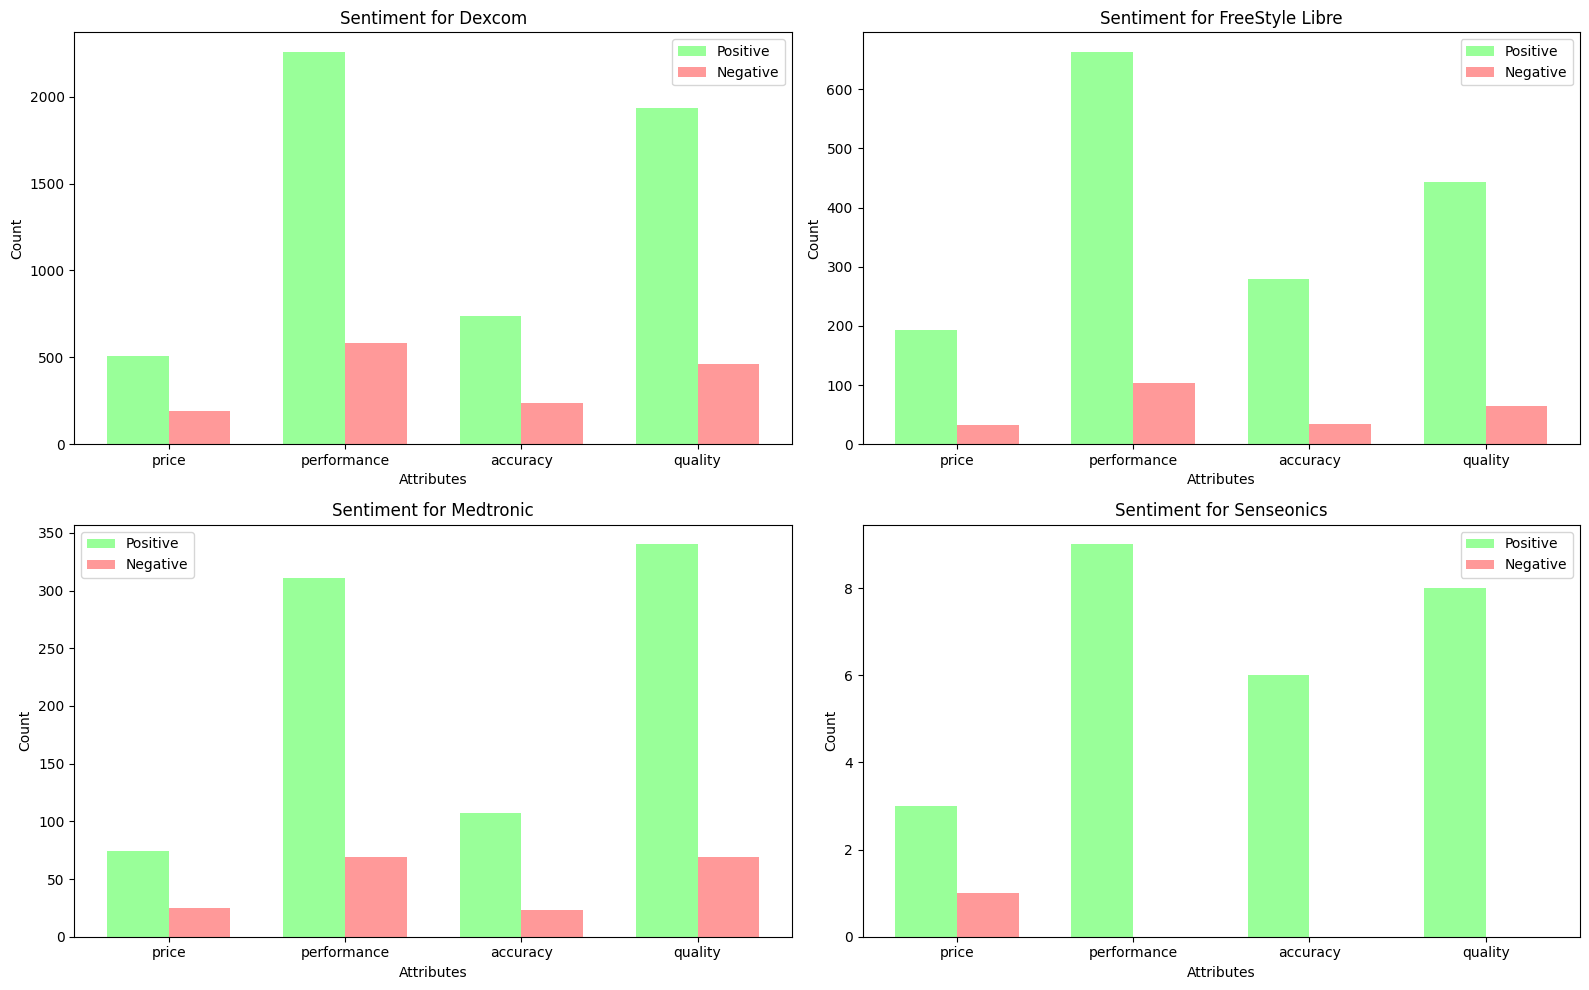

In [ ]:
# Visualize the counts for each product and attribute
fig, axes = plt.subplots(2, 2, figsize=(16, 10))  # 2 rows and 2 columns for products
axes = axes.flatten()

# Plot for each product
for i, product in enumerate(product_list):
    product_data = results[results['Product'] == product]

    # Plot Positive and Negative Counts side by side for each attribute
    bar_width = 0.35
    index = range(len(focus_attributes))

    pos_counts = product_data['Positive Count']
    neg_counts = product_data['Negative Count']
    colors = ['#99ff99', '#ff9999']
    # Plot bars
    axes[i].bar(index, pos_counts, bar_width, label='Positive', color=colors[0])
    axes[i].bar([x + bar_width for x in index], neg_counts, bar_width, label='Negative', color=colors[1])

    # Set chart details
    axes[i].set_xlabel('Attributes')
    axes[i].set_ylabel('Count')
    axes[i].set_title(f'Sentiment for {product}')
    axes[i].set_xticks([x + bar_width / 2 for x in index])
    axes[i].set_xticklabels(focus_attributes)
    axes[i].legend()

plt.tight_layout()
plt.show()

Overall, as shown in the charts above, customers tend to leave more positive reviews than negative ones across these attributes. From our earlier analysis, we observe that performance is the most praised attribute for Senseonics, while accuracy stands out in positive reviews for both FreeStyle Libre and Medtronic. On the other hand, price is a major factor in negative reviews across all products, and quality does not show a significant difference in sentiment.

### **5. Different Dataset for Analytics Task**

We have talked about that **'Quoted Post'** column provides additional context for **Original** posts when the source is **Twitter**, which serves as additional information when we do analysis.

So firstly, we processed Twitter text by adding quoted post.

In [ ]:
twitter_reviews = df_cleaned[df_cleaned['Source Type'] == 'Twitter'].sample(5)
for index, row in twitter_reviews.iterrows():
    review = row['Original Combined Text']
    stemmed_text = row['Stemmed Text']
    print(f"Some Sound Bite Text and Quoted Post for Twitter reviews: {review}")
    print(f"Some Stemmed reviews: {stemmed_text}")


Some Sound Bite Text and Quoted Post for Twitter reviews: Excited to try my first Freestyle Libre 2 wearable sensor. I hope this helps me manage my diabetes much better!
Some Stemmed reviews: ['excit', 'tri', 'first', 'freestyl', 'wearabl', 'sensor', 'hope', 'help', 'manag', 'diabet', 'much', 'better']
Some Sound Bite Text and Quoted Post for Twitter reviews: Occasionally I find myself wallowing in my mortality, but t1 diabetics are living to 90 now, and the tech to keep us alive continues get better (and after struggling a few years, getting my continous glucose monitor got me solidly back in healthy a1c zone) cbsnews.com/pictures/world…
Some Stemmed reviews: ['occasion', 'find', 'wallow', 'mortal', 'diabet', 'live', 'tech', 'keep', 'us', 'aliv', 'continu', 'better', 'struggl', 'year', 'get', 'contin', 'monitor', 'got', 'solidli', 'back', 'healthi', 'zone', 'cbsnewscompicturesworld']
Some Sound Bite Text and Quoted Post for Twitter reviews: @loffredojeremy LOLZ, All I have to do is go

In [ ]:
nontwitter_reviews = df_cleaned[df_cleaned['Source Type'] != 'Twitter'].sample(5)
for index, row in nontwitter_reviews.iterrows():
    review = row['Original Combined Text']
    stemmed_text = row['Stemmed Text']
    print(f"Some Sound Bite Text and Quoted Post for Non-Twitter reviews: {review}")
    print(f"Some Stemmed reviews: {stemmed_text}")


Some Sound Bite Text and Quoted Post for Non-Twitter reviews: I’m on the tandem tslim and Dexcom G6. The lows usually coincide with my cycle but it’s unpredictable due to endometriosis and nobody will give me a hysterectomy because of my age. But when the lows are really low they’re dangerous no matter when they come.
Some Stemmed reviews: ['tandem', 'tslim', 'low', 'usual', 'coincid', 'cycl', 'unpredict', 'due', 'endometriosi', 'nobodi', 'give', 'hysterectomi', 'age', 'low', 'realli', 'low', 'theyr', 'danger', 'matter', 'come']
Some Sound Bite Text and Quoted Post for Non-Twitter reviews: I tried a pump and it wasn’t for me since I play contact sports a lot and run a lot. I don’t really have enough body fat just yet to make a seamless transition. Therefore the only thing I wear is the Dexcom and take injections. My A1C is usually around 5.0 - 5.5 so I think I’m ok for right now in my life.
Some Stemmed reviews: ['tri', 'wasnt', 'sinc', 'play', 'contact', 'sport', 'lot', 'run', 'lot', 

In case of the accuracy of analysis, since we don't have a ground truth for the attribute analysis, we can hardly recognize which datasets will be more accurate for these tasks. But throughs some samples of the datasets, we do have some insights about the ease of processing, and possible accuracy for both datasets:

**Twitter Dataset**
- Twitter Dataset are generally shorter and may contain less context, which can make it easier to process them quickly.
- Tweets often include metadata such as hashtags, mentions, and links, besides, tweets often use informal language like emojis, which can pose challenges for NLP

**Non-Twitter Dataset**

- Non-Twitter reviews typically contain more context, making it easier to extract insights and sentiments.
- Non-Twitter datasets might be more structured and often use more formal and coherent language

**Conclusion**

Overall, I would think non-Twitter dataset may provide better accuracy due to its structured format and more comprehensive reviews, since our goal is to extract insights about customer sentiments and product attributes

### **6. Sentiment of each product with respect to sentiment column**


In [ ]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.2 MB/s eta 0:00:00


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

analyzer = SentimentIntensityAnalyzer()

#function to classify sentiment
def get_vader_sentiment(text):
    score = analyzer.polarity_scores(text)
    if score['compound'] >= 0.05:
        return 'Positive'
    elif score['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df_cleaned['Predicted Sentiment'] = df_cleaned['Combined Text'].apply(get_vader_sentiment)

#Compare the predicted sentiment with existing sentiment
conf_matrix = confusion_matrix(df_cleaned['Sentiment'], df_cleaned['Predicted Sentiment'], labels=['Positive', 'Negative', 'Neutral', 'Mixed'])
print("Confusion Matrix:\n", conf_matrix)




Confusion Matrix:
 [[  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]
 [744 328  47   0]]


In [ ]:
df_cleaned['Predicted Sentiment Without Icon'] = df_cleaned['Combined Text Without Icon'].apply(get_vader_sentiment)

#Compare the predicted sentiment with existing sentiment
conf_matrix_wthicon = confusion_matrix(df_cleaned['Sentiment'], df_cleaned['Predicted Sentiment Without Icon'], labels=['Positive', 'Negative', 'Neutral', 'Mixed'])
print("Confusion Matrix:\n", conf_matrix_wthicon)

Confusion Matrix:
 [[  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]
 [705 366  48   0]]


In [ ]:
df_cleaned.head(1)

Post ID                                    Sound Bite Text  \
0  BRDRDT2-t1_imq98sr  My numbers are great now. Estimated a1c of 7%i...   

                                               Title Source Type  \
0  Have you been denied a second/third pump? Feel...      Forums   

              Post Type Media Type  \
0  Replies and Comments   No Media   

                                                 URL Media Link      Domain  \
0  https://www.reddit.com/r/diabetes_t1/comments/...        NaN  reddit.com   

  Sentiment  ...                                      Combined Text  \
0  Neutrals  ...  numbers great estimated doesnt care say wants ...   

  Is Influencer Is Non Consumer  \
0         False           False   

                          Combined Text Without Icon Predicted Sentiment  \
0  numbers great estimated doesnt care say wants ...            Positive   

  Predicted Sentiment Without Icon  \
0                         Positive   

                              Original Combined Text Product Mentions  \
0  My numbers are great now. Estimated a1c of 7%i...         [Dexcom]   

  Standardized Sentiment Sentiment Match  
0                Neutral           False  

[1 rows x 48 columns]

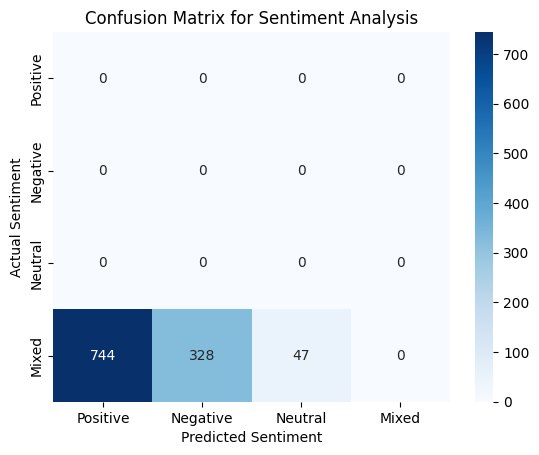

Classification Report:
               precision    recall  f1-score   support

       Mixed       0.00      0.00      0.00    1119.0
    Negative       0.00      0.00      0.00       0.0
   Negatives       0.00      0.00      0.00    2292.0
     Neutral       0.00      0.00      0.00       0.0
    Neutrals       0.00      0.00      0.00   21767.0
    Positive       0.00      0.00      0.00       0.0
   Positives       0.00      0.00      0.00    8749.0

    accuracy                           0.00   33927.0
   macro avg       0.00      0.00      0.00   33927.0
weighted avg       0.00      0.00      0.00   33927.0

  Product Mentions Predicted Sentiment
0           Dexcom            Positive
1           Dexcom            Positive
2           Dexcom            Negative
3           Dexcom            Positive
5           Dexcom            Positive


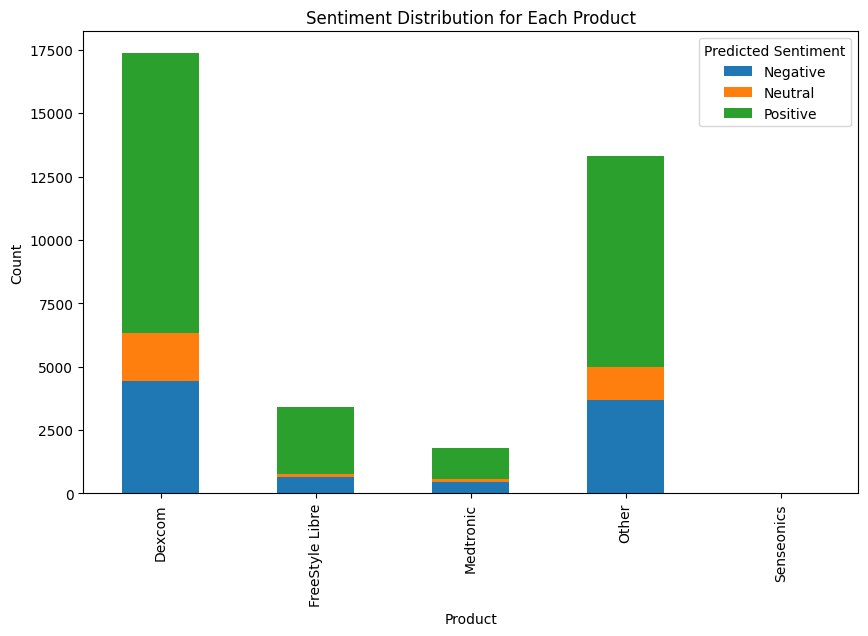

In [ ]:
#confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative', 'Neutral', 'Mixed'], yticklabels=['Positive', 'Negative', 'Neutral', 'Mixed'])
plt.xlabel('Predicted Sentiment')
plt.ylabel('Actual Sentiment')
plt.title('Confusion Matrix for Sentiment Analysis')
plt.show()

#accuracy and classification report
print("Classification Report:\n", classification_report(df_cleaned['Sentiment'], df_cleaned['Predicted Sentiment']))

# Explode the 'Product Mentions' column to convert lists into separate rows
df_exploded = df_cleaned.explode('Product Mentions')

# Check the structure after exploding
print(df_exploded[['Product Mentions', 'Predicted Sentiment']].head())

# Sentiment distribution for each product
product_sentiment = df_exploded.groupby(['Product Mentions', 'Predicted Sentiment']).size().unstack(fill_value=0)

# Plot the sentiment distribution
product_sentiment.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Sentiment Distribution for Each Product')
plt.xlabel('Product')
plt.ylabel('Count')
plt.show()


In [ ]:
#Standardizing the labels in the 'Sentiment' column to match predicted labels
df_cleaned['Standardized Sentiment'] = df_cleaned['Sentiment'].replace({
    'Positives': 'Positive',
    'Negatives': 'Negative',
    'Neutrals': 'Neutral',
    'Mixed': 'Mixed'
})

#Re-compute the sentiment match based on standardized labels
df_cleaned['Sentiment Match'] = df_cleaned['Predicted Sentiment'] == df_cleaned['Standardized Sentiment']

#Calculate the number of matches and mismatches again
num_matches = df_cleaned['Sentiment Match'].sum()
num_mismatches = len(df_cleaned) - num_matches
print(f"Number of Matching Sentiments: {num_matches}")
print(f"Number of Mismatching Sentiments: {num_mismatches}")
match_percentage = (num_matches / len(df_cleaned)) * 100
print(f"Match Percentage: {match_percentage:.2f}%")
print(df_cleaned[['Standardized Sentiment', 'Predicted Sentiment', 'Sentiment Match']].head())

Number of Matching Sentiments: 9994
Number of Mismatching Sentiments: 23933
Match Percentage: 29.46%
  Standardized Sentiment Predicted Sentiment  Sentiment Match
0                Neutral            Positive            False
1               Positive            Positive             True
2               Positive            Negative            False
3                Neutral            Positive            False
5                Neutral            Positive            False


In [ ]:
!pip install textblob flair transformers torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.5/776.5 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 5.4 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993221 sha256=5831aeb1f6918d31c161faba8e45827f412225344e344ba9a164190113ce5055
  Stored in directory: /root/.cache

In [ ]:
from textblob import TextBlob

# Function to classify sentiment using TextBlob
def textblob_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0.5:
        return 'Positive'
    elif analysis.sentiment.polarity < -0.5:
        return 'Negative'
    else:
        return 'Neutral'

# Apply TextBlob sentiment analysis
df_cleaned['TextBlob Sentiment'] = df_cleaned['Combined Text'].apply(textblob_sentiment)

print(df_cleaned[['Sentiment', 'TextBlob Sentiment']].head())


   Sentiment TextBlob Sentiment
0   Neutrals            Neutral
1  Positives            Neutral
2  Positives            Neutral
3   Neutrals            Neutral
5   Neutrals            Neutral


In [ ]:
from textblob import TextBlob

# the function to classify sentiment using TextBlob
def textblob_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0.5:
        return 'Positive'
    elif analysis.sentiment.polarity < -0.5:
        return 'Negative'
    else:
        return 'Neutral'

# Applying TextBlob sentiment analysis to the 'Combined Text' column
df_cleaned['TextBlob Sentiment'] = df_cleaned['Combined Text'].apply(textblob_sentiment)

# Standardizing the labels in the 'Sentiment' column to match TextBlob predicted labels
df_cleaned['Standardized Sentiment'] = df_cleaned['Sentiment'].replace({
    'Positives': 'Positive',
    'Negatives': 'Negative',
    'Neutrals': 'Neutral',
    'Mixed': 'Mixed'
})

# Re-computing the sentiment match based on TextBlob predictions
df_cleaned['TextBlob Sentiment Match'] = df_cleaned['TextBlob Sentiment'] == df_cleaned['Standardized Sentiment']

# Calculating the number of matches and mismatches
num_matches = df_cleaned['TextBlob Sentiment Match'].sum()
num_mismatches = len(df_cleaned) - num_matches
print(f"Number of Matching Sentiments (TextBlob): {num_matches}")
print(f"Number of Mismatching Sentiments (TextBlob): {num_mismatches}")
match_percentage = (num_matches / len(df_cleaned)) * 100
print(f"Match Percentage (TextBlob): {match_percentage:.2f}%")
print(df_cleaned[['Standardized Sentiment', 'TextBlob Sentiment', 'TextBlob Sentiment Match']].head())


Number of Matching Sentiments (TextBlob): 21390
Number of Mismatching Sentiments (TextBlob): 12537
Match Percentage (TextBlob): 63.05%
  Standardized Sentiment TextBlob Sentiment  TextBlob Sentiment Match
0                Neutral            Neutral                      True
1               Positive            Neutral                     False
2               Positive            Neutral                     False
3                Neutral            Neutral                      True
5                Neutral            Neutral                      True


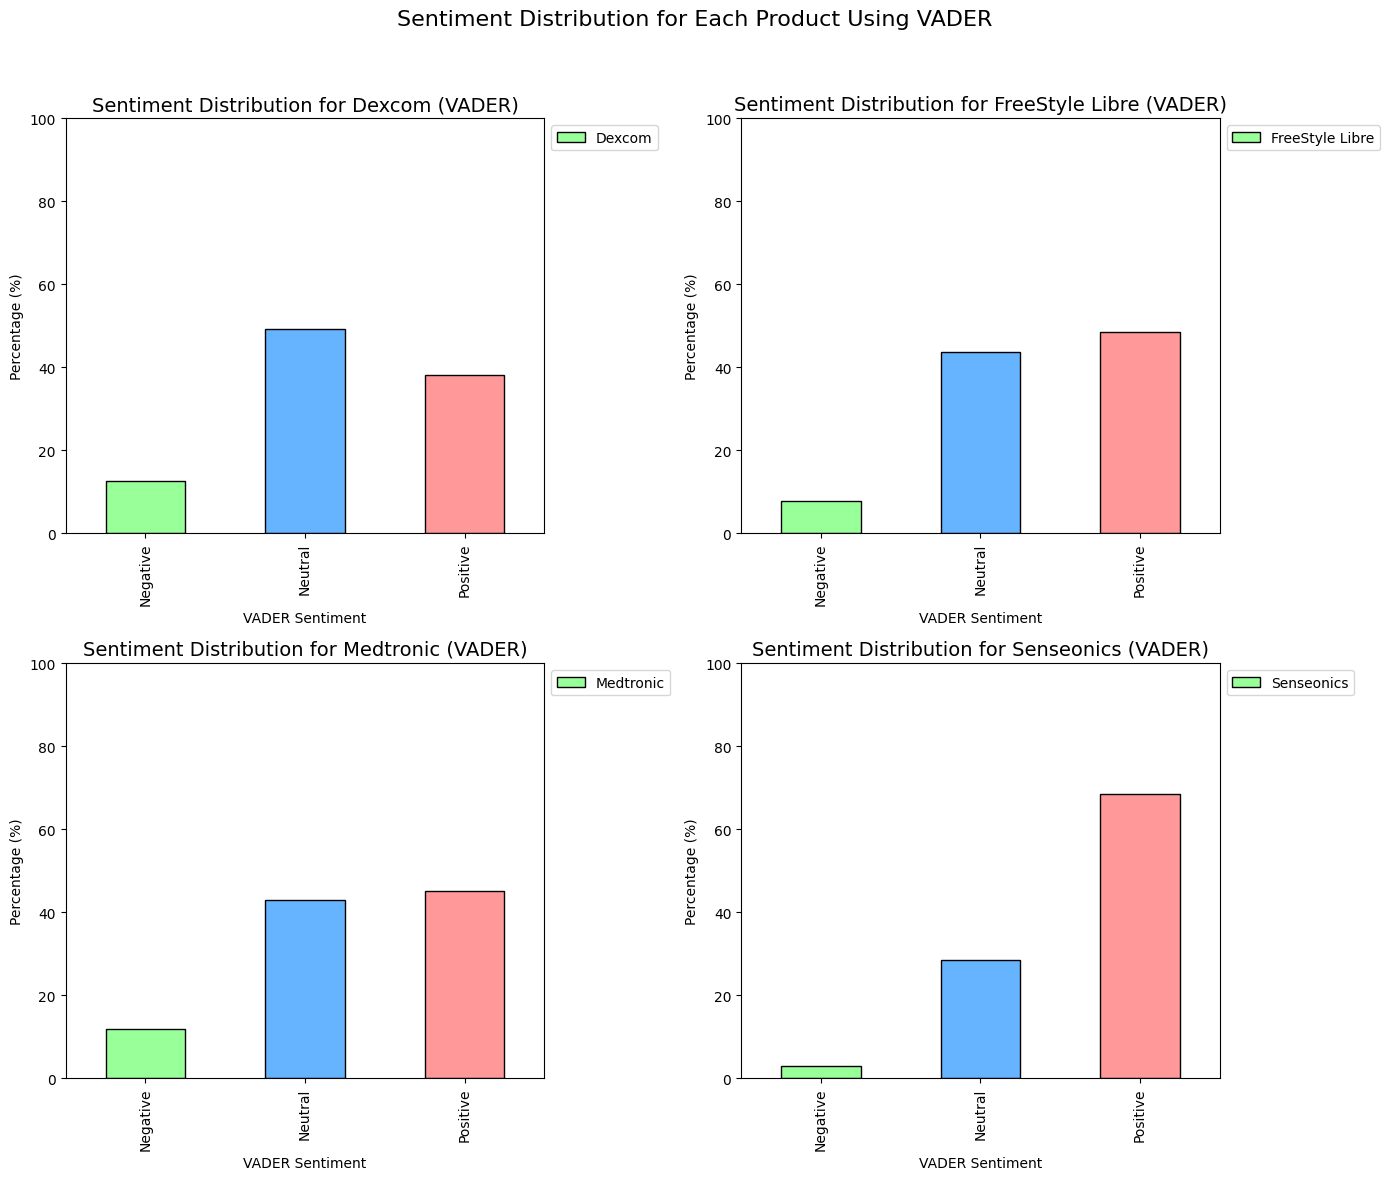

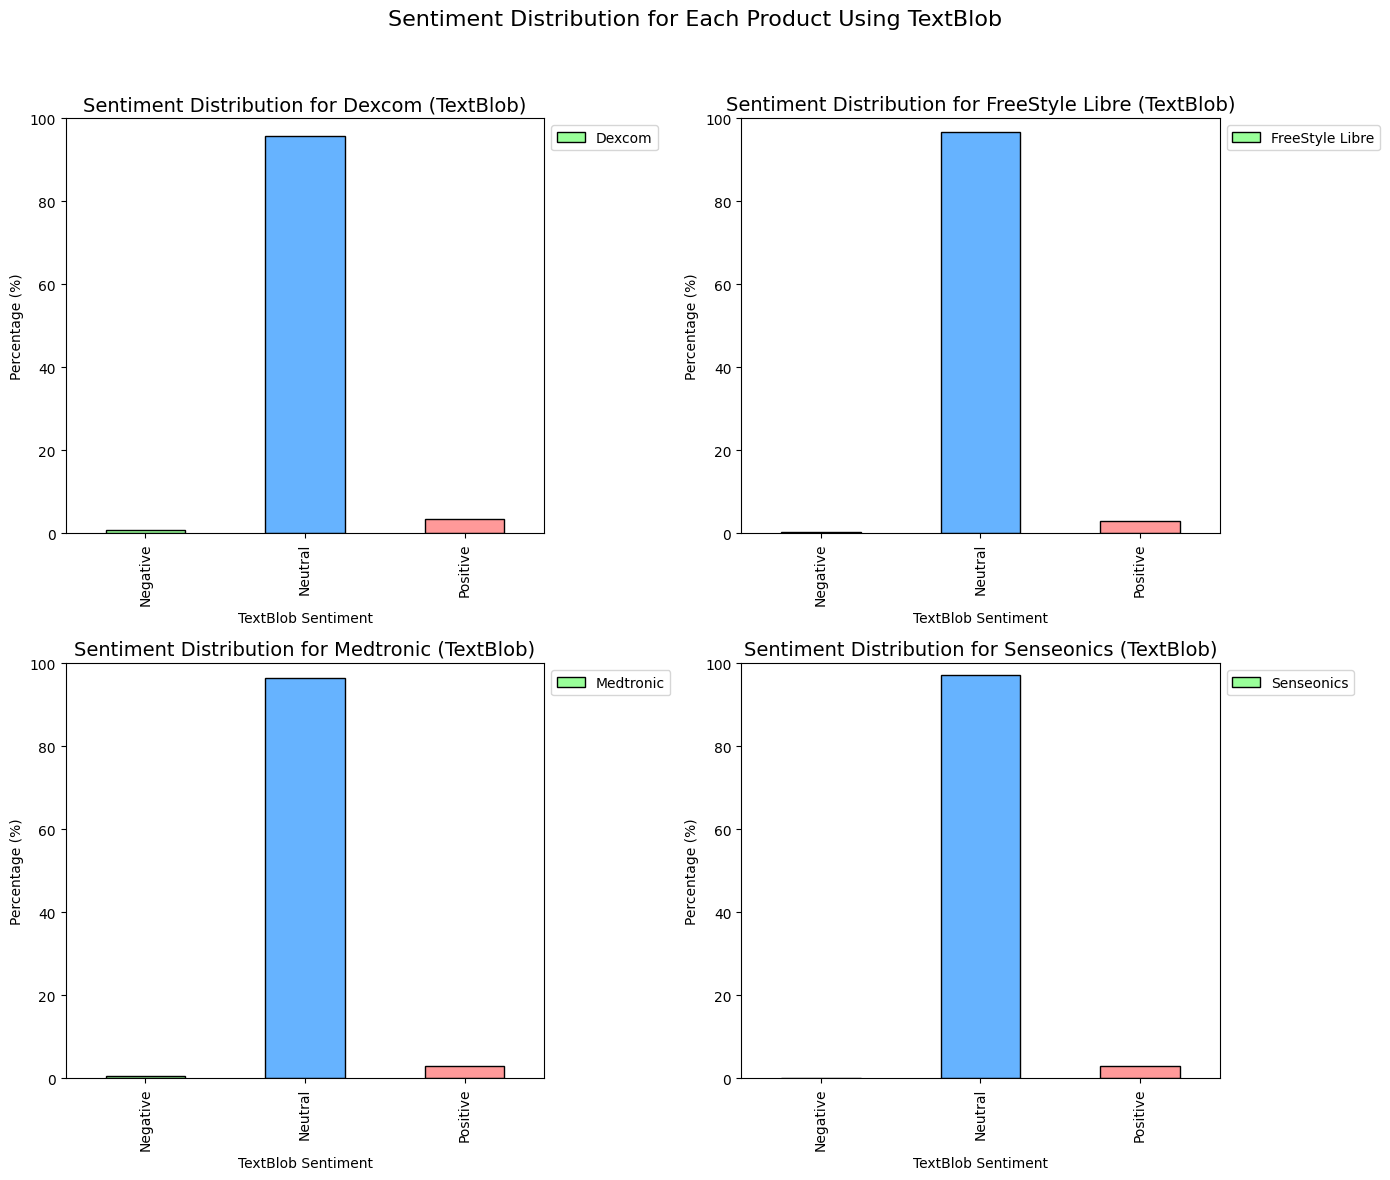

In [ ]:
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Define VADER sentiment function
def get_vader_sentiment(text):
    score = analyzer.polarity_scores(text)
    if score['compound'] >= 0.5:
        return 'Positive'
    elif score['compound'] <= -0.5:
        return 'Negative'
    else:
        return 'Neutral'

# Define TextBlob sentiment function
def get_textblob_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0.5:
        return 'Positive'
    elif analysis.sentiment.polarity < -0.5:
        return 'Negative'
    else:
        return 'Neutral'

# Step 1: Apply VADER and TextBlob sentiment analysis to the 'Combined Text' column
df_cleaned['VADER Sentiment'] = df_cleaned['Combined Text'].apply(get_vader_sentiment)
df_cleaned['TextBlob Sentiment'] = df_cleaned['Combined Text'].apply(get_textblob_sentiment)

# Step 2: Explode 'Product Mentions' to get each product in separate rows
df_exploded = df_cleaned.explode('Product Mentions')

# Step 3: Calculate sentiment counts for each product using VADER and TextBlob
vader_sentiment_counts = df_exploded.groupby(['Product Mentions', 'VADER Sentiment']).size().unstack(fill_value=0)
textblob_sentiment_counts = df_exploded.groupby(['Product Mentions', 'TextBlob Sentiment']).size().unstack(fill_value=0)

# Step 4: Calculate sentiment percentage for each product
vader_sentiment_percentage = vader_sentiment_counts.div(vader_sentiment_counts.sum(axis=1), axis=0) * 100
textblob_sentiment_percentage = textblob_sentiment_counts.div(textblob_sentiment_counts.sum(axis=1), axis=0) * 100

# Step 5: Plot sentiment distribution for each product using VADER and TextBlob

# Define product list and colors
products = ['Dexcom', 'FreeStyle Libre', 'Medtronic', 'Senseonics']
colors = ['#99ff99', '#66b3ff', '#ff9999']  # Colors for Positive, Neutral, Negative

# Create subplots for VADER and TextBlob
fig, axes = plt.subplots(2, 2, figsize=(14, 12))  # 2 rows, 2 columns
fig.suptitle("Sentiment Distribution for Each Product Using VADER", fontsize=16)
axes = axes.flatten()

# Plot for VADER Sentiment Analysis
for i, product in enumerate(products):
    if product in vader_sentiment_percentage.index:
        vader_sentiment_percentage.loc[product].plot(kind='bar', stacked=True, ax=axes[i], color=colors, edgecolor='black')
        axes[i].set_title(f'Sentiment Distribution for {product} (VADER)', fontsize=14)
        axes[i].set_ylabel('Percentage (%)')
        axes[i].set_ylim(0, 100)
        axes[i].legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the layout
plt.show()

# Create subplots for TextBlob sentiment analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle("Sentiment Distribution for Each Product Using TextBlob", fontsize=16)
axes = axes.flatten()

# Plot for TextBlob Sentiment Analysis
for i, product in enumerate(products):
    if product in textblob_sentiment_percentage.index:
        textblob_sentiment_percentage.loc[product].plot(kind='bar', stacked=True, ax=axes[i], color=colors, edgecolor='black')
        axes[i].set_title(f'Sentiment Distribution for {product} (TextBlob)', fontsize=14)
        axes[i].set_ylabel('Percentage (%)')
        axes[i].set_ylim(0, 100)
        axes[i].legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the layout
plt.show()


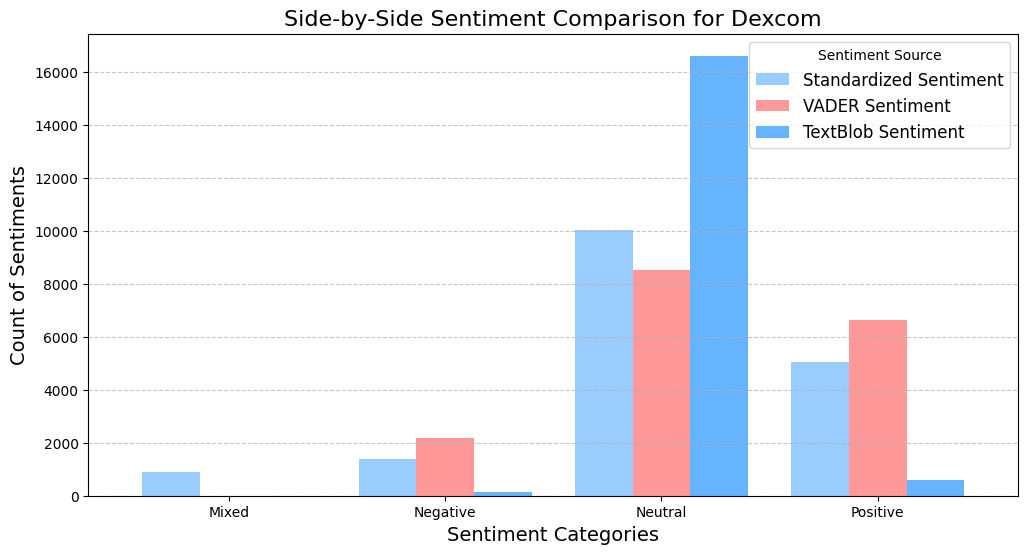

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the product you want to analyze
product_name = 'Dexcom'  # Change this to analyze a different product

# Step 1: Explode the 'Product Mentions' to handle multiple products in a single post
df_exploded = df_cleaned.explode('Product Mentions')

# Step 2: Filter the dataframe for the selected product
df_product = df_exploded[df_exploded['Product Mentions'] == product_name]

# Step 3: Calculate sentiment counts for each sentiment column (Standardized, VADER, and TextBlob)
sentiment_counts_standard = df_product['Standardized Sentiment'].value_counts()
sentiment_counts_vader = df_product['VADER Sentiment'].value_counts()
sentiment_counts_textblob = df_product['TextBlob Sentiment'].value_counts()

# Step 4: Combine the counts into a single DataFrame for side-by-side comparison
comparison_df = pd.DataFrame({
    'Standardized Sentiment': sentiment_counts_standard,
    'VADER Sentiment': sentiment_counts_vader,
    'TextBlob Sentiment': sentiment_counts_textblob
}).fillna(0)  # Fill missing values with 0

# Step 5: Plot the comparison as a grouped bar chart
comparison_df.plot(kind='bar', figsize=(12, 6), width=0.8, color=['#99ccff', '#ff9999', '#66b3ff'])

# Step 6: Customize the chart
plt.title(f'Side-by-Side Sentiment Comparison for {product_name}', fontsize=16)
plt.xlabel('Sentiment Categories', fontsize=14)
plt.ylabel('Count of Sentiments', fontsize=14)
plt.xticks(rotation=0)
plt.legend(title='Sentiment Source', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


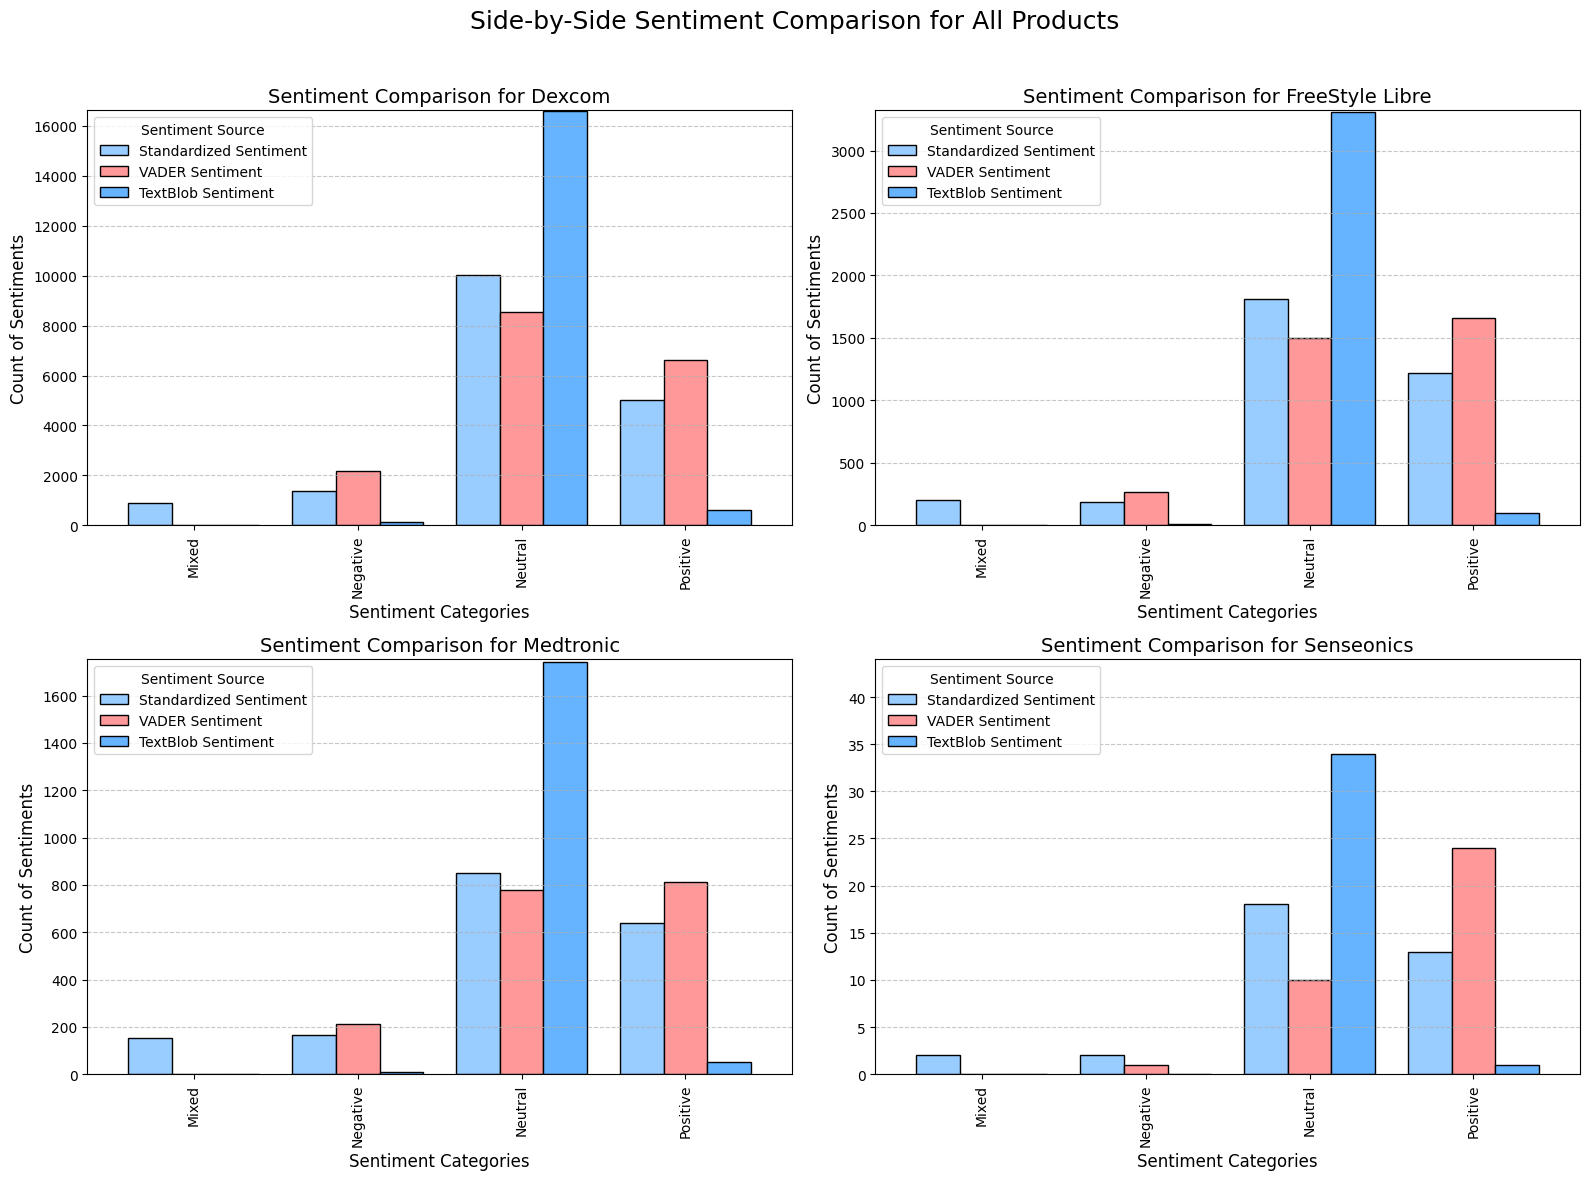

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Define the products to analyze
products = ['Dexcom', 'FreeStyle Libre', 'Medtronic', 'Senseonics']

# Step 2: Explode the 'Product Mentions' to handle multiple products in a single post
df_exploded = df_cleaned.explode('Product Mentions')

# Step 3: Create a 2x2 subplot structure for the four products
fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # Create a 2x2 grid of plots
fig.suptitle("Side-by-Side Sentiment Comparison for All Products", fontsize=18)
axes = axes.flatten()  # Flatten axes to iterate over them easily

# Step 4: Loop through each product and create the comparison plots
for i, product in enumerate(products):
    # Filter the data for the current product
    df_product = df_exploded[df_exploded['Product Mentions'] == product]

    # Calculate sentiment counts for Standardized, VADER, and TextBlob sentiments
    sentiment_counts_standard = df_product['Standardized Sentiment'].value_counts()
    sentiment_counts_vader = df_product['VADER Sentiment'].value_counts()
    sentiment_counts_textblob = df_product['TextBlob Sentiment'].value_counts()

    # Combine the counts into a single DataFrame for side-by-side comparison
    comparison_df = pd.DataFrame({
        'Standardized Sentiment': sentiment_counts_standard,
        'VADER Sentiment': sentiment_counts_vader,
        'TextBlob Sentiment': sentiment_counts_textblob
    }).fillna(0)  # Fill missing values with 0

    # Plot the comparison as a grouped bar chart on the respective subplot
    comparison_df.plot(kind='bar', ax=axes[i], width=0.8, color=['#99ccff', '#ff9999', '#66b3ff'], edgecolor='black')

    # Customize each subplot
    axes[i].set_title(f'Sentiment Comparison for {product}', fontsize=14)
    axes[i].set_xlabel('Sentiment Categories', fontsize=12)
    axes[i].set_ylabel('Count of Sentiments', fontsize=12)
    axes[i].legend(title='Sentiment Source', fontsize=10)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)
    axes[i].set_ylim(0, max(comparison_df.max()) + 10)  # Adjust y-limit based on the highest count

# Step 5: Adjust layout and show the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the suptitle
plt.show()


Columns in the DataFrame: Index(['Post ID', 'Sound Bite Text', 'Title', 'Source Type', 'Post Type',
       'Media Type', 'URL', 'Media Link', 'Domain', 'Sentiment',
       'Published Date (GMT-04:00) New York', 'Author Gender', 'Author URL',
       'Author Name', 'Author Handle', 'Author ID',
       'Author Location - Country 1', 'Author Location - State/Province 1',
       'Author Location - City 1', 'Author Location - Country 2',
       'Author Location - State/Province 2', 'Author Location - City 2',
       'Author Reddit Karma', 'Followers/Daily Unique Visitors/Subscribers',
       'Professions', 'Interests', 'Positive Objects', 'Negative Objects',
       'Richness', 'Quoted Post', 'Quoted Author Name', 'Quoted Author Handle',
       'Total Engagements', 'Post Comments', 'Post Likes', 'Reddit Score',
       'Rating', 'Source Name', 'Combined Text', 'Is Influencer',
       'Is Non Consumer', 'Stemmed Text', 'Lemmatized Text',
       'Original Combined Text', 'Product Mentions', 'per

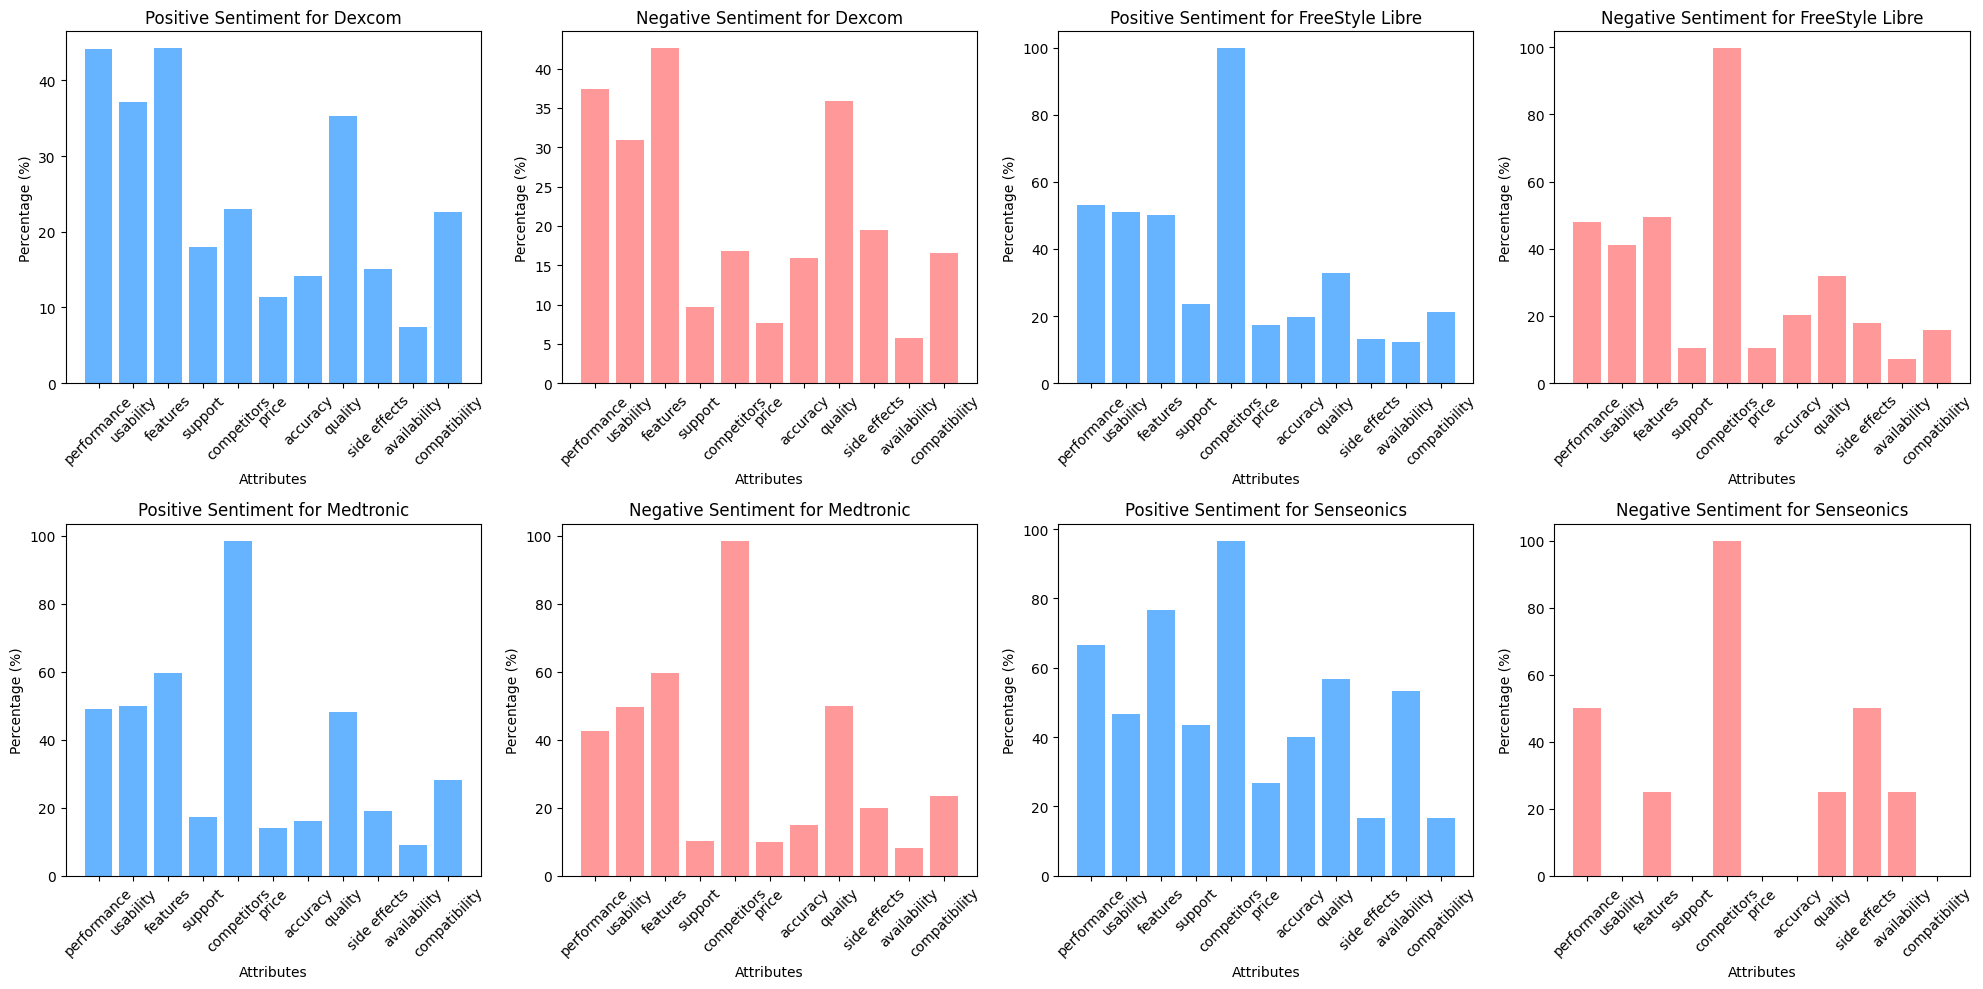

In [ ]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Step 1: Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Step 2: Define a function to classify sentiment using VADER
def get_vader_sentiment(text):
    score = analyzer.polarity_scores(text)
    if score['compound'] >= 0.05:
        return 'Positive'
    elif score['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Step 3: Check if 'VADER Sentiment' column exists, if not create it
if 'VADER Sentiment' not in df_combined.columns:
    # Apply VADER sentiment analysis to the 'Combined Text' column
    df_combined['VADER Sentiment'] = df_combined['Combined Text'].apply(get_vader_sentiment)

# Step 4: Verify that the 'VADER Sentiment' column is created successfully
print("Columns in the DataFrame:", df_combined.columns)

# Define the product list and sentiment labels for VADER Sentiment
product_list = ['Dexcom', 'FreeStyle Libre', 'Medtronic', 'Senseonics']
vader_sentiment_labels = ['Positive', 'Negative']  # Use VADER sentiment labels

# Create a 2x4 subplot structure: 2 rows (sentiments), 4 columns (products)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # 2 rows for sentiments, 4 columns for products
axes = axes.flatten()

# Loop through each product and sentiment category
for i, product in enumerate(product_list):
    for j, sentiment in enumerate(vader_sentiment_labels):
        # Step 5: Filter data for the selected product and VADER sentiment
        filtered_data = df_combined[(df_combined['Product Mentions'].apply(lambda x: product in x)) & (df_combined['VADER Sentiment'] == sentiment)]

        # Sum the attribute columns
        attribute_counts = filtered_data[attributes_map.keys()].sum()
        total_reviews = len(filtered_data)

        # Calculate percentage of reviews mentioning each attribute
        if total_reviews > 0:
            attribute_counts = (attribute_counts / total_reviews) * 100
        else:
            attribute_counts = attribute_counts * 0  # Set to zero if no reviews for that sentiment

        # Prepare data for plotting
        attributes, counts = attribute_counts.index, attribute_counts.values

        # Plot the bar chart on the respective subplot
        axes[i * 2 + j].bar(attributes, counts, color='#66b3ff' if sentiment == 'Positive' else '#ff9999')
        axes[i * 2 + j].set_xlabel('Attributes')
        axes[i * 2 + j].set_ylabel('Percentage (%)')
        axes[i * 2 + j].set_title(f'{sentiment} Sentiment for {product}')
        axes[i * 2 + j].tick_params(axis='x', rotation=45)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


### **7. Positive Objects and Negative Objects** **bold text**

In [ ]:
# Import necessary libraries
import spacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize spaCy and VADER
nlp = spacy.load("en_core_web_sm")
analyzer = SentimentIntensityAnalyzer()

# Define a function to perform aspect-based sentiment analysis
def aspect_based_sentiment(text):
    positive_aspects = []
    negative_aspects = []

    # Parse the text using spaCy
    doc = nlp(text)

    # Perform dependency parsing to identify aspects and associated sentiments
    for token in doc:
        # Check for nouns (potential aspects)
        if token.pos_ in ['NOUN', 'PROPN']:
            # Get the sentiment of the associated adjective or verb (if any)
            sentiment_score = None

            # Check the left and right children for adjectives describing the noun
            for child in token.children:
                if child.dep_ in ['amod', 'acomp'] and child.pos_ == 'ADJ':
                    sentiment_score = analyzer.polarity_scores(child.text)['compound']
                elif child.dep_ in ['advmod'] and child.pos_ == 'ADV':
                    sentiment_score = analyzer.polarity_scores(child.text)['compound']

            # Check the noun's head for verbs indicating sentiment
            if token.head.pos_ in ['VERB'] and token.dep_ in ['nsubj']:
                sentiment_score = analyzer.polarity_scores(token.head.text)['compound']

            # Categorize based on the sentiment score
            if sentiment_score is not None:
                if sentiment_score >= 0.05:
                    positive_aspects.append(token.text)
                elif sentiment_score <= -0.05:
                    negative_aspects.append(token.text)

    return positive_aspects, negative_aspects

# Applying the aspect-based sentiment analysis to each post in the dataframe
df_cleaned['Positive Objects'], df_cleaned['Negative Objects'] = zip(*df_cleaned['Combined Text'].apply(aspect_based_sentiment))
print(df_cleaned[['Combined Text', 'Positive Objects', 'Negative Objects']].head())


                                       Combined Text Positive Objects  \
0  numbers great estimated doesnt care say wants ...               []   
1  tried little side effects help resistance foun...               []   
2  ran characters ill also say newly diagnosed id...               []   
3  lunch ate unit novolog via grilled chicken fet...           [tell]   
5  id new pancreas please dexcomwarrior diabetics...               []   

  Negative Objects  
0               []  
1               []  
2               []  
3               []  
5               []  


In our approach to extract positive and negative objects from consumer posts, we implemented an aspect-based sentiment analysis using a combination of spaCy for natural language processing and VADER for sentiment scoring. The primary goal of this method is to identify specific objects (nouns or proper nouns) within each post and associate them with either positive or negative sentiment based on the contextual language used around these objects.

We began by loading spaCy's pre-trained language model (en_core_web_sm) to parse the text and identify key grammatical components such as nouns and their modifiers. We used dependency parsing to analyze the relationships between words in each sentence, specifically focusing on identifying nouns (aspects) and their associated adjectives or adverbs, which provide sentiment context.

The process of identifying positive or negative aspects unfolded as follows:

Noun Extraction: We treated nouns and proper nouns as potential objects or aspects. For each noun in the text, we checked its left and right children in the dependency tree for descriptive adjectives (ADJ) and adverbs (ADV), which could carry sentiment. These modifiers were then analyzed using VADER to obtain a sentiment score.

Sentiment Attribution: For each adjective or adverb related to a noun, the VADER sentiment analyzer was used to generate a compound sentiment score. If the score was greater than or equal to 0.05, the noun was classified as associated with positive sentiment. Conversely, if the score was less than or equal to -0.05, the noun was categorized as linked to negative sentiment.

Verb Sentiment Association: In addition to adjectives and adverbs, we checked if the noun was part of a subject-verb relationship (using its head in the dependency tree). If the head was a verb, we also applied sentiment analysis to the verb to see if it carried any emotional weight that could influence the sentiment of the noun.

Result Storage: The results were returned in the form of two lists—one for positive objects and one for negative objects—which were then stored in the columns Positive Objects and Negative Objects for each post in the dataset.

This approach enabled us to systematically extract and categorize the objects mentioned in the posts based on their associated sentiment, providing insights into which specific features or aspects of the Continuous Glucose Monitoring (CGM) products consumers were responding to positively or negatively. This analysis also allowed us to drill deeper into the reasons behind consumer sentiment by associating emotions with specific entities in the text.

### <b>8. Retaining context</b>

In [ ]:
# Load the spaCy model
nlp = spacy.load("en_core_web_sm")
analyzer = SentimentIntensityAnalyzer()

# Define a function to get VADER sentiment
def get_vader_sentiment(text):
    score = analyzer.polarity_scores(text)
    if score['compound'] >= 0.05:
        return 'Positive'
    elif score['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Separate original posts and replies/comments
original_posts = df_cleaned[df_cleaned['Post Type'] == 'Original']
replies_comments = df_cleaned[df_cleaned['Post Type'].isin(['Replies and Comments'])]

# Create a mapping from URLs to Original Post Text
post_context_mapping = pd.Series(original_posts['Combined Text'].values, index=original_posts['URL']).to_dict()

# Map original post content to each reply/comment
replies_comments['Original Post Context'] = replies_comments['URL'].map(post_context_mapping)

# Merge the context for comments/replies
replies_comments['Full Context'] = replies_comments['Original Post Context'].fillna('') + " " + replies_comments['Combined Text']

# Perform aspect-based sentiment analysis using combined context for replies
replies_comments['Contextual Sentiment'] = replies_comments['Full Context'].apply(get_vader_sentiment)

# Compare with the original sentiment column to see how it changes
comparison_df = replies_comments[['Combined Text', 'Original Post Context', 'Full Context', 'Sentiment', 'Contextual Sentiment']]
print(comparison_df.head())


                                        Combined Text Original Post Context  \
0   numbers great estimated doesnt care say wants ...                   NaN   
1   tried little side effects help resistance foun...                   NaN   
2   ran characters ill also say newly diagnosed id...                   NaN   
7   currently impatiently waiting told canada earl...                   NaN   
10  ive tried without doctors prescription expensi...                   NaN   

                                         Full Context  Sentiment  \
0    numbers great estimated doesnt care say wants...   Neutrals   
1    tried little side effects help resistance fou...  Positives   
2    ran characters ill also say newly diagnosed i...  Positives   
7    currently impatiently waiting told canada ear...      Mixed   
10   ive tried without doctors prescription expens...   Neutrals   

   Contextual Sentiment  
0              Positive  
1              Positive  
2              Negative  
7           

Approach for Contextual Analysis of Comments and Replies:

1.   Separate Original Posts and Replies/Comments:

*   Split the dataset into Original Posts and Replies/Comments using the Post Type column to differentiate between standalone posts and those that are part of a conversation.



2.   Create a Contextual Mapping:

*   Use a unique identifier like Post ID or URL to create a mapping between the replies/comments and their corresponding original posts. This allows replies and comments to be linked back to their respective contexts.

3.   Combine Original Post with Comments/Replies:

*    For each reply or comment, merge the original post text and the comment/reply text to create a new column (Full Context), which represents the complete conversational context.

4. Contextual Sentiment Analysis:

*    Perform sentiment analysis on the Full Context for replies/comments instead of analyzing them in isolation.

*    For original posts, use the standard text-based sentiment analysis.


5. Compare Sentiments:

*     Compare the sentiment scores of Original Posts and Replies/Comments to identify patterns:
**           Check whether comments are in agreement or disagreement with the original post
**           Determine if there is a sentiment shift in the conversation.



### **9. Changes/modifications to increase the adoption of each product**
Based on the sentiment analysis, the following recommendations can help improve the adoption of each Continuous Glucose Monitoring (CGM) product:

1. **Dexcom:**

*   Address Concerns Over High Cost:

Strategy: Provide tiered pricing options or introduce cost-saving bundles. Include promotions such as free trials or rebates for long-term users.

Communication: Highlight Dexcom's superior accuracy and unique features, such as real-time glucose alerts, to justify the premium price.

-Anmol: Focus on marketing also look into pricing
-Team: Public rebate/corporate program

*   Improve Sensor Reliability:

Strategy: Increase investment in R&D to improve sensor lifespan and reduce failure rates.

Support: Enhance customer support channels to assist with common issues (e.g., sensor failures) and provide replacements proactively.



2. **FreeStyle Libre:**

*   Emphasize Affordability and Ease of Use:

Strategy: Market FreeStyle Libre as the most budget-friendly option with straightforward usability, targeting new users and cost-conscious consumers.

Education: Launch campaigns focused on user education for setup and maintenance, which can improve user satisfaction and reduce frustration.
*   Expand Integration with Mobile Apps:

Strategy: Strengthen compatibility with popular diabetes management apps and platforms.

Feature Addition: Consider adding predictive insights and trends to the app interface to match competitors' advanced features.

3. **Medtronic:**

*   Improve User Experience:

Strategy: Address feedback around complexity and usability. Simplify the setup process and invest in training resources.

Partnerships: Collaborate with healthcare providers to integrate device support into clinical workflows and enhance patient training.

*   Highlight Unique Features:

Strategy: Emphasize any distinctive features (e.g., closed-loop insulin delivery) and demonstrate the value for advanced users.

Marketing Focus: Showcase success stories from long-term Medtronic users who have achieved stable glucose levels.



4. **Senseonics:**

*   Increase Awareness:

Strategy: Raise awareness of the Senseonics brand and differentiate its technology (e.g., long-term implantable sensors).

Marketing: Use targeted campaigns and partnerships to promote Senseonics' unique long-term sensor benefits.

*   Address Insertion Concerns:

Strategy: Address consumer apprehensions about sensor insertion with educational content and support from healthcare professionals.

Reassurance Campaigns: Focus on patient safety, comfort, and the long-term cost-effectiveness of the device.


**General Recommendations:**



*   Leverage Positive User Stories:Each brand should leverage positive consumer reviews and testimonials to strengthen its brand image. Share success stories on various platforms.

*   Strengthen Online Presence and Engagement: Invest in community engagement on platforms like Reddit, Instagram, and patient forums, where a large volume of discussions and reviews originate.

*   Offer Personalized Support: Utilize sentiment analysis results to identify common pain points and offer personalized solutions through digital channels.


## **Audience Analysis**


Understanding your audience and segmenting it for targeting, marketing and innovation is a key aspect
of Product management. This dataset does not have enough information for a through audience analysis.
However, this section will introduce some aspects. You can do Excel based analysis (no programming necessary)
for these questions

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
raw = df_cleaned.copy()

### **1. Identify any of the following attributes you can**

#### **Gender-Based**

In [ ]:
bold_start = "\033[1m"
bold_end = "\033[0m"

# Step 1: Separate the data into Female, Male, and Unknown groups
female_df = raw[raw['Author Gender'] == 'Female']
male_df = raw[raw['Author Gender'] == 'Male']
unknown_df = raw[raw['Author Gender'] == 'Unknown']

# Step 2: Define a function to calculate sentiment ratio for each group
def calc_sentiment_ratio(df):
    total = len(df)
    positive_ratio = len(df[df['Sentiment'] == 'Positives']) / total * 100
    neutral_ratio = len(df[df['Sentiment'] == 'Neutrals']) / total * 100
    mixed_ratio  = len(df[df['Sentiment'] == 'Mixed']) / total * 100
    negative_ratio = len(df[df['Sentiment'] == 'Negatives']) / total * 100
    return pd.Series({'Positives': positive_ratio, 'Neutrals': neutral_ratio,'Mixed':mixed_ratio, 'Negatives': negative_ratio})

# Calculate sentiment ratios for Female, Male, and Unknown
female_sentiment_ratio = calc_sentiment_ratio(female_df)
male_sentiment_ratio = calc_sentiment_ratio(male_df)
unknown_sentiment_ratio = calc_sentiment_ratio(unknown_df)

#Count the number of Female, Male, and Unknown
gender_counts = raw['Author Gender'].value_counts()

#Calculate the total number of entries
total_entries = len(raw)

#Create a DataFrame to store the counts and percentages
gender_summary = pd.DataFrame({
    'Count': gender_counts,
    'Percentage': (gender_counts / total_entries) * 100
})


#Pretty print the summary table with formatting
print(f"{bold_start}\nSummary Table:{bold_end}")
print(gender_summary.to_string(formatters={'Count': '{:,.0f}'.format, 'Percentage': '{:.1f}%'.format}))


# Display the results for sentiment ratio

print(f"{bold_start}\nFemale Sentiment Ratio:{bold_end}")
print(female_sentiment_ratio)

print(f"{bold_start}\nMale Sentiment Ratio:{bold_end}")
print(male_sentiment_ratio)

print(f"{bold_start}\nUnknown Sentiment Ratio:{bold_end}")
print(unknown_sentiment_ratio)


Summary Table:
               Count Percentage
Author Gender                  
Unknown       31,502      92.9%
Female         1,228       3.6%
Male           1,197       3.5%

Female Sentiment Ratio:
Positives    28.257329
Neutrals     60.993485
Mixed         3.583062
Negatives     7.166124
dtype: float64

Male Sentiment Ratio:
Positives    24.477861
Neutrals     65.413534
Mixed         4.010025
Negatives     6.098580
dtype: float64

Unknown Sentiment Ratio:
Positives    25.741223
Neutrals     64.234017
Mixed         3.260110
Negatives     6.764650
dtype: float64


#### **DiabeticType-Based**

In [ ]:
top_10_source_names = raw['Source Name'].value_counts().nlargest(10)

# Show the result
print(top_10_source_names)

Source Name
r/diabetes_t1            13284
r/diabetes                7254
r/Type1Diabetes           5887
r/dexcom                   663
r/diabetes_t2              487
r/Freestylelibre           268
r/GestationalDiabetes      259
r/Biohackers                92
r/BumpersWhoBolus           73
r/type2diabetes             68
Name: count, dtype: int64


In [ ]:
import pandas as pd

# Assuming raw is your original DataFrame and it contains a 'Sentiment' column

# Define a function to label the source as T1 or T2 based on Source Name
def label_type(row):
    # Check if 'Source Name' is a string before applying .lower()
    if isinstance(row['Source Name'], str):
        if 't1' in row['Source Name'].lower() or 'type1' in row['Source Name'].lower():
            return 'T1'
        elif 't2' in row['Source Name'].lower() or 'type2' in row['Source Name'].lower():
            return 'T2'
        else:
            return 'Unknown'
    else:
        return 'Unknown'  # Return 'Unknown' if 'Source Name' is not a string

# Step 1: Apply the function to the entire raw DataFrame to add Type_Label
raw['Type_Label'] = raw.apply(label_type, axis=1)

# Step 2: Divide the dataset into T1, T2 and others.
raw_T1 = raw[raw['Type_Label'] == 'T1']
raw_T2 = raw[raw['Type_Label'] == 'T2']
raw_unknown = raw[raw['Type_Label'] == 'Unknown']

# Step 3: Calculate the ratio of each sentiment.
T1_ratio = calc_sentiment_ratio(raw_T1)
T2_ratio = calc_sentiment_ratio(raw_T2)
unknown_ratio = calc_sentiment_ratio(raw_unknown)

#Count the number of Female, Male, and Unknown
Type_counts = raw['Type_Label'].value_counts()

#Calculate the total number of entries
total_entries = len(raw)

#Create a DataFrame to store the counts and percentages
Type_summary = pd.DataFrame({
    'Count': Type_counts,
    'Percentage': (Type_counts / total_entries) * 100
})



#Pretty print the summary table with formatting
print(f"{bold_start}\nSummary Table:{bold_end}")
print(Type_summary.to_string(formatters={'Count': '{:,.0f}'.format, 'Percentage': '{:.1f}%'.format}))
# Display the sentiment ratio for T1 and T2

# Display the results
print(f"{bold_start}\nType 1 Sentiment Ratio:{bold_end}")
print(T1_ratio)

print(f"{bold_start}\nType 2 Sentiment Ratio:{bold_end}")
print(T2_ratio)

print(f"{bold_start}\nUnknown Sentiment Ratio:{bold_end}")
print(unknown_ratio)






Summary Table:
            Count Percentage
Type_Label                  
T1         19,175      56.5%
Unknown    14,195      41.8%
T2            557       1.6%

Type 1 Sentiment Ratio:
Positives    24.359844
Neutrals     64.876141
Mixed         3.316819
Negatives     7.447197
dtype: float64

Type 2 Sentiment Ratio:
Positives    35.727110
Neutrals     59.784560
Mixed         1.615799
Negatives     2.872531
dtype: float64

Unknown Sentiment Ratio:
Positives    27.326523
Neutrals     63.360338
Mixed         3.339204
Negatives     5.973934
dtype: float64


#### **Profession-Based**

In [ ]:
# Get unique values from the 'Professions' column in the raw DataFrame
unique_professions = raw['Professions'].unique()

# Display the list of unique professions
print(unique_professions)


[nan 'Technology' 'Education' 'Banking and Finance' 'Science and Research'
 'Law and Order' 'Technology; Science and Research' 'Student' 'Homemaker'
 'Hospitality' 'Student; Education' 'Student; Science and Research'
 'Student; Politics and Government; Education'
 'Banking and Finance; Science and Research' 'Religion' 'Social Services'
 'Personal and Home Services']


In [ ]:
# Step 1: Get unique values from the 'Professions' column
unique_professions = raw['Professions'].dropna().unique()

# Step 2: Define a function to calculate sentiment ratio for each group (already defined)
# def calc_sentiment_ratio(df):
#     total = len(df)
#     positive_ratio = len(df[df['Sentiment'] == 'Positives']) / total * 100
#     neutral_ratio = len(df[df['Sentiment'] == 'Neutrals']) / total * 100
#     mixed_ratio  = len(df[df['Sentiment'] == 'Mixed']) / total * 100
#     negative_ratio = len(df[df['Sentiment'] == 'Negatives']) / total * 100
#     return pd.Series({'Positives': positive_ratio, 'Neutrals': neutral_ratio, 'Mixed': mixed_ratio, 'Negatives': negative_ratio})

# Step 3: Loop through each unique profession and calculate statistics
profession_summary = {}

for profession in unique_professions:
    # Filter rows for each profession
    profession_df = raw[raw['Professions'] == profession]

    # Calculate the sentiment ratio for this profession
    sentiment_ratio = calc_sentiment_ratio(profession_df)

    # Store the sentiment ratio in a dictionary
    profession_summary[profession] = sentiment_ratio

# Convert the dictionary to a DataFrame for easy viewing
profession_sentiment_df = pd.DataFrame(profession_summary).T

# Pretty print the summary table for profession sentiment ratio
print(f"{bold_start}\nProfession Sentiment Ratios:{bold_end}")
print(profession_sentiment_df)

# Step 4: Count the number of entries per profession
profession_counts = raw['Professions'].value_counts()

# Step 5: Calculate the total number of entries
total_entries = len(raw)

# Step 6: Create a DataFrame to store the counts and percentages for professions
profession_summary_df = pd.DataFrame({
    'Count': profession_counts,
    'Percentage': (profession_counts / total_entries) * 100
})

# Pretty print the summary table for profession count and percentage
print(f"{bold_start}\nSummary Table for Professions:{bold_end}")
print(profession_summary_df.to_string(formatters={'Count': '{:,.0f}'.format, 'Percentage': '{:.1f}%'.format}))

# Step 7: Filter rows where 'Professions' or 'Interests' contains 'health' or 'Health'
filtered_df_health = raw[(raw['Professions'].str.contains('health', case=False, na=False)) |
                         (raw['Interests'].str.contains('health', case=False, na=False))]

# Step 8: Group by 'Sentiment' and calculate the ratio for health-related professions
health_sentiment_ratio = calc_sentiment_ratio(filtered_df_health)

# Display the sentiment ratio for health-related professions
print(f"{bold_start}\nHealth-Related Profession Sentiment Ratio:{bold_end}")
print(health_sentiment_ratio)



Profession Sentiment Ratios:
                                             Positives    Neutrals  Mixed  \
Technology                                   41.176471   58.823529    0.0   
Education                                    29.166667   66.666667    0.0   
Banking and Finance                           0.000000  100.000000    0.0   
Science and Research                         10.000000   90.000000    0.0   
Law and Order                                 0.000000  100.000000    0.0   
Technology; Science and Research              0.000000   50.000000   50.0   
Student                                      14.285714   85.714286    0.0   
Homemaker                                     0.000000  100.000000    0.0   
Hospitality                                   0.000000  100.000000    0.0   
Student; Education                            0.000000  100.000000    0.0   
Student; Science and Research                 0.000000  100.000000    0.0   
Student; Politics and Government; Education   

#### **Age-Based**

In [ ]:
!pip install textstat
import pandas as pd
import nltk
from textstat import flesch_reading_ease, gunning_fog
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Assuming 'raw' is your original DataFrame and 'Combined Text' is the relevant column
# Step 1: Tokenize the text and calculate readability scores
def calculate_readability(text):
    # Calculate different readability scores
    flesch_score = flesch_reading_ease(text)
    fog_score = gunning_fog(text)
    return pd.Series([flesch_score, fog_score])

# Apply the readability functions to each Combined Text
raw[['Flesch Reading Ease', 'Gunning Fog Index']] = raw['Combined Text'].apply(calculate_readability)

# Step 2: Feature extraction for vocabulary richness (optional)
# Example: Calculate average word length, total words, etc.
def vocab_richness(text):
    words = nltk.word_tokenize(text)
    avg_word_len = sum(len(word) for word in words) / len(words) if words else 0
    return avg_word_len

# Apply vocabulary richness calculation
raw['Avg Word Length'] = raw['Combined Text'].apply(vocab_richness)

# Step 3: Define a labeling function manually (Assuming you have labeled data for supervised learning)
# If no labels are available, this step can be used for manual labeling of training data
def label_adult_child(row):
    # Logic for manual labeling or heuristic-based labeling
    # For example, you might use heuristic rules to classify based on readability and vocab richness
    if row['Flesch Reading Ease'] < 60 or row['Avg Word Length'] > 4.5:
        return 'Adult'
    else:
        return 'Child'

# Apply labeling function
raw['Age_Label'] = raw.apply(label_adult_child, axis=1)

# Step 4: Train-test split
X = raw[['Flesch Reading Ease', 'Gunning Fog Index', 'Avg Word Length']]  # Feature matrix
y = raw['Age_Label']  # Target labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Train a classifier (e.g., Logistic Regression)
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Step 6: Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.5 MB/s eta 0:00:00
              precision    recall  f1-score   support

       Adult       1.00      1.00      1.00      6620
       Child       0.97      0.96      0.97       166

    accuracy                           1.00      6786
   macro avg       0.98      0.98      0.98      6786
weighted avg       1.00      1.00      1.00      6786



In [ ]:
# Count occurrences of each label
label_counts = raw['Age_Label'].value_counts()

#Calculate the total number of entries
total_entries = len(raw)

#Create a DataFrame to store the counts and percentages
Age_summary = pd.DataFrame({
    'Count': label_counts,
    'Percentage': (label_counts / total_entries) * 100
})



#Pretty print the summary table with formatting
print(f"{bold_start}\nSummary Table:{bold_end}")
print(Age_summary.to_string(formatters={'Count': '{:,.0f}'.format, 'Percentage': '{:.1f}%'.format}))

# Step 1: Separate the data into Adult and Child groups
adult_df = raw[raw['Age_Label'] == 'Adult']
child_df = raw[raw['Age_Label'] == 'Child']


# Calculate sentiment ratios for Adult and Child
adult_sentiment_ratio = calc_sentiment_ratio(adult_df)
child_sentiment_ratio = calc_sentiment_ratio(child_df)

# Display the results
print("\nAdult Sentiment Ratio:")
print(adult_sentiment_ratio)

print("\nChild Sentiment Ratio:")
print(child_sentiment_ratio)



Summary Table:
           Count Percentage
Age_Label                  
Adult     33,134      97.7%
Child        793       2.3%

Adult Sentiment Ratio:
Positives    25.737913
Neutrals     64.097302
Mixed         3.350033
Negatives     6.814752
dtype: float64

Child Sentiment Ratio:
Positives    27.868852
Neutrals     66.708701
Mixed         1.134931
Negatives     4.287516
dtype: float64


### **2. Use this information to create between 5 to 10 segments of consumers with one or more characteristics that you could leverage for innovation (products with specific features) or engagement/marketing for at least one of the products you uncovered earlier**

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Step 1: Extract relevant features from the DataFrame
# Make sure to have the relevant columns
data = raw[['Author Gender', 'Type_Label', 'Professions', 'Age_Label', 'Sentiment']]

# Manual encoding for Author Gender
data['Author Gender'] = data['Author Gender'].map({'Male': 2, 'Female': 1, 'Unknown': 0})

# Manual encoding for Type Label
data['Type_Label'] = data['Type_Label'].map({'T1': 1, 'T2': 2, 'Unknown': 0})

# Manual encoding for Professions (assuming Health is part of this column)
data['Professions'] = data['Professions'].apply(lambda x: 1 if pd.notna(x) and 'Health' in x else 0)

# Manual encoding for Age Label
data['Age_Label'] = data['Age_Label'].map({'Adult': 1, 'Child': 0})

# Sentiment encoding (already in 1, 0, -1 format)
data['Sentiment'] = data['Sentiment'].map({'Positives': 1, 'Neutrals': 0,'Negatives': -1, 'Mixed': 0})


# Step 2: Convert categorical data into numeric labels using LabelEncoder
label_encoders = {}
for column in ['Author Gender', 'Type_Label', 'Professions', 'Age_Label']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column].astype(str))  # Convert to string in case of NaNs
    label_encoders[column] = le  # Save the encoder for potential inverse_transform use

# Step 3: Standardize the data to have mean 0 and variance 1
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[['Author Gender', 'Type_Label', 'Professions', 'Age_Label']])


In [ ]:
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
pca_result = pca.fit_transform(scaled_data)


In [ ]:
# Check explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio

array([0.35582338, 0.33212339])

Text(0, 0.5, 'WCSS')

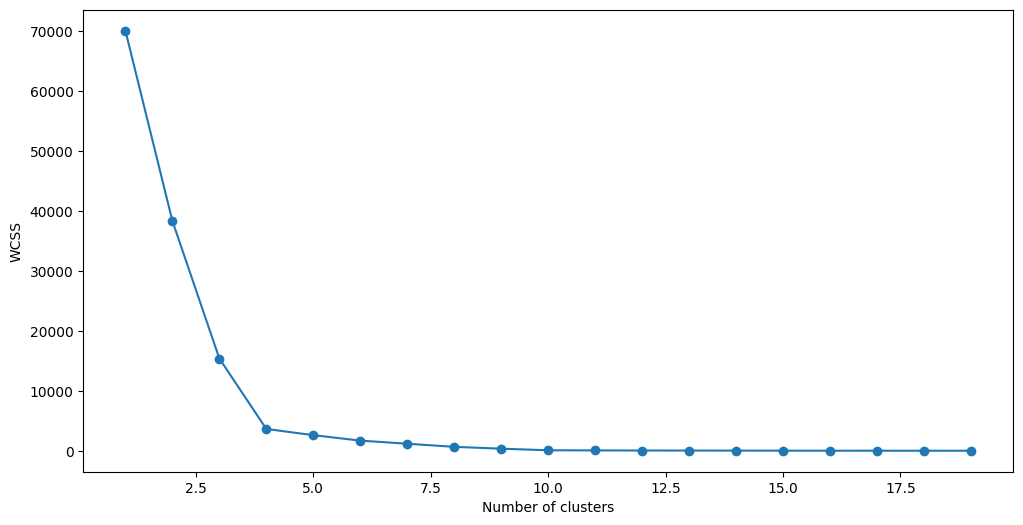

In [ ]:
#Step 4Detemine the number of clusters.
wcss = []

for i in range(1,20):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_pca.fit(pca_result)
    wcss.append(kmeans_pca.inertia_)


plt.figure(figsize=(12,6))
plt.plot(range(1,20), wcss, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

As a result of Elbow methods, number of means is decided to be 4.


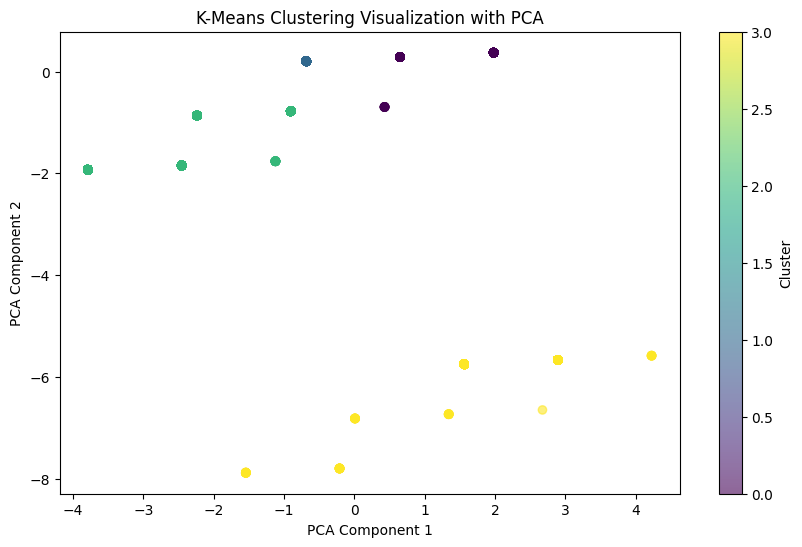

Sentiment    -1      0     1
Cluster                     
0          1325  12325  4452
1           776   8438  3449
2           157   1585   627
3            34    538   221


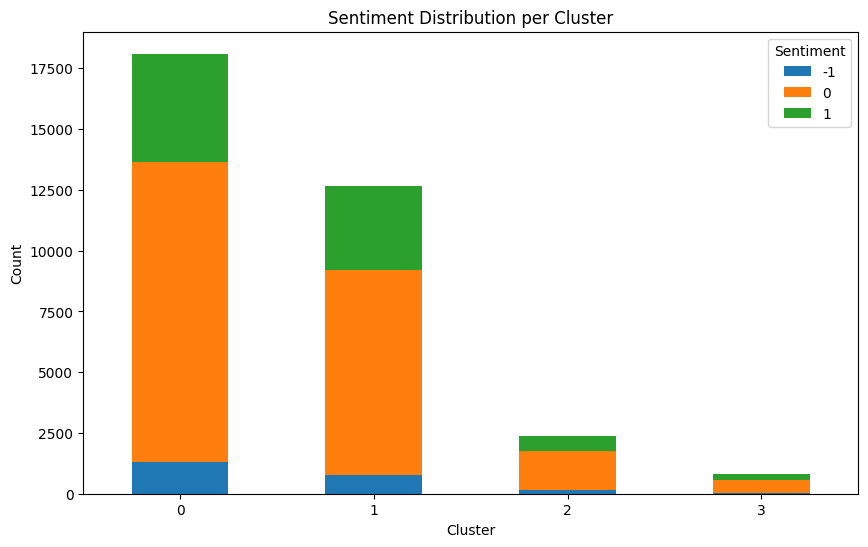

In [ ]:
# Step 4: Apply K-Means with the optimal number of clusters (K) based on the previous plot
# Let's assume from the Elbow Method that K=3 is optimal
optimal_k = 4  # You can change this based on the previous plot results
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Step 6: Add cluster labels back to the original DataFrame
data['Cluster'] = clusters

# Step 7: Visualize the clusters with PCA (for 2D visualization)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=data['Cluster'], cmap='viridis', alpha=0.6)
plt.colorbar(label='Cluster')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-Means Clustering Visualization with PCA')
plt.show()

# Step 8: Group by Cluster and Sentiment to analyze the sentiment distribution in each cluster
sentiment_distribution = data.groupby(['Cluster', 'Sentiment']).size().unstack().fillna(0)
print(sentiment_distribution)

# Step 9: Plot the sentiment distribution within each cluster
sentiment_distribution.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Sentiment Distribution per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


In [ ]:
!pip install openai
import os
from openai import OpenAI
import openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.7/383.7 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.2/325.2 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.3 MB/s eta 0:00:00


In [ ]:
client = OpenAI(
    api_key="",
)

In [ ]:
# function for calling the model and the prompt

def get_completion(prompt, model="gpt-3.5-turbo"):
    messages = [{"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0,
    )
    return(response.choices[0].message.content)

In [ ]:
import openai
import pandas as pd


# Define a function to process the OpenAI API request for each row
def analyze_sentiment_and_extract(dataframe):
    prompt_template = """Please extract the number of customers with gender and age (adult or child) and the summary of the result with the distribution of positives, negatives, neutrals, mixed in each segmentation for the following:

    Sound Bite Text: {sound_bite_text}
    Title: {title}
    Sentiment: {sentiment}
    """

    # Iterate through the dataframe rows and create API requests
    for index, row in dataframe.iterrows():
        prompt = prompt_template.format(
            sound_bite_text=row['Sound Bite Text'],
            title=row['Title'],
            sentiment=row['Sentiment']
        )

        response = openai.Completion.create(
            engine="text-davinci-003",
            prompt=prompt,
            max_tokens=150
        )

        # Print the response for each entry
        print(f"Response for row {index}:\n", response['choices'][0]['text'], "\n")

# Use the function with the 'raw' dataframe
analyze_sentiment_and_extract(raw)
